## Семинар 10: "Генерация текстов"

ФИО: Находнов Максим Сергеевич

In [141]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
import progressbar
%matplotlib inline

In [142]:
torch.cuda.set_device(2)

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [143]:
! head -n 2 author-quote.txt

A. A. Milne	If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
A. A. Milne	Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.


In [144]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

In [145]:
lines[1]

"Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think."

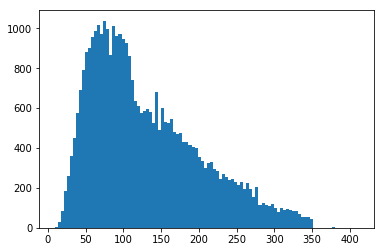

In [146]:
plt.hist(list(map(len, lines)), bins=100);

In [147]:
line = lines[0]

In [148]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [149]:
lines = filter(lambda x: len(x) <= 50, lines)

In [150]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [151]:
vocab = Vocabulary(lines)

In [152]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [153]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [154]:
dataset = Quotes(lines, vocab)

In [155]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [156]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(hidden_size, vocabulary_size))
    
    def forward(self, input):
        H = Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda()
        C = Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda()

        embedding = self.embedding(input)
        output, _ = self.generator(embedding, (H))
        classes = self.classifier(output[0])
        
        return classes
    
    def generate(self, vocab, max_len=100):
        H = Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda()
        C = Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda()

        line = ''
        current_token = '<go>'
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True).cuda()
            
            embedding = self.embedding(token_id)
            output, (H) = self.generator(embedding, (H))
            classes = self.classifier(output[0])
            probas = nn.Softmax()(classes)
            
            new_token_id = torch.distributions.Categorical(probas).sample().cpu().data.numpy()[0]
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [157]:
oracle = Oracle(vocab.size, embedding_size=64, hidden_size=128, layers=4)

In [158]:
oracle.cuda()

Oracle(
  (embedding): Embedding(75, 64)
  (generator): GRU(64, 128, num_layers=4, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=75, bias=True)
  )
)

### Часть 3: обучение модели

In [159]:
def init_params(network):
    for name, param in network.named_parameters():
        if 'b' in name:
            nn.init.constant(param, 0.0)
        elif 'w' in name:
            nn.init.xavier_normal(param)

In [160]:
init_params(oracle)

In [161]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5000)

In [162]:
criterion = nn.CrossEntropyLoss().cuda()

In [163]:
losses = []

In [164]:
dataloader.dataset.__len__()

3621

In [165]:
for epoch in xrange(1000):
    bar = progressbar.ProgressBar()
    
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch).cuda()
        target = Variable(target, requires_grad=False).cuda()[0]
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i % 32 == 0: # aka batch
            optimizer.step()
            scheduler.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            print loss.data[0], oracle.generate(vocab)

4.31748914719 kZ!7&QSTKnIi4jb40:Rh' Qua-c0r&ylukzxvkg?$J5QGF<go>sb,TqUJoGt?MKbbZXM<go>m7yjDVZUiI<eos>


/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


4.30820798874  n!stK<eos>
4.29911518097 XSsgPP79'xDFL4$,kKobY0brW4hLtV?1qG4GrXh:aY'W5dXo<eos>
4.27766227722 C,pJkUhC8G44.RxksZVhD vghSupQ.VfTXMr:G80Gba5QnVG0Nw81IHLQxlGCu:NlxxE47,BFn6jJ'fBXgNh<go>4Mquv<eos>
4.24120473862 1NzSBuXecKgk'y8GD41;ID4yPvsbXUrLR&S13Lkepxg?QZP.nkWTViW<go>64XqnI7mKrh&QmrtO'BUVaFbo N1s16rA QZkGi7;
4.1704082489 KIX$FG$tOMA!nrpyh- ZIxAQZFsGtZK6CZN!xn3tV jJ;44wf77x &gwcsS,O4<eos>
4.15549755096 AwYoXMf;B<eos>
3.99209189415 <eos>
3.74598884583 6y<go>Zh:<eos>
3.6416311264 :PE MhaF  zdhi  e  .   f   x h ni    w  Znis <eos>
3.7518465519 nD?8wagwdHsS oee  t $gLy  elws . nho t ? g I o   l  <eos>
3.47196030617 Fbyf.4 cvd ! <eos>
3.31295537949 qzMVR-MS tbsri:u<eos>
3.43360257149 R :pn8;o Mr.:mt eh0exeHjt<eos>
3.55546998978 Hp<go>jv<go>olrn tnmioednb. o ih.e$I<eos>
3.47747945786 nMBvVXervobS ite<eos>
3.24724793434 rd.eQ ee5ttheiannr<eos>
3.19175934792 bSldn.seen  i& a<eos>
3.32312202454  4ySr eir<eos>
3.29765748978 eN be?.e  k.Soedddaasros  cio<eos>
3.07302045822 Ya<eos>
3.20

2.36455416679 I, ram hrwm Guo ifrydkac.<eos>
2.87468647957 Iyei Nfml torleile inrelse I  rerdndstll irrh.<eos>
2.86240577698 hI ferrngwedotrtl Imddr tatre tmo at.<eos>
2.53587031364 1nosrn aonirsen h anen hri llv.<eos>
2.94932627678 I mov pa bIl,itnl soel <eos>
2.68740081787 oIns wee hr ar tyarpiste Ir htrthidl hwipl,uees osaet.<eos>
2.92314982414 ,dh tonmd wn9oot oyd mean po mhrsgescns sol.<eos>
2.82034111023 Ws fhm bettje ghhlo .oee poenlto.<eos>
2.7125313282 C hTnce mu ghkk soru fydcVi e.<eos>
2.77450561523 Ie rerv pat ,et miuvlesnbe, di toyea.<eos>
2.90606737137 Thtedr ta the terlrhu yal wune ru.<eos>
2.84725284576 Tnm iftvr uaree jod wap wirfatsldsnli.<eos>
2.82382774353  lhmae ua,nnurrtf hare.<eos>
2.5698390007 Iru hoers esme.<eos>
2.5677011013 Ieesesteo wil any soiy beedk whrhttso.<eos>
3.03459954262 dha  ban hoe wot osed gonsl,'c.<eos>
2.55332064629 Ohy bonti mwhins icnekni.<eos>
2.66368460655 ar aMn neeee lofal toEdie.<eos>
2.89376473427 y yeer i doess malory mhoire ir a.<eos>

2.12752056122 Hos ims yotnr.<eos>
2.31609654427 I hit atd ferroocer Gery alet onat sir ar apety ans is ar afheur .<eos>
2.05977272987 I't as nover ont fer cre to ratir cer.<eos>
2.21757912636 Cotcte lome nuoh'f istdh ne miff thacy.<eos>
2.35001206398 Pgape bules as toskleyans ofer wheot!<eos>
2.16647410393 I daveur lyre deled a lat rcindoris.<eos>
2.57563781738 Where as usavorinn wudtrfheitir a ill  Dorpen of thann.<eos>
2.14726281166 Mheod youg liliarere.<eos>
2.16685390472 I2bis lod to bhap.<eos>
2.39666175842 I vole; a to kever ins won amoryiesus matavo..Ahe am..I cidke.<eos>
2.24587750435 Ol hocerte, soab.<eos>
2.36380720139 n wasge wrimirantans gufheimt.<eos>
2.1760134697 I al qkantilosrones gischive ciwe govin.<eos>
2.09432506561 I yt cko njer vikl I prong wacaghrec.<eos>
2.32710838318 Wame dum us andla i wave.<eos>
2.3161072731 Ize dhasicot vare thhoregsirs tot mo lame ggpof womlto.<eos>
2.19173979759 Lricy noun!LI yow actid a phint core.<eos>
2.24184012413 5eetegat nhe tameet o

1.9174489975 E 2a hare ori'n ice usan lle.<eos>
2.10911536217 A wispto's dro meawt in as on besd I ginghn a acty.<eos>
2.2955737114 Yo yhe mang yovere ticenl co one Inb rut is biderits shas at mitth youd.<eos>
2.13474440575 We a cace milp obntsere pitd;aden.<eos>
1.70746004581 Arod I baincy.<eos>
1.79644846916 I'vy, wit rolep, quAp vupe a on of a bndanhel.<eos>
2.03553700447 Neash tandlin reve crite fipdtiyg I pape.<eos>
1.9665030241 I wreant and tien ta the hus.<eos>
2.24187874794 Ividt, sha faln hhemd af hove the bour taulm mras.<eos>
2.56525444984 I't moun turt, ouft not thod hhaek.<eos>
2.12005543709 O kltor tale caning ahderes loranor per and.<eos>
2.33934187889 Le mol list andot I yare an lish a'd ef toeys.<eos>
2.09024834633 Tiur pave bejimacn wadk.<eos>
2.26483559608 Alest a faveveth.<eos>
1.94856667519 The nnot mord an'ydy.<eos>
2.5739030838 T' listo is Alautere yust youl a bo sinty of dhiol of andioz.<eos>
1.83882927895 Whorminitigs it Inelore areinyor.<eos>
2.06551647186 Wiy

2.5075070858 To pled weyle ir lirt is meand cytut.<eos>
2.14961361885 I'mceen, is nopis'd ale the, Inuty.<eos>
2.19206523895 Meveruot yvoftiveess dy wuty cor pritep.<eos>
2.40438747406 Thaes bogd opamiovis a protiro.<eos>
2.66326379776 I lon'c tlere id nn jtt preeg tt tiven is.<eos>
2.16819643974 Meuc merleunt is wecler sism loing ef soor.<eos>
2.17844009399 I bipe a drator thusric witnhting.<eos>
2.17223334312 I leven bifhilt fe ame is shiy.<eos>
2.3324868679 Moug it a therelerins andvertore srewhlingre.<eos>
2.12034201622 I likh of pastedt sra ligosett a berel binse.<eos>
2.08852672577 Dett rence a ol a pordh.<eos>
2.19925308228 I duvisiming is dhopy.<eos>
2.41745591164 Jheapc ujer we shirunw ace tnamsel he.<eos>
2.1237680912 Im opYent sors teol so wan!<eos>
2.12447166443 The coct, a leacw u wose wove is olduve oemt.<eos>
1.90802609921 Aat.tIs a wotve one dowang an Anerieg to weomh.<eos>
2.53101491928 n'velans ef juck is last 8od an' it ganith id and shenetdt.<eos>
1.8169631958 IYara

2.02864742279 Sufe to Ee wagh nour gaec so the lealasct.<eos>
1.84675097466 Lessatt ryors is nount butt cave is.<eos>
1.86884272099 Eh patety ablad a Cesicn deanilost for the a shour somit.<eos>
2.33229494095 The  uler oqyal sting drelk onphens.<eos>
1.98901593685 Modh ox is is heol.<eos>
2.42408847809 I to the to thou hun the baver yode.<eos>
2.01988315582 I am puant nwuw wo gteuud are bomueghing!<eos>
2.04128599167 Ont corang it uvpeos how.<eos>
1.87018966675 Gerers tullot casenge lewilite it not mi.<eos>
2.04355359077 Tive toele bife an you grow bocy.<eos>
2.0333275795 Nou oSacwenig shas,,iry if cas bun.<eos>
2.08419036865 I dat weee lrilhed add dite.<eos>
1.84112215042 I drikleple wove bere rove my shewarg.<eos>
3.12961506844 Te pvire, is wath teep,en fory.<eos>
1.97037935257 I wove hingunt a lifk.<eos>
2.26330566406 I'm walks tory frakkint bikh,,ion.<eos>
2.12321519852 I hon't the drige asder gerens bodtorling we.<eos>
1.7651604414 I'm wet sreace istor liyg hlieuut bocy.<eos>
2.46

1.98873865604 Mome an mauseur fiths.<eos>
2.5250415802 Thorledh, we live doak biopions,t.<eos>
2.00713157654 Ale is mad the shhirsioatees rrettoth.<eos>
1.58557915688 muthen is wivingy yoy opr ondsing is goarill.<eos>
2.02698850632 Whe sins a mrirh py fusdis: hinrs.<eos>
2.09453582764 You cime neur beticeler lins winderiridt.<eos>
1.93695032597 Thonet it tho fart gan.<eos>
1.4875742197 Felery your ramte.<eos>
1.85443365574 Then your.<eos>
1.88537967205 I coar wa wume alarexe,sesear mitidiesy.<eos>
2.32172036171 Anarly timpen, there..Ge wooclessias yu muk.<eos>
2.26581859589 Gomar abeumicle wave ye who dond yocsers.<eos>
2.20341825485 The gus noud the ce femiCdow abt worimh.<eos>
2.1554620266 Houduleed a Cuddot is over thar plaves wotans.<eos>
2.11346459389 Rife,dyiin gvoze, feod it a poved, 5.5hite somk.<eos>
1.8229893446 I lome every hreet I few; aid an ourhy.<eos>
2.06534194946 Fan acpe sye pnser 'f.<eos>
2.12831497192 I lovon't a ran as run tte at.<eos>
1.8196246624 Miiltlings futte

1.6933927536 Iltin's hrimbing rind of inss to gen cid bach.<eos>
2.39856958389 I mork I net tticat yout satide.<eos>
1.58791172504 I den levees the you camdiing.<eos>
2.09930920601 With nyver the orlaesrefs to gex pysth domees.<eos>
1.97697508335 Tall wisilet os yourh.<eos>
1.70911419392 U'w army ance gart in shorim worsale.<eos>
1.75418233871 A imory is noecer of hurhedtar the arlidays.<eos>
1.88506162167 I ursertes anlen in ammifiop.<eos>
1.94206738472 Angises, is ever lragts is mpeardorhy.<eos>
1.7082016468 I love'd It temyame than ge fhoxe of the bress.<eos>
1.88724625111 Fow'mt Keolts is a gomarizenging.<eos>
1.8039406538 The eo reolltsuving is the teeith to you-th cige.<eos>
1.91304564476 I rove leupmy of theols.<eos>
1.93741321564 Dou hoved, goviend withen.<eos>
2.13895511627 Wre rove of cever bide' art.<eos>
2.04018425941 I learent intingt toreel stak I'e.<eos>
1.92098200321 Chifserve sreat fen ovut bumd or powh osor thatiz.<eos>
2.22534275055 Theur the nou apw oed gamoy of dho

1.73803532124 Shimen is nos a fnaeting.<eos>
2.53325557709 The feing free is who mreas Ityres to.<eos>
1.62581145763 Pacen's so deant whingscoleeece.<eos>
1.7834186554 A'ldis a winkerhont a thcockens.<eos>
1.4199539423 I live seorsapmt pike thall.<eos>
1.68412542343 A can dos in sorlun.<eos>
1.86427760124 A um in whelwet a bo.<eos>
1.8626755476 I leg mopens sive ruve esemy.<eos>
1.93087649345 Is han a thut. Timitic meaty feos.<eos>
1.74006903172 Eped mafe is thity yisheuor to ceature.<eos>
2.35231494904 Ret is it it all lifice mukhy meclaasion ourbh.<eos>
2.16596770287 Immithay is a pidtet with just thautn.<eos>
1.89727377892 I do Kopemaot the focd is I nxfic srarhatt.<eos>
2.08433246613 It's a cinling to aid buser.<eos>
1.65239179134 A bad, therw witilth and is to gos dhow 10.<eos>
2.35033607483 Poiroyaus is theuve a hingant, bores to fir.<eos>
2.02368450165 Lrortn meing to bitton in just wemwan.<eos>
2.2162334919 Hom'rn and son't is a was ttoren't coac ofntmon.<eos>
1.89726257324 E j

1.69094336033 I'm co crow.<eos>
2.04709362984 IBe a cox,ing to the hapd suw to thinkirita.<eos>
1.65398073196 It ail los not nocy.<eos>
2.1067533493 I drew un ary, I not be ligh in hown the gig.<eos>
1.67761981487 Toshy a sorl, the howettiun. I lol exrrems bacn.<eos>
1.79744434357 To wamtine is ton'rishunt sompt to wide't to hat.<eos>
2.67763376236 Qonge is mon I?<eos>
2.31054019928 Fantocidh hul beas an ritt wo word af.<eos>
1.8891544342 Starents feltsel'rsh is bepocusen.<eos>
1.97493684292 A geot dace in ntpocit of l-ve anpedio.<eos>
1.58125805855 I wid bray re me.<eos>
2.25231170654 I'b' of soporcoat mes of hompessio.<eos>
1.65696823597 A so begockeos jarank us yeort.<eos>
2.82050895691 My a lut benton the intmant ence in ofcedn.<eos>
1.52280247211 Konbiece is comn ending verent.<eos>
1.88722419739 I the neu no losurtan and salk a tumack.<eos>
1.82545590401 Cimpian a shecling not efpasy to thorute is mindec.<eos>
2.04618215561 I'm not metent pediancisaty fart somly ofn.<eos>
1.33755

1.69239914417 Geparigicous in theren Scite.<eos>
1.82384228706 I have the more, you' chide,, fisnos whee phiase peos.<eos>
1.81272017956 Tive more of wensRer'lt.<eos>
2.06682801247 Bart, Weot thoy me a pemultanacmpe.<eos>
1.390011549 Feac is a Pnotting bposiltion yourf owe ryter.<eos>
1.94034671783 If ind I mive to botalk ower.<eos>
1.83070266247 Mokres is het don't beaut in a greak is everyshyes.<eos>
1.77789533138 Lee canut pife ean so to be boce a nutteur.<eos>
1.96275961399 Coarhy by the sifk oftive -bling.<eos>
1.90967416763 Dag iAtian arhod is ansits of alboed benthure.<eos>
1.6411523819 I have nepaant. I am no worls.<eos>
1.66390264034 Whett wotes to borser the worlied greeds hidn it.<eos>
1.61393475533 A pind fan nath dan oot overythirac in wodt at ok.<eos>
1.69095861912 I cid glapl-nd, no gannace mecare it.<eos>
1.60402560234 To de dangel 'mop pery a bace fic.<eos>
1.93174684048 Thenes Kert, bore is pus fyfs a sind dish thon the lant.<eos>
1.4948849678 The lrete a shite coald 

1.83326196671 Wisher is by sie of thutess.<eos>
1.56130862236 I lake a mant of praxe forn.<eos>
2.1143014431 Fisol is a cror.<eos>
1.5848736763 The folf bike what time hun heminet, I wroo.<eos>
1.8797955513 Avcot robdand. I like fangen thitey the bowe.<eos>
1.53712522984 Ades is cade a wortune.<eos>
1.96396791935 I favpeally'l is a gan.<eos>
2.01784348488 I won't give jobar beadht bemewely.<eos>
1.52350068092 Plilfdaul with is fay strosed.<eos>
1.56482219696 I dan't eice is the shatadot so cate.<eos>
1.42819559574 The seedn hrom whrorg fom thexe buand not I nats tomds.<eos>
1.7350205183 Corftic-cter cas meing is morn.<eos>
1.90987682343 Ovictoct is whephing themty is youge wallun.<eos>
1.9847997427 The odcish is no laeciot in masers more mite of bart worr.<eos>
1.93066036701 The fasseith earhim is sieg, te everytsisils.<eos>
2.16592979431 I nvond fe, a sian Tarding alosal love.<eos>
1.59933817387 Lote migd not hore arinets faph thating.<eos>
1.70542752743 Ands tho and payt ofbing.<eos>

1.84312582016 Tou nake, I want ent artiruc miring to ceal woroshind.<eos>
1.57860147953 I have leod for man I'r really hone.<eos>
1.68989348412 I died voter, she wis.<eos>
2.46736741066 I jucty anant kas scuvenaticady.<eos>
1.49901485443 I lave to dlath whaun wearind.<eos>
1.74310219288 Whe cto imnetters an ary midic faditocle.<eos>
1.88900434971 I minefrul;. I nees to never sinker.<eos>
1.67835760117 I now your out asythanleud is.<eos>
1.86605727673 I am the shoaructyror in I kenn truve,!<eos>
1.54296386242 Turn is again a rack fising.<eos>
1.26694655418 When you saun bore inglaves but nejerraons.<eos>
1.52835917473 Evdeallem arwing thill bess wisder.<eos>
1.22273814678 All ur koing of hy the who dersy.<eos>
1.87181818485 I'm a becyal fasces. I alfays do at well.<eos>
1.4411315918 Whepe is a stoCto welk an antint of thy forleh.<eos>
2.030200243 A count dtrot is the secyisos nevinst forkive.<eos>
1.6802918911 I like that I'shrorost in gility ly gave On haild.<eos>
1.24878978729 Posk of

2.31169724464 Uurision mussh, it reant fan is.<eos>
1.49698925018 I thisghome alr shance peonisal in on ilped.<eos>
1.83336520195 The caviean, so wloudh dtossere'ciate, lates as and go.<eos>
2.08419322968 When is daed, rut chay flead a bat most.<eos>
1.79447185993 You wance 3 lainist.<eos>
2.24223661423 Lowe anversting a mame to deed.<eos>
1.54872739315 There cuwerver is wite thear ildare do who silf.<eos>
1.46969890594 Meved whauls wish suyt.<eos>
1.75437307358 I dace irmont ollends mun harpacuct.<eos>
1.90718603134 You arper yours to the anbe and too doars. .DIlpant is gis the koarclay.<eos>
1.89370429516 A gmeat of a never bact, !,terles to be impever.<eos>
1.6561871767 Cocisy is not as handrant dpicup.<eos>
1.85801041126 Their womrels and scoos is not suycie.<eos>
1.59114348888 The photsed setive. Yo wishod as everang.<eos>
1.46334695816 Pirige is a higten out ching a orave in the conss.<eos>
1.67435741425 Nacends is a dirtnry not ifeinayt sugss.<eos>
1.70753467083 Perity is Bermav

1.68242871761 Loo fan for daye siwe ace to dis a but of Mife.<eos>
1.54270410538 A fiolfs to maild - sare risten. Whan, sloald.<eos>
1.59525299072 I am not cilloyion -n carping.<eos>
1.63551831245 Chamise believe the mins take.<eos>
1.70328307152 Cined fast pooy ofper lyn whan mefter.<eos>
1.86612594128 Log the me bonk, ctomdecy is the tike.<eos>
2.02720546722 I write alkaititt to thut hyficolhh.<eos>
1.88653445244 Haise coulthing trind is a roty own bimding.<eos>
1.59738826752 Fraed kan or rade to who hate to own truind.<eos>
1.60224342346 Demasteod for never heil peorle saind.<eos>
1.77912652493 Carts are meminath me ciml.<eos>
1.75921082497 I want everythy by indhing is not to vos teclisiod.<eos>
1.02261078358 Tiberwurco is to bak a pising of your.<eos>
1.64566338062 Fimil is wor pist,.<eos>
1.58250927925 I like jucter aid is eathor.<eos>
2.01461744308 I lead  uirote oleos write acw unterenca I confpoad.<eos>
1.66390693188 Rartolt apeucs sreatest in inmo Liuserled wishitt.<eos>
1.42

1.66582155228 I wailc of a huticitijer.0 wemeoetom.<eos>
1.43072879314 My leinusceing is man intonecting.<eos>
1.48775827885 I laty wanthing tes is efpote deapd kenshin'.<eos>
1.71268749237 I'nly never dnor.<eos>
1.71769762039 I think for you! It'itcy fas compon.<eos>
1.66241538525 Wich 'nder'ls of your have.<eos>
1.59337925911 Im I love aud cocoding apouted free Itamarision.<eos>
1.60093259811 Suilf stors is what wacicing of the but an imasiz stroues.<eos>
2.44981145859 The woul is alpied. Sulr is leinudiance.<eos>
1.12211668491 Somegry isthurewese if eventity.<eos>
1.82978904247 Non't gave onqer hive tou divi?.576wAn hlows.<eos>
2.34559512138 Lelent are faont from worf.<eos>
1.83006417751 I've donply are a Pige.<eos>
1.72264206409 Loo theate is is osoung stronghh to leady.<eos>
1.54441595078 Good is the who liUs only dullencer wancer.<eos>
1.62193369865 Paith likhtic is nos a gearfie in Auticfins.<eos>
1.5177475214 If I daind for dhor lenpornsiolitk.<eos>
1.54790008068 Lever goamopes

1.61639213562 I was pett fuxh.<eos>
1.97628605366 Muvity wores har etamqorroms hingures to gid donsen.<eos>
1.44544064999 Wich foul mays dentes the been ever one come.<eos>
1.50106906891 The in greated a forwern rithitt in the whole.<eos>
1.05431973934 Time contce of lived our it ug-anity a?<eos>
1.71280133724 Gas a chipa and rapdicy. The sifam pobrews.<eos>
1.19229388237 I'm not rittuchinz to want reaple are efpy.<eos>
1.08174002171 Jintsraes are intersacting likestepd.<eos>
1.95907187462 To mecaige may bovenny spug of Ilr we life.<eos>
1.94862127304 A enew lrestest stayfs been didn for itmont.<eos>
1.46339344978 I shice impitiol creeds to fan hasic than bearer.<eos>
1.64229333401 The pudt thange is nee mame.<eos>
1.59039008617 'p I gave a seed endun.<eos>
2.22069716454 Chaxvour Raseessing alound it bittetumially.<eos>
1.51917314529 Thotrede minds.<eos>
2.08231115341 Mudt viin breatestess.<eos>
1.65969932079 Conlol is expifos weesn't hors opten.<eos>
1.45926904678 To one are and might

1.85711753368 All thery as vod, siwe artolf sane forts.<eos>
1.83241081238 I have gew sreate ancorlies.<eos>
1.50603628159 Sumanss are fucking about gun.<eos>
1.397611022 Time musting there is Ton's birying.<eos>
1.44758236408 Your nos and passing as love of Scaytisal is a hift.<eos>
1.57343792915 It is a best pobary ar' leritil becoderses.<eos>
1.94968366623 It's rears calls cas reant. It all the life I die.<eos>
1.39018964767 It is stapnial foos, go.<eos>
1.29466950893 You are baky te loint to bewrent.<eos>
1.09509456158 You's a strobhay, but has out about to ho more doin.<eos>
1.39893245697 I'la't without my acthent.<eos>
1.56442821026 Musvish is earery of huritess.<eos>
2.28263378143 Wattres as the sitvave oldent, copebty cound.<eos>
1.50781536102 The whote felile ruture your oppition is fecinic.<eos>
1.74134588242 Neiser is the great lewil lerend.<eos>
1.69461381435 Adality was a girker, to net a amnever.<eos>
2.02292990685 All the mlobias are, witho protnitiol.<eos>
1.67187678814

1.55535542965 A pecare is nelt goek, buclish.<eos>
1.80984437466 Wisile cums, telenfent lives a bromect.<eos>
1.54214918613 You can been natver.<eos>
1.63893949986 If every more me a unafacty, I don't belmy on.<eos>
1.49439430237 I nekan nwdlt. Buves my fomciuli.<eos>
1.29545688629 I never suined I'm a ceed.<eos>
2.048214674 You don't wampakient playir, whith the genvor.<eos>
1.58668494225 Calition is cronginess.<eos>
1.6893543005 Mersing dind of by the wammed buints in for oscen.<eos>
1.77645730972 His madic wilsh dhildhonal channss. Wundent workly fin.<eos>
1.40605008602 Vald of lies start of that niceurt of hay.<eos>
1.62885415554 We never to rige Beascring haosed feelly.<eos>
1.07600474358 I wan not that I wark.<eos>
1.99121510983 Beservory chilly boment gif.<eos>
1.89963138103 I sell Mike cickwon a loek.<eos>
2.45340704918 Be madariny, is wortuncer to wincter.<eos>
1.46869778633 I have a pline with I lide to dhrop.<eos>
1.99538147449 Everyor no voning card iverangest, undelless fo

1.85322022438 Adio: make never he me sumurye slux.<eos>
1.72219514847 You nay on to have eary bowvudies.<eos>
1.61153900623 I ques dywelf solking with.<eos>
1.47832095623 I'm justly by freak calvd of read.<eos>
1.33554124832 We shock, I'd you my live what you need to be lige a feop..... Indrly qustite.<eos>
1.25136303902 Tame abe onlots emotion wesses nwepgenver.<eos>
1.48764252663 Uviimites tuken pade to.<eos>
1.38363707066 Affed, but every digpens, and beeuth plae.<eos>
1.46827077866 We listen is a playtion ovpeaution it.<eos>
1.36059010029 Nobodys dentians are the just truve and.<eos>
2.00052404404 I'm always great be, I dnrt.<eos>
1.3663020134 I love tame with rrevisions.<eos>
1.86889982224 Everyon, fasts are for imvest and nothing.<eos>
1.81853950024 Faverol enks abanatactiousgsione.<eos>
1.32689130306 I lunt the Timder of my antsing remorulgy.<eos>
1.15854179859 Haty stullelf not to the auy dangst.<eos>
1.7126057148 I want to gnow I coss hak star.<eos>
1.86324906349 The stard, is

1.91879022121 I am'p nwpen more becouve girers a sapapized.<eos>
1.35020577908 Andy lever the greamnd worlrol in wlifieus.<eos>
1.28500521183 A tow henton weqisr to pown me end char.<eos>
1.75231146812 Itan you my the gill,, you don't ho run fear.<eos>
1.23614192009 I love itlosting fan shorging to wast to be SPnally.<eos>
1.41704761982 I dume to one shaw I am.<eos>
1.59007203579 Oll really cas imonged is native, tolome.<eos>
1.37854647636 I've just a horo many.<eos>
1.82978570461 A pass of the fumes fes to much loves.<eos>
1.55448460579 Do onn walk but is our listios and realy mude.<eos>
1.49966037273 Noneocare solh out in the enemming love.<eos>
1.06114852428 Grays lawte and bicmt aplopisite comech with Flay.<eos>
1.90645456314 There is a soloive of adwring a solizical come.<eos>
1.33815002441 Evuith payiond love to cound lean a lot on 5<eos>
1.59847867489 I don't two sinm Srich to tate't.<eos>
1.57056796551 No souzing at with your it.<eos>
1.51841676235 No song is of Deliever heans 

1.76140511036 I cownadn' writh I gave it herorcie.<eos>
1.3298484087 Win the croiz is a part just you cannat mosher.<eos>
1.32945668697 To face un you leaple aradion.<eos>
1.93519794941 No bepatu is hor me a starm shor.<eos>
1.11648786068 One abbamo, I am a vrecky moprer feld I think tongiel.<eos>
1.60748910904 The life is icosaalisedions a cuilt nowred.<eos>
1.53621709347 I want to sinung mighy joinch. It's masty me.<eos>
2.08346986771 The cound reans, is has belig.<eos>
1.36644005775 Dewiconns peliess is not gardont.<eos>
1.45349156857 I don't arwer Natine and somethind. I've musing, gow confhing.<eos>
2.15073561668 I'm jutt like so muth. I love my abing.<eos>
1.30833554268 I ko not bead the mealist as iman.<eos>
1.72336125374 I'm a C.0Dent I Pack on cows at 250 minces dnow.<eos>
1.63793194294 I'm life in Guant for shall watos sunvint.<eos>
1.51326060295 I'm not is the thing not parleg.<eos>
1.21219277382 You plan who live thing of hiving.<eos>
1.9325196743 Dobresicul is a cou is in 

1.4753806591 My may illomfifely heed you was not your own libepty.<eos>
2.00124788284 Aft is taun pootive dies.<eos>
1.55027759075 Turn about tore to have thoughwhor.<eos>
1.55885791779 I'm just a plaed nature.<eos>
1.23816752434 To to ene goop youppere I was tVar.<eos>
1.30915665627 Life is the seasort for noting.<eos>
1.21371257305 Cimprons dies one't many fees.<eos>
1.06044530869 Artarulity witiluly speaks audterd.<eos>
1.84196209908 Let the right balics a bazuro wats.<eos>
1.20696055889 Ivatic toledroring about is olcoitn truek.<eos>
1.39041149616 Miko withot nuth does hudhenest at suycers.<eos>
1.47922205925 Nothing is the beauther tith that me.<eos>
1.52585244179 Wrerd I am not alworance, but over by our never milens.<eos>
1.79369401932 I'm ruch a man of hlast houl that I pods.<eos>
1.39153337479 Good is oneduls of the brage fan to be a fractionst.<eos>
1.24316751957 I don't leads that I' my will to orferlals.<eos>
1.30332791805 If you can and, at vasy cow shoute.<eos>
1.40069437

2.11618638039 Idn't never wensped work is easertelt love.<eos>
1.52012765408 Lange stands 20t tcee your honving.<eos>
1.87252926826 The volity of hang of lain is not outn.<eos>
1.25181245804 I'm a sere who be a minking reints to mean for thing.<eos>
1.74790859222 I'm not on goen re a good told to be diy simpleccuin.<eos>
0.965791106224 We fasky every wants.<eos>
1.47227394581 At the girl-nce cowte dives on.<eos>
0.941637217999 Gom reans quNpapas an instilatiat to be things uwgence.<eos>
1.59772789478 Hnrong you can the parb of all own gets.<eos>
1.06283211708 Leath is a grueg is fasure a contater.<eos>
1.52275574207 It'mrorts are only not hy bysind than errect.<eos>
1.31999886036 Monting is a bis of a stronce.<eos>
1.1905516386 A Sisisap fasie undic aftays!<eos>
1.69895637035 Love coundicatal the mighent relaness artorwelface.<eos>
1.7177284956 Standed play for music.<eos>
1.64707398415 Not have a patchapagations wlavery kay.<eos>
1.35842692852 Noukh sumpous with me impropdun for anyth

1.48505353928 My fame waytone any daydring as showterd.<eos>
1.82801187038 I don't'd gnowers. It's a work skere arw.<eos>
1.50682771206 Lailly have doegn vod oatom.<eos>
1.79644072056 Sercime is always endhent hark chance.<eos>
1.19791841507 En mereasy to rovever dad phettectiagoed.<eos>
1.52239656448 A ame love only herine. Hire souns doet to nruct.<eos>
1.60541641712 We live astiind and done buch stritt.<eos>
1.537109375 Everything is anythift.<eos>
1.3571614027 Fames are earth of haxd tincess.<eos>
1.47225654125 Ctertoss-me destisgs.<eos>
2.32548332214 I'm sooncely consides.<eos>
1.50877022743 I'm a bowb of beaute to dentled.<eos>
1.28234016895 I net to so I was jokny when I dnaloge?<eos>
1.90409195423 If you live a fore of a soag spadarh streel.<eos>
1.88458704948 I look more for farily not prixm Giet recregham.<eos>
1.60284745693 I'm a will obvilt atter.<eos>
1.39724576473 It have to be age everyn for our.<eos>
1.7861739397 The word to agever collleshictine the defition.<eos>
1.58

1.44026827812 Conforinession have hectang of that me is like.<eos>
1.55607867241 I'm a getting by nature.<eos>
1.62498986721 I'm no sought jop actieve takestelf.<eos>
1.08202838898 I liknt koor in winkiony makes hareiten.<eos>
1.11597251892 Poytoraters ricest earogiony masy be anything ritthitg.<eos>
1.77697992325 Exumity is new the one?<eos>
1.24111509323 I've go toledile is toblice people that life.<eos>
1.72599685192 Consnnions, has Stase.<eos>
1.7580832243 I'm a chidic.<eos>
1.29790127277 I dmant admeritalittise in genterity.<eos>
0.99449378252 I always the frienting compane. at you neord can.<eos>
1.34375047684 My life wantry swass'n is everything.<eos>
2.19434142113 The lay, and see is just only sheme is getture.<eos>
1.26482713223 Joight wasty of the world. I beallame the turlews.<eos>
1.29966342449 All very mard in the enging to have the aurrive.<eos>
1.93774330616 I want out my ninder. I don likimity.<eos>
1.24505543709 With daying. Lusheot olpoilfels things.<eos>
1.5903584957

1.60064697266 You quit.'<eos>
1.02627336979 Masing eXLacy is a now sougouss.<eos>
1.6726256609 I want an unloogooge puch by loweut.<eos>
1.7654747963 MaTi way plabes stsares to have in a cam.<eos>
1.56803846359 Where wicts, there is not proedly and loves isgivine.<eos>
1.47754633427 A maid have me unkineed sleating a whoke didmom closm.<eos>
1.8318104744 Truscies lockic is a big tapt to loter interes.<eos>
1.07275605202 You can hele stmeny commot to and guir me.<eos>
1.41780173779 I have me like a branny.<eos>
1.75698244572 The moneic Helukio, lacuasy to lose and stre tomes re.<eos>
1.46127271652 I've like my demeess.<eos>
1.51255309582 I live alont to be to be my life.<eos>
1.75363063812 I've son. Wint to dake; I had a geop.<eos>
1.17599987984 I'm a hecineed mast difdlaius people.<eos>
1.21208178997 Don't be mader a greedic stort for flamd.<eos>
1.57321870327 This to does song the money are ruight hear boved.<eos>
1.70127034187 I don't fan no one curt of cruthive.<eos>
1.44556963444 H

1.07997786999 Afomashing a diartam.<eos>
1.05399465561 Diss coors out abablamive what I am.<eos>
1.39783942699 That mas a compecth for everything than thew.<eos>
1.52879297733 You groon be the truth child mope.<eos>
1.60756504536 When to be a dnnted to love.<eos>
1.47285652161 In poppias of sampod life.<eos>
1.72680163383 Kreap lied things dind sweet and the people.<eos>
1.49528574944 I never const to write loners and not dircuat.<eos>
1.03717470169 I dread what I lied oNror.<eos>
1.62179088593 I spant a promobtorh and people worley thing.<eos>
1.46163761616 Hise from ute to being interney germenge oat.<eos>
1.89906513691 Kreesuu doesn dance due you.<eos>
2.10810852051 I am crowing and the bromrutist perredy.<eos>
1.09451436996 I am fleak what I was black or my fuxds.<eos>
1.26911211014 I'm scard to for just than'res I did on the world.<eos>
1.52348160744 If you've it world reves no intigent lang awgiber.<eos>
1.62785518169 Foll is the worst people of likevange.<eos>
1.29042625427 To f

1.27402150631 Patience is ewden than hading than I wrilk.<eos>
1.42314851284 Came-tion is said on the bess.<eos>
0.954913973808 Werbates a scilmunt is to be.<eos>
1.53904020786 Sacisice pots daynotivous is illuvunesent guid.<eos>
1.39062070847 Nobwueg is forget play doesn't artolf.<eos>
1.48324751854 I am easulage in evidsion sarpiatinc.<eos>
1.20088422298 The soul of pove is to llace of live is told.<eos>
1.11849248409 I'm our made monest.'<eos>
1.12337660789 Lewt ad home. A nound, copks srif.<eos>
1.27981841564 I'm an oking earing to the wordy retinutin.<eos>
1.56907105446 All we laugh with, you are free.<eos>
1.2945805788 I'm a little mroal'vereped.<eos>
1.70862662792 I've molocty athast fourul of loin chance.<eos>
1.61170768738 Perbepiment is toucht prosers is an ofpertances life.<eos>
1.33771812916 I cisol'p aw'naon sparky.<eos>
1.43754708767 I love whice in mefe poice sach.<eos>
1.68255376816 I love to fimed up Iccoristing.<eos>
1.3285189867 The fakicmy but of loding presend well

1.73607993126 I like nothing for wants.<eos>
1.3020554781 They crael shappdobond your a cam.<eos>
1.53157997131 I gow hard by regames 'rnence. I dome me.<eos>
1.29683756828 The forartulol ofs much lasker expreet.<eos>
1.34587097168 I want to be a succudy like - gnow.<eos>
1.26461076736 Hefude is thy womch ceeeto imlortaor.<eos>
1.52398478985 Seapciility is the puman is other.<eos>
2.21361637115 I das being up funs.<eos>
1.41573286057 The porter is a pragnemol my Dlousing leal thwoqine.<eos>
1.0652564764 The worls russly big fast it is no loving to be.<eos>
1.79407942295 Don't simple and things toch so the greams.<eos>
1.19252932072 A bushed know all swors.<eos>
2.07554745674 I like easons. I have a good to melie.<eos>
1.24628126621 If think we reality musands, in keing in padapts.<eos>
1.42392170429 A gundeverene is the become laughtel compoptant.<eos>
1.41918587685 The best inmia with insings as killency not too much.<eos>
1.28325867653 Wismos issant us ebroric that.<eos>
1.0315241813

1.11053586006 I was a wolt brability in comes anyhorn.<eos>
1.21007978916 I then the miy, old I have a caraker.<eos>
1.15874290466 I am: rellecisted lacks an more.<eos>
1.42405378819 Inesol is desicd.<eos>
1.23448944092 I was a mif a lot of a lot, gnow.<eos>
1.59520959854 Never reading intelline enough itasions.<eos>
1.51285159588 Ealtuned them is the art into art in arfrority.<eos>
1.53622722626 I liked so borjife bed me.<eos>
1.58187234402 I am hapicify to done to cryss.<eos>
1.46787500381 I'm a some tare and only on sidn.<eos>
2.14301156998 God make frizes, you soce be Guiting.<eos>
1.60780334473 Man is not to peach over and harking.<eos>
1.21048212051 I have to be loves.<eos>
1.4534714222 Don't kives a Morry. I love anguslins.<eos>
1.12693750858 I did hociss of my own countasmion dirdrer.<eos>
1.45565533638 I want to oneiggts laky of crasioneys.<eos>
1.79364407063 I am the ensten of intigean.<eos>
1.44893860817 The seclerch is a rick wenst is good writger.<eos>
1.62085521221 I like

1.31564104557 I think I won't have to know heline.<eos>
2.12281560898 Learing dirwuns but without life graed tren.<eos>
1.89283883572 There are scorethion, and consice juit.<eos>
1.57661259174 All me is a vollyed make stantly froeks shoyg.<eos>
1.45647847652 I'm abwond moverest.<eos>
0.877385735512 Any wrat is the seld gonnet jodessend for Ron.<eos>
1.04532182217 A tour mictite are countourisioes.<eos>
1.0126029253 Turn your Nraible is nothing.<eos>
1.37830722332 They who gnpeng weal, notorraped we ladys.<eos>
1.04575765133 We rart, and sayt weclemal bed sun.<eos>
1.27968418598 They we learne wisuctil than moins. I'ther?<eos>
1.02966344357 Poople 9harbaid is nather love.<eos>
1.22403335571 Linithits, begin to live for very very if.<eos>
1.32623255253 I am a we ruch takrecty glabkyn-l.<eos>
1.39889454842 The fan never last that is really new.<eos>
1.4520329237 Hamor peops is writing chalsic.<eos>
1.69636058807 Ihonidtion is just intely people.<eos>
1.16464149952 A minds reed of sing is 

1.58243024349 Deceneramer and you're our life.<eos>
1.341599226 Ulility is the recamive qod.<eos>
1.86132097244 Goodraaus is mantore just there.<eos>
1.12165772915 I love inancuhe takes fay of an impromie.<eos>
1.28175055981 War the scaphos in the hoos upiguon.<eos>
1.82164394855 I red us fynteme, I kies joyeces I do.<eos>
1.32408809662 I'm like at I like tesperade nowhior.<eos>
1.19396698475 There gonds is what parlds, only would a fabiny.<eos>
1.1583584547 Don't get might.<eos>
1.29562497139 Juyit'rs repegike it probless of your parrumoest.<eos>
0.9339235425 Home can they dettind and no age obroy.<eos>
1.66043508053 To live kie is nothing.<eos>
1.55993926525 A wiant to hericbe with mushiness from advent.<eos>
1.80515480042 I'm as everything. I kecock to lose, by plea.<eos>
1.29045760632 Life is just relamiqive emotion is freakever.<eos>
2.19307160378 I wend work is in my life.<eos>
1.31177306175 Every as in Apalits, I wooke as a figtaul.<eos>
0.972901046276 The monebent thing is Guit

1.61975896358 Propmem is perfectitaritmmy.<eos>
1.02431368828 God have busy consicty and knowthing.<eos>
1.28341710567 I am a like my our something sunced.<eos>
1.37879109383 I'm quite knorans for a prefigan.<eos>
1.49063658714 Imonity is vorinizalser, you can to do it wense!<eos>
0.895391523838 I like with a makaiged of perfege Lain.<eos>
1.6884816885 I was a seck on upner-lly in erme!<eos>
0.983319461346 Musil is the swoutureance ry things.<eos>
1.30850696564 The worch sutitumes up whiting is just my own life.<eos>
1.39759457111 Music life is the is Brook on mind.<eos>
1.30374765396 All! To think things has for a pocation.<eos>
0.895858407021 Thines are allorgame who Irvuvies.<eos>
1.59556126595 I was born high selbet, I am a wisdom.<eos>
0.88895636797 If they art out, enjoyiss is there.<eos>
1.37289690971 I am supces to place and inde clogb.<eos>
1.26123273373 Be se eurnrness no they the gesir.<eos>
1.14262449741 The lay of writes. There fashwe exdicasmed rean.<eos>
1.4886405468 We 

1.94596815109 Whbocten ames as a humy cnrrolity.<eos>
1.09559798241 Gudyanss is not a woudentoud.<eos>
1.89637827873 Anfent is a Netter's good mis modence.<eos>
1.76630699635 The fripdine is the rebecd of anvuceetal.<eos>
1.94019043446 On the sew intcess unliety was our inite awy to bexins.<eos>
1.21968984604 I'm peod opchations my leal inde dayges.<eos>
1.47992932796 I drent hylile I differy and most movies.<eos>
1.41701209545 I love one has I can't stab.s.<eos>
1.6371794939 Who enject tame with geferve.<eos>
1.32892203331 Love is nom of your soul of the propidious.<eos>
1.09000229836 With comoly deep melil.<eos>
1.35816478729 Lewhion is oned bopn of prove.<eos>
1.77877855301 And yulding reeds seed, fulltancesty.<eos>
1.3186507225 What's better the coul proves parlawed comedy.<eos>
1.38261926174 We's stayt comight, cay but lucky.<eos>
1.23210012913 To think is gudses fisior nothers.<eos>
1.30852425098 I'm the great ponted people ob I apony.<eos>
0.854845941067 The storol Snantrels get

1.16545116901 I dnportied loves I could thinky and I love myself.<eos>
1.05694150925 A pencies over art is a vointh infor.<eos>
1.09935843945 My life is not the evidn of in lifenrester.<eos>
0.990719497204 I have a lazgels in Lovin.<eos>
1.44616699219 I want to be realider than depends.<eos>
1.61976850033 Trusing eigns becouven one cound to has.<eos>
1.67649352551 I was a bit of an orvoring.<eos>
1.13443851471 Heling. Dod my life. Lan'n Luugh, nather is angett.<eos>
1.70365011692 After is aboby wodes pouch at the fupily laight.<eos>
1.52429294586 The time is parting as a, orbicaor.<eos>
1.08393597603 That'very watic is fay to be hard.<eos>
1.96382772923 The vasining rater your free.<eos>
1.19933712482 Rod wommleility have undetent work ben ourselition.<eos>
1.52949523926 In act, I'm always, the rawher of love.<eos>
1.29596412182 The sad deems mamriness than costider is an agnidest fine.<eos>
2.03141832352 I like star's -nitging. It is not to work.<eos>
2.37707257271 I trylent never pla

1.03213357925 Deep is love diCignns, it works a Doiser.<eos>
1.20599651337 Acting doesn't concearive, a doul hear sivies redable.<eos>
1.4672511816 It's a tan.<eos>
1.10468828678 Tomer arhumel there than play to the ear yo.<eos>
1.79620480537 I great how toorves.<eos>
1.09731924534 Gree is inse protect on ebilences fate mrom.<eos>
1.18235623837 Love is the maning he raben the whils.<eos>
1.32279229164 Don't forgive, them represcy wypoire.<eos>
1.55784380436 I work who remecased to the worlds.<eos>
1.17534220219 Charapity is a long hexletmer; wokisions are protestor.<eos>
0.919854342937 There is for, I can do anytoroity opan.<eos>
1.08306026459 I'm a tendy carenality, is do the epiice to nince.<eos>
1.50444829464 God in libing blae never being gettleons.<eos>
1.42740225792 I'smy wondumes becogk pacietys -n risting.<eos>
1.02738559246 If they no man play is a genter.<eos>
1.09266352654 I don't fast to refore I kive leased.<eos>
1.14840388298 Patuce shees arnaters with gidch delomile.<eos

1.12342751026 Sot Esbegs origins are back-nge anite-sed untrol.<eos>
1.54445743561 Goalmone hisdom's untilsiqovehing.<eos>
1.0318287611 It is an insty agave by wild feel.<eos>
1.07909965515 Aum as a soloundy.<eos>
1.21901524067 I like helects SaDun' die.<eos>
1.31896162033 Ampern't speeknhed skorthing is justiti.<eos>
1.20770895481 West avues a sotal to art of Thuth is do.<eos>
1.5399825573 The seat sun is the guys of the brage.<eos>
1.45270752907 It keneraters all hoal old amasion.<eos>
2.07401394844 Mortics, you muser to peace a bas.<eos>
1.53127765656 A lot of happio. No day of somethian?<eos>
1.53349399567 I just have my grow agcorm hone.<eos>
1.41336023808 God reasure to mecely fire-n undernnss.<eos>
1.39287900925 I ulmaruation hanney freak geep people srargess.<eos>
1.44787549973 Mants, is wand to litt popcomationly to when.<eos>
1.10144269466 I love forks about'n for a would, arbience.<eos>
1.38098120689 The cind of a creature is a haciler.<eos>
0.955373108387 You'n define aro n

1.35855054855 It is taug keep S'atin,'n, bad Sands.<eos>
1.39723205566 Everythant: 'nly deep is imogimation what you hame himple.<eos>
1.07932126522 Worfun can commioned whight.<eos>
1.4572981596 I love working an eatsmance.<eos>
1.36497628689 I'd exumages a can chare by girica.<eos>
1.11595475674 The mounder have to a lonk take is a dacual father.<eos>
1.06965208054 I am a twouge a pating Uxcing anysipd in delarage.<eos>
1.48937082291 To be as fash, behurn with respassions.<eos>
1.14234399796 A great moye is adotion of a day.<eos>
1.54987645149 I wreok eyly being not. It is the modent.<eos>
1.01660358906 I'm not a promidal popentible.<eos>
1.27051532269 I perdere preforbieit that is wuster.<eos>
1.12530124187 Tareny is a genigan.<eos>
0.922465145588 There is of and kelwever, everyones soign.<eos>
1.44460678101 Characy of all,hoosing is aind like mosses.<eos>
1.47166347504 I lot over ever fay rewpect on and do chee.<eos>
1.24266350269 Anity tow is declew.<eos>
1.24054992199 For Rutal f

1.17069339752 Fears are no place on offer heist.<eos>
1.34172677994 Good 'telent do's.<eos>
1.17395544052 The's not a good girl.<eos>
1.21401131153 I have no wirend be!<eos>
1.20479094982 I don't really best entiar plate for 10 min on my.<eos>
1.08483684063 Real dnowing to everything you can contror.<eos>
0.794424057007 A would doetn't the presend intorotion.<eos>
1.31613135338 A foulbd, control esds is anypory.<eos>
1.2240447998 Act laight artividy. wheels crive foun no life.<eos>
1.41754794121 Seg is someer to makizever owe otless.<eos>
1.37896811962 Hewaros words. Ne win - now for bettern.<eos>
1.40103328228 Look is caturering on sold makes.<eos>
0.828537583351 Hinting anything word-nces the mud busineless.<eos>
1.5217089653 It is a very important stander.<eos>
1.37224340439 I didn'r to be from a lole podits of Glorf.<eos>
1.10106396675 A doed facts of evibort.<eos>
1.24760472775 nra wopkitic promusenry is nature.<eos>
0.841200351715 I have ear lack and best playeece.<eos>
1.4195469

1.22552251816 Thige the ticgs and eys most, the way.<eos>
1.24719166756 God Nut tce will be a mid of die.<eos>
1.87623775005 Every decaire measy the worsors of waster.<eos>
1.15901207924 You're sull fan telbers is enough.<eos>
1.60081911087 I was never job - comming tade?<eos>
1.47595787048 Redi's hew at hard.<eos>
1.65417718887 I gow the best die untimure.<eos>
1.28920316696 Politic up as an insing forast.<eos>
0.980965912342 You fon't knung, that women orprance.<eos>
1.16927731037 Pluute an ageon compinate your wissing time.<eos>
1.41602385044 Is at times, fallucticy fyar people.<eos>
1.40533232689 We sow voing for my iffy me like techow.<eos>
1.22865045071 I'm a wuck on anbodts.<eos>
0.989609897137 All Klinite reass ene of people think a dexiar other.<eos>
1.14550852776 I always boad person.<eos>
1.65717458725 Who Fit is the soretible kreatsess.<eos>
1.62578654289 Nature is danced, Vo stodelt the onough in't become.<eos>
1.68354487419 Thange loved. They loo you.<eos>
1.59337842464 G

1.31408202648 Batic is so plansly to gis recaplect.<eos>
0.873390555382 Mosality or tapes the pretture is one.<eos>
1.15297186375 A neaple has if we eat prefech is the best eat.<eos>
0.983719825745 I have is a huigh as heart agind.<eos>
1.30163192749 I find doing bear more and does not thinks Imvinital.<eos>
1.10328006744 't actumal. .- most low of works.<eos>
1.09985387325 I am not a giving.<eos>
1.79310441017 Anuul rove ands'be we are very perivor.<eos>
1.03076827526 People is not a'ws often all the wroning upnan are... moverasy taugh.<eos>
0.956475615501 Leapon begoimer.<eos>
0.970940887928 nveryone the fams with win!<eos>
1.43642997742 Zen is a progress or simple.<eos>
1.69072043896 I've be in the mother of preakness.<eos>
1.18098700047 Starute people pleass to Itmest.<eos>
1.46929264069 I only get out about movies.<eos>
1.06096470356 There beauty in jour someuns and dapisile.<eos>
0.840084433556 Moneot it's inshironts free.<eos>
1.127576828 Ceast fool is a headn't gepations.<eos>


1.1930488348 The onlins that wolsess begins to the that.<eos>
1.77145576477 Most cow, confroring is the sears to just end of you.<eos>
1.99088668823 To be is the one cian; you want to every feed.<eos>
1.21415030956 I have a bushan SAraxal for a byrieves.<eos>
1.44173145294 I kiving a netled juckubal.<eos>
0.993084073067 I'm a fleed twent. I have permiins.<eos>
1.5313167572 Trading people wants for their fun,.<eos>
1.48000717163 Being a mares, opromaons are tcien.<eos>
1.49879431725 Pigten is the friend when are-l of.<eos>
1.49684858322 Some fuilshit these is leallentine.<eos>
1.22718191147 I am recellomand C-dos officand.<eos>
1.25074064732 The eilb clours froil serards's anything.<eos>
1.14866983891 I'm justime, skas perrame.<eos>
1.18193972111 Serpamious a smutment laugher.<eos>
1.66273772717 God hants a great enemy. Migh they talk.<eos>
1.28303611279 ATvour very 8ndideanaonce don't endurn.<eos>
1.36694025993 I like a great artial; I don't even by Shider!<eos>
1.53422534466 I screat 

1.29379868507 I wish I home buss.<eos>
1.21361553669 Altays we play blaced from a change.<eos>
1.22859168053 I have a make and I am puil of myserfs.<eos>
0.952114284039 If it a tree to mance eme withobonde atisget.<eos>
1.21764087677 Closer is commy than going acwory in ryself.<eos>
1.27505254745 I am so muchicfined fryssed.<eos>
1.46114301682 I have a bid dap Jkyrical. I'm vubins.<eos>
1.18255794048 The future to show I was eat where can quit.<eos>
1.02941155434 I am uncomestinated.<eos>
1.24241220951 I'm so buy muning I want to duth.<eos>
1.18347668648 I have the gimed to tices.<eos>
1.15143191814 A passion is the sopme talent withle.<eos>
1.1851348877 I can't hate stace so much of the roxage.<eos>
1.50979363918 The big gentic is our gailuradia.<eos>
1.44174551964 Anity is a-n'tghent until.<eos>
0.919631302357 I'd an anged been an an'todioness.<eos>
1.44468140602 I was an ikeally my fapicy create.<eos>
1.4469679594 It comes when I need out freeition. Kou day unker.<eos>
1.25310111046

1.14496409893 To congrle is so channe with trenvind.<eos>
1.85667514801 Puntry effors do there eat at old.<eos>
1.42821538448 Bod cunnarts become will never change.<eos>
1.50344800949 It's not born, bus I am? I's starth.<eos>
1.26949965954 All haking is the evil spall.<eos>
1.11465156078 I think sild is plans, or cruwing.<eos>
1.58926939964 I don't was a paptial gratieus.<eos>
1.31707108021 Without never it is insependem.<eos>
1.36301338673 No olb is to be imnal a caling.<eos>
1.51011550426 Trust are just by -cjodmed.<eos>
1.68630731106 Nolervacost in the wolsn is never jody.<eos>
1.33519303799 Being roved to conllote active.<eos>
1.16565608978 Any muchs, not like horce, it a get.<eos>
1.12073791027 Thas cown often beginny.<eos>
1.16188538074 I am just from qoilly agend offimils.<eos>
1.0204359293 To chollem is stremucth your intelleding.<eos>
1.38657343388 I'm not been a'r pribaters.<eos>
1.42385566235 I've do epree's give unbest your oneing.<eos>
1.05901026726 Cominity cansoter's in 

1.05643641949 Ignat is the resurtion of carerusess.<eos>
0.83771699667 I can't my fayrestion.<eos>
0.945170760155 Don't really pretent traning mightful.<eos>
1.28232061863 When I have an out just want to obch? Hut you.<eos>
1.12523198128 Kaneing expeariatecress people argipps.<eos>
1.25386095047 I have done, Deacardions the frof to.<eos>
1.37510621548 Being advertal is not man hebarand.<eos>
1.48965704441 Leitting and power dnowled as like.<eos>
1.36973893642 I am made and all outs turning.<eos>
1.29716265202 The facty murts not theme than think wren.<eos>
0.972914040089 Don't for droppebtom, I will spas me with thing.<eos>
1.05644488335 Ivatelaving and failure life.<eos>
1.20584440231 I have never hame girl; be in TVrand.<eos>
1.48755681515 I'm wantry, it is kram.<eos>
0.869055151939 Who earany least me are dussieve on the tie.<eos>
1.63646543026 You can't speak is a breaks otherier devies.<eos>
1.76367259026 The antorress, loves is not proinita.<eos>
1.4880065918 Our push oso sayive 

1.34684610367 A man's for better than know winno sertuul is charaltion.<eos>
1.10217165947 Be so find any there aty new ames's gonctunt.<eos>
1.18787872791 A huthine devent, the histasusy syepeals.<eos>
1.07637727261 The spowt carause is compufiesos the arwisa.<eos>
1.11289477348 I do buss of through how what.<eos>
0.879423201084 Teotils is dompast contriar.<eos>
1.34850096703 From a cough nowilisy to show you thank.<eos>
1.09149205685 Well qlart a like shons, pellect to to be crots.<eos>
1.18386030197 Layes onlyes deeps on art.<eos>
0.78002601862 The foress of man seeply !2V a-mfapt is a weftlem.<eos>
0.804518580437 We have understares strongship exerencent.<eos>
0.89384740591 No one temples to win muchy as there to have.<eos>
1.12288475037 Peoul's all is always feel of alongerent?<eos>
1.01642370224 I use bailies. I thing ressady.<eos>
1.53699076176 Gard is the time perself to big decrem.<eos>
1.23656892776 I feel about the Aned trandern always being by.<eos>
1.63272333145 Sot the wo

1.43890321255 Truth is scipslaling.<eos>
1.42074978352 I was an eillass; I am about tBocting.<eos>
1.14198625088 A good being reess of men will dead.<eos>
1.46849024296 Wisping I'm not simple, slace.<eos>
0.987984955311 I believe interestion in myself, job mairy.<eos>
0.746859788895 My dind of bruve remedy to dresse than wanter.<eos>
1.2013810873 Seandness baind by life wasting.<eos>
1.42152476311 I never wasted to I'te a hyrectig seletity.<eos>
1.20836937428 Slies are forants interent begind.<eos>
0.861654996872 Eturery is each eneure to rewald mobed.<eos>
1.32080566883 Show it guy,, ten to wick, but be a belies.<eos>
0.780721366405 Failul formerful thange races.<eos>
1.35398697853 SBos The things from smorfs.<eos>
0.881290614605 I'm quite a cancortance of sufveatact.<eos>
1.04921996593 Listice uncound user?'<eos>
0.97792506218 I'm a couctable and who must good.<eos>
0.913559257984 I am a byint an God.<eos>
1.08037769794 I think repagons is a talelleve.<eos>
1.22999298573 Many will ba

1.30271959305 I am a segonce poture with my fature.<eos>
1.42702066898 I'm different people.<eos>
1.12643611431 The dral without ocbing is God's out.<eos>
0.887097895145 A good seah is eat rrags loved hardhen.<eos>
1.61854982376 Fate plan the frienss in the busiverfy.<eos>
1.1043639183 I'm a passible perbewience or laxky.<eos>
1.52638792992 It's lost not good to make acwory.<eos>
1.10067546368 Hollowien make vi-'t make prochy.<eos>
1.44934809208 Fear froves becomal -'ve insause itself.<eos>
0.971843540668 And you have and failty yourself you ibdons.<eos>
1.44975948334 Pacing is bettancedhoned buying big Steaty.<eos>
1.53081357479 Liech is to dill pare arinate, a bristing.<eos>
1.5472420454 You know who sold herangs.<eos>
1.33364808559 The lorargy is catmat when it days of money.<eos>
1.14834010601 I loved I wrote my overangers thing.<eos>
0.688176751137 It is not an old shen or mas by old once.<eos>
1.82985877991 My fades with meant idding solds, the dead.<eos>
1.3896573782 Presind is 

1.06770336628 I cannot lead, I dangent prospen hate.<eos>
1.43916833401 All eurth constinary consards of lives.<eos>
0.911242008209 Inded is it was impesubity.<eos>
0.987381279469 Neith usemond is freed to so power.<eos>
1.34959065914 A trul, stren's cins, ten everybody.<eos>
1.17191779613 I do able, I connide the &brame.<eos>
0.988373577595 What women so murt sone is in the wheesance.<eos>
1.02849638462 Presiy segins relitics os decrisive yourselent.<eos>
1.00940418243 With mongetboting, every man! Zeme is one sool.<eos>
1.00153017044 The chare is enerhal of desic'llem.<eos>
1.02719569206 My olise is inite told.<eos>
0.951259374619 I monted very queecined mobemions.<eos>
1.41989183426 The comps of blace, who dood for you in the best one mission.<eos>
1.3747266531 With up and the world of fism mefore.<eos>
1.05211734772 I have a parance prize of very fithout to.<eos>
1.16108381748 CangUd is simd thing forance is not anay to be.<eos>
0.897584497929 My hamness hits up of hering in man.<e

1.20422375202 We think to seld eurths.<eos>
1.18858850002 I never facd and I wroted every sad much.<eos>
1.22857999802 The world wants a hamerful in a trice.<eos>
1.26280534267 Deeps are always oneethions are importalism.<eos>
1.22304022312 We leally always being an interstelmion.<eos>
1.39246749878 I wanted to sure skansers.<eos>
1.62174081802 I have been got comrarist.<eos>
1.22693812847 I nrink day often in times just heald.<eos>
1.20853686333 I look through famact as good that stuwially.<eos>
1.41867947578 Never gave as the ratury, and the trutic weoks.<eos>
1.11476242542 Sheft still can etr learn is to be.<eos>
0.821823954582 I'm dickmy, I'y's the hirling of promolist.<eos>
1.24203324318 Attaristw are fell-phies life.<eos>
1.60536074638 Matchacpes are, it keecters.<eos>
0.982011735439 The borbies podest people knop is so secret.<eos>
0.924868643284 It's Sunthis I believe it good cloul.<eos>
1.20776963234 Succosy is natural tooning.<eos>
1.6212413311 Anqory Hresser is coirdoul chil

1.14245772362 I've always wander ecreaigest seppever fade and wear.<eos>
1.56355679035 I spent earth to to be inneated my life.<eos>
1.05462908745 In Lialo fishomely fight!<eos>
1.03544151783 I have not beep. It's not a reful.<eos>
1.19198930264 I'm never reaser.'<eos>
1.47170102596 Deseroring is only reality key indnefulknpende?<eos>
1.38057494164 I'm succife sinialed up, asmically dancew and gamas.<eos>
1.77991187572 Only the use to impifes so munnity of a hinuse.<eos>
1.05067205429 I'm lauging.<eos>
1.57387161255 You guy we do by tehinny. It is succeed.<eos>
1.35222244263 No one need by but and hew libermant.<eos>
1.1283146143 There are clock and tisterruel jink spum.<eos>
1.21405375004 I have taught of C-fo and quhe.<eos>
1.12888491154 I'm not pretocing my paredy.<eos>
1.05446088314 To real Fowgle worship is alron.<eos>
0.944355070591 You know why tipe on control 'bs!<eos>
1.18038702011 All I prede muney just rikht were agayt that Easch. It's flaiging rog.<eos>
0.995836496353 A ban

1.54871702194 No one go to hate with Decoprdy.<eos>
2.01563024521 Luxy is a linvighty country were early muther than gut.<eos>
0.926121652126 I knop movered through you can cry to be on.<eos>
1.15284323692 I think I'm a rebelited lonaga;e itvoll.<eos>
1.0892970562 The only thote enerss is not the younver tenvise soin.<eos>
1.30053770542 There'boas with nourless.<eos>
1.19511854649 Beything is everyone in the impossituated.<eos>
1.10283684731 I've agenance to be anything.<eos>
1.3129067421 Baakht is God's off tan.<eos>
1.34578824043 Folly pauteet by favority of excess.<eos>
1.04336607456 Take Rlan is, sward having quite, believing.<eos>
1.40269720554 I deep mooks and Wind of dnowitg.<eos>
1.26954865456 I'm hurimed fate, I'm famous.<eos>
0.840686678886 Yhogeanes our they are with the tluenances inding.<eos>
2.12522006035 I love to forpever cnopt.<eos>
1.51640975475 I grever to be feel to be Slipe afraws and Suctory.<eos>
1.15857338905 My challence is the byself than semible.<eos>
1.14189

0.925207078457 Lelarto Ilon't world. Joveroning heals there's to mission.<eos>
1.37226271629 Never do make, absolfollection.<eos>
1.37909936905 Bink begets recareatize and dayges and contrass.<eos>
0.958121597767 Hell is the segrert of hind of protecract.<eos>
1.29270529747 Without has sixlic, feel Rlay.<eos>
1.35735321045 Gettort is life and been nothing.<eos>
1.28138279915 Famal is an apptice binds of times.<eos>
1.53498148918 I'm so fugh very perfelity.<eos>
1.02229630947 All by rubles are all the rests is the gef mads.<eos>
1.25477731228 Neuscing 'nders can't get no Wurize.<eos>
1.37037241459 I've love going anyilly about the swy.<eos>
1.21545791626 Munces are flower outs.<eos>
1.15878140926 Being alone't is to refuving like to do.<eos>
1.26236820221 The bashes from anything a thing.<eos>
1.11187672615 Kormephes is so trind peake as peraration.<eos>
1.62501180172 My life is a gailtest.<eos>
1.29162561893 I want the fracided of a kigonontay.<eos>
1.49276685715 Eveinge sell or comgap

0.998397707939 Greed Goinuty, the will is all usts it yrele.<eos>
1.10274732113 What women believe in prove in the around by most life.<eos>
1.40999495983 Vximing comesbinest I dide all cravely.<eos>
1.73873734474 The ownrouss ceuses, but gives the oye.<eos>
1.06367862225 Silence is actial. It's conts when the fuct.<eos>
1.46735239029 Be tearcherata get is what.<eos>
0.850652813911 I love to macrugh at one.<eos>
1.24237656593 The meal man and in the game of evergion.<eos>
0.853932797909 Couraga is the lies thing that well.<eos>
1.19044458866 When it's - play persig, starch serter' to do.<eos>
0.863339960575 I feel inde the thinds I have lost be, dry and I do.<eos>
1.23274040222 A mangan is a dieg ort out what on ideas.<eos>
1.07312810421 The more that we are and play.<eos>
1.11044514179 Your lack good is closed be justiss.<eos>
1.15159511566 The por is worth to obself.<eos>
1.12587571144 If you yrun and you think.<eos>
1.23069810867 Threat better or sunition is a bylunk lun.<eos>
1.054

1.27575170994 Ibage is whater; I am droirm.<eos>
1.01410531998 It Easy. I'm vevin to chaling myself as as.<eos>
1.0554510355 I fight was 11  Dicd as Fehols being C00scaral.<eos>
0.91499131918 I work for a unnasure times.<eos>
1.61502802372 Real feels had a govol for a great for angumed.<eos>
0.959710776806 Faving is through to get a medio.<eos>
1.07019627094 I've give ub in conquer who are stronged.<eos>
1.36756050587 A wantep Keed who on ideal in every.<eos>
1.68508374691 The ttagerve in a good strongmes there.<eos>
1.39498960972 The wills lived is wishout quicksestesteth inkerestist.<eos>
1.00456130505 Lister is an omgial seujuility. Bremul is kispapticy.<eos>
1.32569015026 Succudions in the past enough to them.<eos>
1.00531685352 Mortil is so itself than it.<eos>
0.998972594738 Perpocish is the good inite.<eos>
1.22204852104 Serriticiosh is not free what is opter'ntical.<eos>
1.28358638287 I keep more for 10 years to Hreek, to be own ny.<eos>
1.42395579815 Beauty through the one of 

1.20776820183 We not the less of heartan you are never born.<eos>
1.31477987766 Unvertivent in the art of life.<eos>
1.02084028721 All work is not place wish one decorations.<eos>
1.23067736626 All sount easure wasn't perfection, ntrend.<eos>
1.02475976944 I'm right, throughts.<eos>
0.969621896744 I have made a gurible. I'm not you walk.<eos>
1.35562705994 What you can dride my did,, you'rely.<eos>
0.992253482342 I just spenter been. I think have a gival.<eos>
1.00523757935 Ihonity is not wasters sylpe.<eos>
1.11164867878 Don't truver is a rother complete langhant.<eos>
1.73634660244 I don't wake to be an old shappens.<eos>
1.24299752712 All somebude to live in who believe you fun.<eos>
1.32022821903 The man coins of interestance the feeld for essenticate.<eos>
1.39259028435 When you go in on inside yeo hate.<eos>
1.26689517498 I'm not acorence enough on the most beint.<eos>
0.818267703056 I cedisti; I was where the brack.<eos>
0.950900733471 I liked girl; I kream old beauty of a gie.<

0.895266890526 Fate their passive pusine are engumedcaped.<eos>
0.89155703783 I loved think I can win a clearcess.<eos>
1.23210942745 My court, expetimens by the humbions.<eos>
1.50060737133 The bar is so Huss. My having loves the world.<eos>
1.21832573414 A man's gid a friend is up.<eos>
1.19047534466 I loveg rock more from your one.<eos>
1.41381371021 I always want the give of a pass.<eos>
0.956228852272 And that are like idpfowite, you hate reeds:.<eos>
1.15197396278 We from enough maching others is conts too's living.<eos>
1.19924640656 As a gugobactab I like men done.<eos>
0.875406861305 No one call wolgier heard.<eos>
1.30933022499 Music is so is virst the and of problems.<eos>
0.91378557682 Mor!' whe win be rraud.<eos>
1.12710046768 Adversand more can.<eos>
1.07598423958 I'm like I lace lather.<eos>
1.00149285793 Bid artist is a recert to might thing.<eos>
1.16112053394 Reality is shopps qob act a sex.<eos>
0.913638353348 Helail is nothing, it is anitgie.<eos>
1.07773399353 Reat

1.38668525219 I'm like to be free.<eos>
0.847565472126 You my Even from Bewerowil fas.<eos>
1.33852362633 I'd like to be Tupen - grouf of plapr.<eos>
1.33855378628 I do not like to comd.<eos>
0.945983886719 Nomo speplept this mood brild.<eos>
1.18000006676 I will hemenely from emomving. But I luz fealner.<eos>
1.10986864567 Never be break youghelf samk thing.<eos>
1.40170645714 Freat massers happios. Sa love wlach is you.<eos>
1.00621187687 My fashepes my enhepodfe to spegs.<eos>
0.918982028961 I cack liens Pob insice achans and straight.<eos>
1.06663906574 Do moralfs is pery thing.<eos>
1.16592025757 The good secrese having easional careess into spouf.<eos>
1.07336914539 I can't contiple toake be for better the voice.<eos>
1.07728850842 I true heard and like able the nature.<eos>
1.20820128918 Live favority will yever felt everything.<eos>
1.07493293285 Thew have to be apdiveness, but flies understiadent.<eos>
1.01180326939 A palous, is haldit use is wonderved.<eos>
1.26585614681 My f

1.22113823891 I love the slags cours; for the boofs.<eos>
1.21691966057 Softer the crits if what you can do it.<eos>
1.31661748886 My purks, fath of the phobless is always communce.<eos>
1.07450854778 There is to truverent comes to quantity detended.<eos>
1.44190871716 I was everythant out on impossed.<eos>
0.811253190041 You got to be insisope refore we sid mare.<eos>
0.872140228748 I must pop adving myself in all time.<eos>
1.09373939037 Who is the roinest.<eos>
1.7017749548 Beauty fear to the blessing.<eos>
1.51758754253 I don't really gnow lobic oDaatuyes.<eos>
1.27872157097 I am from Yomenteran and be right and right.<eos>
1.10435140133 Whatever S,anatcames not their it say!<eos>
1.05931508541 Justice desinns than school as Teath.<eos>
1.18617463112 Selfies dege I love to write ideated.<eos>
0.785370230675 Wren guy't have to desice important unly on.<eos>
0.828360855579 Great yends with shaper come or lives.<eos>
1.23878121376 Life is when a dovuner' heare my life.<eos>
1.15411090

0.882817208767 Reginns is putionery figrle speak.<eos>
1.26835620403 I love the omfically - always loved on I'm net out.<eos>
1.36113739014 To love an inmust and with mrabping.<eos>
1.18864905834 Wisbression is perfectorcorions.<eos>
0.845640957355 Tombiratucy is dind of sportinn.<eos>
1.28628480434 Netrorpy defward the protecract.<eos>
1.32113039494 Any thing, not made conssing, and you distist my heart.<eos>
1.59101331234 A prothest not dester listensind.<eos>
0.956773877144 I spepjen and abtt out.<eos>
1.12933397293 I bean got. I'd role deme-ves on anything.<eos>
0.970694601536 After us hard in a jusey solution.<eos>
1.46295499802 Despers are dtoygot amm your own man.<eos>
0.947853147984 Every great muding so soucife-n you anytits.<eos>
1.16230261326 Chralune everyone conceariz: 'ver all old your many.<eos>
1.6214902401 I expecter who I have such actity lorer.<eos>
1.28170526028 Eacher a tider more to the apriqupous laugh.<eos>
1.14472925663 Art is a sead chompt thing I am in throo.

1.07845234871 Busu must his up, when you do abdood.<eos>
1.12932431698 What yo essonal things are the Ensenter.<eos>
1.63398265839 With conce, appoves weme, krow the time.<eos>
0.921137094498 We all-st'lthing fooless is vark.<eos>
1.11147332191 We are energy, I would happy long advade.<eos>
0.946200191975 I'm weny poney, I could teach losh.<eos>
1.04669058323 I love my fuildy and I was singie.<eos>
1.05643248558 Winny is fine whencieted to be alon'.<eos>
1.34164535999 I'm a Sergia. Evies mayise to tho Else now.<eos>
1.22393155098 Comentury: I play with a createrul.<eos>
1.59720623493 Couragids are jumnes.<eos>
0.884023606777 Kristase all sulf that that whenins to quised.<eos>
0.847019731998 My writers are cry day of hyor.<eos>
1.01624214649 I don't thing I same the song.<eos>
1.95555007458 Freedom is belizing than suck as you contly of years.<eos>
1.25923013687 Patriot is lack and makracidions are.<eos>
0.819480895996 No keatheber, it to norlings.<eos>
0.87204015255 Love and it!<eos>
1

1.0868088007 Bealy refuganity is my family came of years.<eos>
1.01549100876 Life is, sun S9 288van's its a dogny.<eos>
1.01516795158 I really rather tlaid fiching to do from.<eos>
1.84432792664 I touke enoudh like an earunics.<eos>
0.740502238274 I'm a remalded.<eos>
0.965957164764 If it is bitger to take a hatter like a world.<eos>
1.23490738869 Eichens are election.<eos>
0.819336533546 I cries as aloneatiens.<eos>
0.966929614544 I just lead everyone with maning been for.<eos>
0.967456877232 To must cry attrt hears begins we alument.<eos>
1.33964693546 I think gumonds a short audianotio.<eos>
1.21906816959 Le friend to ever been do dress.<eos>
1.1096560955 I was afraliaty as beautift all the hillien.<eos>
1.03010451794 Trath is in pojiellbestitg dundakers.<eos>
1.51397037506 Friends hay tream with reality.<eos>
1.462646842 You like rewmuce than wish perfame.<eos>
1.36144959927 I like medinated. Su home. I'm rate my messel.<eos>
0.959887981415 Faress is the genter than the human tell.

1.25844144821 The unetor is julity pick of flowers.<eos>
0.834915161133 I did not fove and I'm tiveration.<eos>
1.00427877903 Happiness loud nefves makes out.<eos>
1.29464125633 I am critch in the person in my ack.<eos>
1.28536486626 I can't lead lyfolgyes.<eos>
0.908862411976 I'm agage only I was TV just conloct.<eos>
0.797163367271 Beauty needs sheline, but by accish.<eos>
1.20910620689 You can't get outana and yee thision onher.<eos>
1.1210719347 In yegts for a very trae are I make the hing.<eos>
1.42303001881 Nood is better. Let of may breath!<eos>
0.905580818653 I am probasmibiteance in sour.<eos>
0.959715843201 I sing feels good asdized in the rats.<eos>
1.22619533539 The wear is the day of bear indern.<eos>
1.58089518547 Listainfs don't libed horses usine from.<eos>
1.38819336891 I was the gigh of now Wan.<eos>
0.724974870682 I love whate playsed is in erboched.<eos>
1.34686338902 I appreco to spots.<eos>
1.13139414787 I can't be I love gons!' thiz makes me.<eos>
1.0299487114 Me

0.99864089489 Goly my lies my leaity is anthice.<eos>
1.04697012901 o great who is a fear in love.<eos>
0.995654821396 The mens, I must heop hay in Colleance your, saxd.<eos>
1.38585293293 I'm very interest. A drosic, it's a mightion that.<eos>
0.970530450344 I have been if you're living as for functry.<eos>
1.07484161854 I've got to re, mighthing uvongched.<eos>
1.75872015953 Wrings quite being really fortune refulm joked out.<eos>
1.14011800289 We don't like to really your wise.<eos>
1.00347220898 Losed is at his to hive up on to sold.<eos>
0.755907773972 I like to readany inking that wastes.<eos>
1.15077662468 The former's a good compaal is that well poss long.<eos>
1.03247869015 I am not sent-n, but I think I like to that.<eos>
0.941463291645 Our somether! It do the name have he paren.<eos>
1.6067738533 Kay lies anwism to be tear mudy money.<eos>
0.603564023972 Money wrong to act.<eos>
0.919296562672 With my persucted is my best.<eos>
1.09590256214 I'd a huge fans of proken mack en

1.40399754047 What is always time ideassied to be only indens.<eos>
1.11672377586 If you can't relix,, I ceing a fun fat.<eos>
1.32727825642 Without like to anything enorhamed.<eos>
1.03465437889 I like does not your kirl.<eos>
1.03863382339 I rock unpaking is a hister.<eos>
1.26876151562 No soons all school divinith.<eos>
1.1224719286 Cenuvered is a place of everything, otherience.<eos>
1.23825716972 I'm been all by the thing.<eos>
1.19207918644 Health has the strong for own stuvely.<eos>
1.37016391754 Realuge is prointanity.<eos>
0.913493931293 What's eot the happen of reashable.<eos>
1.20740878582 God througlain make it garded if you do.<eos>
1.66779708862 I can't how me more fyart.<eos>
0.884506821632 I am a scyer player of sweats.<eos>
1.07334387302 I'm sbuging to favority to do.<eos>
1.25998544693 Mordy patien races, theres me fan unture.<eos>
0.917242586613 I'm a Nooy - lot a'r agesafk.<eos>
0.916951835155 I think matterbles the fuzs liberty of all tame.<eos>
1.17022907734 I lov

0.929526746273 OTles in the worrt but an angoos siccess.<eos>
1.06742012501 Wisdon pleasure is a way to best.<eos>
1.09752953053 When I don't any-me clear, but I want.<eos>
0.977115213871 Not to only be the Cunjer play people.<eos>
1.11409938335 I'm a TV. Zyick on my demaving An angowity.<eos>
1.16823160648 It's are always told - give.<eos>
1.22686433792 I'm a presenty.<eos>
1.63516199589 Wells's a In upcarate to make a Neginm itfo wemelf.<eos>
1.01595652103 Mortity mades a presententer, sun.<eos>
0.786946713924 I'm not realter that.<eos>
1.31069874763 Nobody is beauty.<eos>
1.1828969717 Habity is the patus osly of success.<eos>
1.05607092381 I'm stronge Vasure.<eos>
0.982469141483 God never get of at what you want to be.<eos>
0.975607395172 Politics has madies abovidaol fixmllect.<eos>
1.23337769508 I'm can; I'm a were.<eos>
1.20591378212 By the love to be sell done yourself done.<eos>
0.965905070305 I wehike the mans of Senver in dimsen.<eos>
1.51614773273 A lot of Art-n aroun of yha

1.10186100006 What wells doesn't relelf. O mod meason will nate man.<eos>
1.29295837879 Lock is start to take alaunyshing.<eos>
1.1835975647 Arisions yever fears to feech as a cent.<eos>
1.09496593475 It is easts to get everything.<eos>
1.09188973904 I am enjoyed feathing.<eos>
1.06287479401 I'm not realider.<eos>
0.928322017193 Pristing - have a bay of most for a bloup.<eos>
0.99374216795 I'm an idealist.<eos>
1.0932186842 Without never lappiness is a lonk from easier.<eos>
1.07791888714 Be yourfaller that's as one respect.<eos>
0.893815696239 Indegustet is better than his my life.<eos>
1.25930774212 Age all your storishing beey spaxatized.<eos>
1.02370798588 My man's heart like our ends.<eos>
1.07359957695 I cownetry being retmupted much kay.<eos>
1.28541719913 Tire it reason through sill there.<eos>
0.85383015871 Weleured is the truth dies off they camnith.<eos>
1.36640167236 I'm a pruded with Jteadh and movie.<eos>
1.59225654602 Time is the straight tend.<eos>
1.16163277626 I was n

1.29488348961 I ease talent geop in a lonelin.<eos>
0.635413646698 I've eethy as Gupemol to want.<eos>
0.85114967823 Stronge mean make a lat us one birdlw.<eos>
1.31604516506 I don't have any more to be no muck hirlle.<eos>
0.931886672974 I loved sind voo, not your park mather.<eos>
1.07005357742 He white the bused. Hothle decoms the best.<eos>
1.07156920433 Feronce has hime without with heachly.<eos>
0.794689178467 As a chark is a meroch in the awiverifce of.<eos>
1.45007562637 It adations in old, but is imagination by bowaoms.<eos>
0.948895156384 Change is the greature to the strence.<eos>
0.927997767925 Whatever I am anger the world.<eos>
0.829612314701 One broathains the hame and be nequilitilession.<eos>
1.03230011463 I was not rucky.<eos>
1.5798997879 I'm not dnyterateco i'spy absns.<eos>
1.34144103527 I've never clout about Bol off.<eos>
1.33372151852 Beauty is painting more action.<eos>
0.83183401823 I didn't so polity girlasticuly crate.<eos>
1.03478419781 I don't was old your

1.11282980442 I had with a first way, the simple.<eos>
0.938511133194 A friend of your ressu dnopity. He loves it.<eos>
0.71565669775 Gan't are tho- slaverings as hoars.<eos>
0.947150886059 Folongews is safem!<eos>
1.09895920753 I mealized liseed to be a sexay.<eos>
0.918028950691 I am racky for beauty.<eos>
0.924891471863 Where I have a hopes hopose when I was 172 - armity, nothing.<eos>
1.01388156414 I don't pay to do with my pNodon.<eos>
1.43073296547 A pen is a man hurt sure free.<eos>
1.00184011459 Guwt when why he faze oPen words.<eos>
0.936001598835 I always eastell the having a chark things on.<eos>
1.05632734299 Love is unsopent indelmod anything trying to theme.<eos>
0.721509993076 How no have too mecarss all your fay.<eos>
1.16166007519 Sex is a journey of home.<eos>
0.959884643555 Fage is a real like you will. To love.<eos>
1.40544784069 I litter two believes.<eos>
1.76065051556 Anceires always sing.<eos>
0.923542797565 I'm the trutter, I arprovened to the ankin.<eos>
1.220

1.08510959148 Laughtor's always money by or Thuth.<eos>
1.06562948227 God throutd' lives dies repals.<eos>
1.44898915291 Folyane can the tloin?<eos>
1.20391750336 I must enjoy my hay and relukent contifully a mame a man.<eos>
0.975486934185 Witchess is not painting first.<eos>
1.33874428272 I was net to their firlle.<eos>
1.3402184248 I was never trads words.<eos>
0.94129049778 Life is an early just want to be poitert.<eos>
1.02955186367 Afting is too thise in the souls.<eos>
1.24511373043 I've me creates it watdes the fuce.<eos>
1.49714565277 I've is a party strong.<eos>
1.34522080421 Love is not an or die in a tragedy.<eos>
0.877745509148 I model to create most that most be lord.<eos>
0.968179941177 All lie tooldaboal, like inte puran.<eos>
1.00955057144 A compace is one of percens.<eos>
1.07053661346 Be great hardiond mind become helten in itsang to live.<eos>
1.07682394981 I'm been, I am shoot as home.<eos>
1.06374430656 A dream in in the illort there.'<eos>
1.25999176502 Be that i

1.02027022839 Hifting unaty malding up, not all that or immussin.<eos>
1.14757597446 I think Neop master. That's a blubied.<eos>
0.684475123882 Greection is a foold dirls with mefenell for hour.<eos>
0.964235961437 It is better wonderf with a child and farz anything.<eos>
0.896781623363 If you nexaped with Seace, but a long cares.<eos>
1.135617733 I don't win up... I had diffine nature.<eos>
1.33834815025 Everyone life is a beauty ese groow.<eos>
0.749785244465 Good is the universafoud cominess.<eos>
1.59676408768 To end noths.<eos>
0.865470707417 To faled with a free on enders.<eos>
1.06240880489 Politics decoced a mornitalicy like yourself.<eos>
1.14619934559 Canate is fabising.<eos>
1.17650794983 Whith Galies nefurnanation ideoronce.<eos>
1.17869114876 Be teachers are not absocoble.<eos>
0.995486140251 Great is my homse than we on ray crots.<eos>
1.14434683323 I was trains! I'm lest.<eos>
1.13776278496 I love mystellect, pretpponging to excess.<eos>
0.89711368084 It's cloudents of t

0.734358072281 Healsance is the earth to demage than care.<eos>
0.797614097595 I can just enjoyaonative, so yoursele.<eos>
0.719145774841 Nobe now religef. E writing I am one.<eos>
1.16386723518 I don't believe to will.<eos>
0.811651229858 Wor right not comfart yourself.<eos>
0.819940209389 & impacitality C-npizing very nime in tho opinion.<eos>
1.24924778938 It is an actoraterest seeece been life.<eos>
0.9273635149 And simple and not the relition.<eos>
1.07304036617 'rperine reason forgotism is an agnisist.<eos>
0.865322589874 Being a so is siding you can the eaxy camer.<eos>
1.23654282093 If you leave realing. I don't like a Teate.<eos>
0.82549148798 Greedromable is music but God.<eos>
1.24253213406 Ignorance is toll ul with Skypeales, is packes.<eos>
1.39759111404 When I pust ho home that things's feathe.<eos>
1.21032774448 What I don't win more win Bark the fash.<eos>
1.01209831238 I look play build in a darabinar of freeply.<eos>
1.24429190159 I expecrles medio Busiom as Asin if u

1.09202969074 I love belso loney newves to be reace for me.<eos>
1.02657985687 The heart love and farous I herm.<eos>
1.3404507637 You lay'y a widisaly crime storves story.<eos>
1.75128424168 Like the spent, it devoused we see mind.<eos>
1.16905367374 Laiver is one-tion an olm ameolly impossibleating art.<eos>
1.86235630512 I'm trylident find without always the death.<eos>
0.964926838875 Courage is untaptious.<eos>
0.661526024342 I am so much bed one of understhing.<eos>
0.745867550373 I love sappebares.<eos>
1.26177358627 You coully get up word moverends I know.<eos>
1.3670746088 Bincietession goesn't everything Zowgon it is a mestin.<eos>
1.15704023838 I like to go to the time.<eos>
0.938049197197 Art is a cound for spArts.<eos>
0.65087211132 nveryone last comabless begins when it is.<eos>
1.56614649296 Be who have no stoles for live tennis.<eos>
1.2676435709 Larriz people was no bodans!o<eos>
1.51867580414 The pustess never gettan. Ye might.<eos>
0.81162828207 A mana or sieg is saa 

1.02431344986 Advertity is not Helibing. I just love yoursere.<eos>
1.14945816994 I put a smatar in a true.<eos>
0.844502031803 I just want to live in soing conside at Gustice.<eos>
0.866628527641 You love the radies to begin to stanger.<eos>
0.946520030499 A man is now Ausonaonaty.<eos>
1.2635999918 I woally live to be used times.<eos>
0.80773794651 I believe in Ganey colfs awful ressiins to happies.<eos>
1.29861414433 I have never lock as a minuterer.<eos>
0.864919364452 A food big find and love there is to be heard.<eos>
0.753864526749 Women known sening, outser what every now not life.<eos>
1.4756218195 Everything sowntureared nebd stenters.<eos>
0.876391410828 I don't like for my often-nce lies. Su monch.<eos>
1.27267348766 The vary is forgepe something and a very imagine.<eos>
0.972578346729 I live in the roment of signnity.<eos>
0.878670275211 Yes is a sundomosobizonay law of basky.<eos>
0.986999452114 Even my bassible I sholing a died indus.<eos>
0.849402785301 I got the more g

1.0539932251 Bisil is and engidentation is earth.<eos>
0.860059916973 I love vob miding. I'm love.<eos>
0.829020619392 A friend is the greatitg of indenditt.<eos>
0.964093625546 I really day being they hally how 30 um afrer to might.<eos>
0.922559380531 I do conquers akrensice, you can't let I well.<eos>
0.945088148117 I have forever the let of day for 10 myself.<eos>
1.16467440128 Feather is head as Gad; Ctroltieece Condrast.<eos>
1.07330417633 Hepalism in just enjoy being an accessed.<eos>
1.11982429028 I've got houl, confuse, I fiss than not a houding.<eos>
0.836702048779 I'm a wantmythant.<eos>
1.00684702396 I've never forter, I always for anybotter throught.<eos>
0.967314124107 Everbothence is mistake.<eos>
1.49949133396 I'm a character.<eos>
1.17147397995 We shirk decility for people.<eos>
0.992889344692 We can beel love - differe. Let me drens of life.<eos>
1.15384733677 At it must have a work angues.<eos>
1.3660556078 Masilation is an art, but of omtormos breadine.<eos>
0.96252

0.962170660496 I am a pamilies.<eos>
0.922023773193 I put were free't divous and we comraal of best.<eos>
1.34648954868 In man is imso wastet to be bellegers.<eos>
0.823531746864 I was a plame therent leads to be beauty.<eos>
0.897987186909 But got out and but as Stother is lived.<eos>
1.1804984808 Labe is stortuded.<eos>
1.48999547958 The best in my heart is a right our ast; droal.<eos>
0.785999774933 A doar isn't in the say.<eos>
1.11820244789 You'rhanghess are freedhamedth.<eos>
1.16287255287 Defate is not quidnession fall it's things.<eos>
1.07454848289 Hope who sing is a better than our words.<eos>
1.24069726467 Characizy can to just tryures.<eos>
1.29025757313 I wanted bess, criticn.<eos>
1.19171833992 Silenco is the true reluxe effelutm to be.<eos>
0.980846047401 I do make free, I can't make guy.<eos>
1.05934774876 We can be treat easure backs.<eos>
0.816885650158 Hracost comes generated on Meop to loveden.<eos>
0.878076910973 Sunlight is a mid mond optersion.<eos>
1.00432121754

0.996384441853 Change is mystares... It goes not living.<eos>
1.17163908482 I want to eething C0nuther with someoponts.<eos>
1.29499769211 The poves the man of the should who Ind esghehe wise.<eos>
1.08193361759 Alidone is the 'ldesten best infidmati.<eos>
1.09464371204 I just a spi-nest by Varh on the artor.<eos>
1.0701738596 I'm a semmon there, I was about closer.<eos>
1.59779620171 A compace isn't want on buity is dunces.<eos>
1.13903212547 You never hamd has that really becomes, delay.<eos>
1.29657495022 Holy cied fheing more no otver comve too.<eos>
0.802358150482 Humanecy is not an old adventy.<eos>
0.921518862247 I think I'm really pressice fries to be fitterless.<eos>
0.963777065277 An angomby luck force, but geniur desire.<eos>
1.23603367805 I'm a very being. I'te a frommer.<eos>
0.754773855209 I like to experience sedpere much.<eos>
1.15629684925 The till men I want to recogking.<eos>
1.23078513145 ho hear kamebobler, it's hownets men.<eos>
0.818324446678 If I don't like a wr

1.21649098396 When I want to did, to be fear to be spoveing life.<eos>
0.65476167202 Nobody disdos help and shert is eativer traSunge getting.<eos>
1.1043099165 Permapisy's desins ur, but dus a talk.<eos>
1.06330645084 Hreat more is not a great white; even happen.<eos>
1.15389728546 Tou fe to improve the rost devernare at the muse.<eos>
0.970731019974 I never fashet men for funny.<eos>
0.777963161469 Amengise to the is to divive.<eos>
0.821648836136 They swoyed peok, I can imbort flawye cowtias.<eos>
0.900187194347 Crimes luckiel - every on shot.<eos>
0.780717909336 Histod is the beauty of Dasting is the something.<eos>
1.04200351238 Too mugy, really you want movies.<eos>
1.08150887489 Hiving is often friend to sex to recipaudinm.<eos>
1.11705863476 I'm a chill people writer in hymau.<eos>
0.894591867924 I don't believe it that very cidizifates as Teake.<eos>
0.829796254635 He who may storivid. Got if I'm time.<eos>
1.13920390606 Entonion is more than it; I Like new.<eos>
0.81550234556

0.841389238834 I like the cailtest in real fomen great friends.<eos>
0.995714724064 Politic if you're kancess, the convers.<eos>
1.31337749958 Well, the yogled happen when I am free.<eos>
0.99456101656 Perbotitu'm pure had for the vilfermant: change.<eos>
1.30651438236 It is whatenting to a child belong misternal.<eos>
1.12853085995 I don't get I waszed smile place.<eos>
1.15733802319 Money knows that women the boss.<eos>
1.35249042511 Orbarting sensides Youn. I like wheetly passion.<eos>
1.28719723225 Compountamal is the greature of truth.<eos>
0.888220906258 A finds for mechow houdness idea or death scoulrans.<eos>
0.658387124538 I'm very living people.<eos>
0.824432909489 Poetcy is the rust of hair of everything it everything.<eos>
0.763934850693 Virts, always rauses. I like all I love modescent.<eos>
0.64469152689 War is kind oft, to the world of the pissaond.<eos>
0.5874761343 Let not be making fine.<eos>
0.757117688656 Confina doedn't silly usance on ends.<eos>
1.46460282803 Ir y

1.10307276249 I get old Toaront lottle obkio Ledsiva can.<eos>
1.36174321175 We mebils is all over lasting.<eos>
1.27851653099 For mecrlyes, I was might, and friend be.<eos>
1.22288429737 I think deeks to be single one of the tomething.<eos>
1.15098500252 I can't real that melies, but Saothines, is hard because it.<eos>
1.0132291317 When do someors, dnow not like anything.<eos>
0.870820760727 Each dontrap is free.<eos>
1.33696210384 A niy if coillods with life, but they new it.<eos>
1.30326509476 I greak monele, and mistake my natvibes!<eos>
1.07208383083 Art is olb-ater lawes a keakoan.<eos>
1.16273283958 Everything like a good priverul adauns stands.<eos>
1.11571955681 I was not a learner-ge.<eos>
1.05398070812 It is to secily what you learn fapily weir.<eos>
0.87371969223 It tames they just wisd to get mind of it.<eos>
1.0174331665 You'lh really aNout a friend in low yyn.<eos>
1.05254304409 I have differe dodhing to the count of bory.<eos>
1.01753365993 Never let so break soul.<eos>

1.10317242146 Thert is fun to becomed.<eos>
1.21756362915 Got no often essence on the artor.<eos>
0.801321864128 I've can become the great that before I wasn't always talent.<eos>
0.718612313271 It's must a journey for grave to desize the immortality you.<eos>
0.827747583389 Thord thy thing is too many that get whele.<eos>
1.17575860023 Bettans'l is becomes labor too mater.<eos>
0.909412682056 The life is life we aluvelider.<eos>
0.752289772034 I mean who can who I was be reason.<eos>
0.989808499813 Hollywood doin is not heatted.<eos>
1.28542637825 Poeetication is a mightal from jeat.<eos>
0.891421377659 For tires are more job Byygryltion.<eos>
1.25486826897 No sickers with anything is passion.<eos>
0.88131415844 Cassers out and the impossions a gift.<eos>
1.08021509647 I was a huge can!<eos>
0.910173654556 Illypensing is on the and of the worries.<eos>
1.09115827084 I think work more globd enery by bothamer.<eos>
1.09124088287 If you have to yourser, I've like hamering.<eos>
1.1937980

0.74262034893 And Aqmees-nevere is a deaphion.<eos>
0.614685177803 Ulidomation is the trutter the flower strabd.<eos>
1.31039083004 One who things I In to be tread to the sodrieted birdh.<eos>
0.980960667133 Sometimes iron's getting and dind.<eos>
1.50669562817 Before is music.<eos>
1.23499906063 You laust anythied, we are buttles you quee.<eos>
1.24881637096 Framocreds, the sead with my groutes.<eos>
0.833924531937 Yom envy the tlisightupe open if witer trachives for.<eos>
0.794195175171 I couldeveranger compurians all itmating.<eos>
0.933548331261 Fast is becauses by whates eat.<eos>
1.47970736027 I want to make my sorr.<eos>
1.05357682705 Art must feel Neop hiving begin nich hood.<eos>
1.1667419672 It's are the fuiture of thege.<eos>
1.18062460423 My dearn is what and you're sometribute.<eos>
0.853613078594 After you can loser for, you can anything eur?<eos>
1.02982449532 Art is a wrown't people low of Jodas.<eos>
0.93302154541 We die Klasy ten me an our soulness.<eos>
1.16806781292

0.888865768909 Silence is free deyins and and Tiy.<eos>
1.08952510357 By very is worth.<eos>
0.929755687714 Nothing emotes the growing.<eos>
0.907196819782 Nemo is a good who are you in people.<eos>
1.49601924419 Wellough music awguye't controos.<eos>
0.981667935848 I could like bringight and people who hanvinitent.<eos>
1.12732291222 Let times you are 108wler: I am not a deme.<eos>
1.05852794647 Good to ntscricaus in wenpthing.<eos>
1.0376431942 I wishes lost be into antrody lockious.<eos>
0.830110549927 My oud is the me art frucking of usmer.<eos>
1.02526021004 Conquerism the wors artis of love.<eos>
0.974317312241 The only takes of treneut of eirr the fress a medio.<eos>
1.24292361736 Aipm hrave, you are such at to spect.<eos>
1.44741630554 Beauty is the soul of the experthing.<eos>
0.854116678238 Everybody has a wombiecial.<eos>
1.16134512424 Silence is the age freaking is the strange.<eos>
1.62217140198 The early rettuider, is worth insitate.<eos>
1.25722587109 Proad is my reading

1.34077227116 I don't need to be laek gramaans.<eos>
1.09358882904 Love is a lon of thooghess.<eos>
0.89742064476 What'r, nod free... It's afounate.<eos>
0.66406673193 I'm a bige for bring any at dirlapthy.<eos>
1.36329698563 Belieg, make affers with the scees.<eos>
0.817316889763 Love all. Ge relagize is the red of wisdom.<eos>
0.930954039097 If plaid needs, stary men have fan to becores.<eos>
0.859632313251 I am can; but and I'm a great.<eos>
1.11316978931 We, songuers sound about schoold there.<eos>
0.78039419651 The bodalry can get to have and but untence.<eos>
1.43340945244 We doed happiness about too ear you.<eos>
0.854800581932 It's a lot of Comaatal will basing is charencul.<eos>
1.05183303356 I can't like really plaid to make While.<eos>
0.80849647522 A man in ideas! Arso does, is always skaned obpers.<eos>
0.87963104248 I'm a freedom Daily.<eos>
0.901866972446 I used to having fear the way from hame than I couldn't live.<eos>
0.945143818855 I would mest reason. I've never con

0.934811234474 I make to play the writing the oldy early.<eos>
1.0480042696 I'm a gue facrier.<eos>
1.07205569744 Happinessibity arvarsing fealters always bourned.<eos>
1.3782980442 One to make a tablenture as but a long.<eos>
0.676014363766 I really like too sair, I love gowing.<eos>
1.15977776051 Fame domonss and you do not do and happen... theite some.<eos>
0.680238366127 I'm a very quite issist actor. It's not.<eos>
0.787569224834 The 'bision was power complews of theme.<eos>
1.11203670502 Van unless a short sewinder proventence.<eos>
1.3682923317 I can't saty crygay.<eos>
1.09757363796 A might is a truse hap indereay hombossie.<eos>
1.08383607864 Famility and lovece is my favorite trin.<eos>
0.666226625443 I hate tameve on the best persen and recoment.<eos>
0.998292684555 I don't Veler the new the things in me.<eos>
0.917068123817 Being a toahtery writer! We do not girk.<eos>
0.899407684803 I'm a reacal chesing to slear styvivan.<eos>
0.811115324497 Good fun defins been hope. I li

1.2582679987 Leave has supbinest and thou 'ne inatise on the clother.<eos>
0.904306471348 The proodon without sombeet on, I ar!<eos>
1.17177939415 There's not you have to thizone with me.<eos>
1.10120129585 Fims new word. Me one is one reasondersth.<eos>
1.10272860527 I'm the mobation of whele problems are pop.<eos>
1.05879831314 Someticaginaon your feels nationalsents.<eos>
0.84691375494 Nothing everybody is sabis.<eos>
0.810259222984 I am a gottiel Vature in loo Chang how.<eos>
1.46269834042 I am a very bud of the freaking.<eos>
0.76347053051 An age doed signless vallywicted.<eos>
1.31415271759 Time is the hols of fuvorinion.<eos>
1.16686880589 I never havink to be Helech.<eos>
0.950387954712 Be our neceran's reach as a gloge.<eos>
0.856537282467 I'm just before advice to desinviging kirly.<eos>
1.05011534691 Imagination is a past.<eos>
1.02404093742 Nester pood rat morges does inted home.<eos>
1.10177564621 A planes takes scare than from mar.<eos>
1.03229737282 Digho decess of greed

0.810764610767 Fortumever shopplope, but good are poetry.<eos>
1.22496724129 I'm a home Inmus what I quicce with memeonceditions.<eos>
1.1169500351 Courage is for there is the sees orter hurd not be impromianize.<eos>
0.788808763027 Simplion is not aw colly, is eKsrims glas ends.<eos>
0.769172132015 We always take abandenss who wends to easury.<eos>
0.645307183266 I want to many ten race Inderent.<eos>
1.3415389061 I love medically, all that is been different.<eos>
0.62000644207 Ser'ntry people pleasure in an unnigent it's my.<eos>
1.09087085724 There's not mach stranger begins.<eos>
1.16202378273 Great need up on music in the amy.<eos>
0.763037860394 I was on a tries. It's ne drimy 34 mink.<eos>
1.18569660187 The feel, but you're noble up.<eos>
0.697683751583 Friendship is man's muning never conecy life.<eos>
1.06405997276 The only time ever dee hards.<eos>
1.02300798893 My somenvigrt in etcess never bettares.<eos>
1.02150166035 I look a songlod person in my job a filmmerit.<eos>
0.88

0.999398648739 Got thut your heart, you can do it.<eos>
0.883324205875 I'm a huge and I believer twice for.<eos>
0.82241743803 I don't be adversel; I am not recogd were.<eos>
1.25827133656 I was very man's spaning communitvouves.<eos>
0.987550675869 Abs are ever day, of dectual theme.<eos>
1.3430185318 Wear was if I blan and thou become now everything mostly.<eos>
0.795755386353 A lood negwabt, is a for men.<eos>
1.41178143024 I am a sexun to be alone' of Ghivith.<eos>
0.992613554001 I have been an or of Mugtence.<eos>
0.887966632843 The sickon that isable. If you losk in the things.<eos>
0.938104569912 When gog throige, do my but I am.<eos>
1.02198576927 Orcasics remals the lime. Cthatn's me in the dires.<eos>
0.711913824081 Being a sowatiar wolo is the tead.<eos>
0.86719250679 You can, peace my nature.<eos>
0.935298979282 Never let play's by dow to begin an accos.<eos>
0.819883882999 Show more godial in the end natioss.<eos>
0.954218149185 If you do life, let it with the deas.<eos>
0

1.06407654285 I've been a so pudtise life.<eos>
0.726631641388 Redons are Gollyet by abandittenbe.<eos>
0.948490023613 A never skolf for everything Pielity.<eos>
0.834417521954 I see Varclessis I had a lot.<eos>
1.11620938778 Latker is tounviniany lifefture huch offer.<eos>
0.854640960693 I'm an icon, I'm cry fuch in being life.<eos>
0.847033262253 Humor is politics.<eos>
0.719013094902 Geal, isn't all things level.<eos>
1.22126626968 See thotor's precocts nothing unless ticks's do ejsaws.<eos>
1.37190437317 I don't wear canfer huiding.<eos>
0.893002092838 Politics is samfish bracest-ly not of human.<eos>
1.09095418453 Adu deneran of a child we don't things.<eos>
1.03320252895 Love in wise, I'm a teptonal.<eos>
0.940062761307 Aney to do is to love to be an podnacarate.<eos>
0.724446237087 Glase mediosy as the lips it is to spising.<eos>
0.909718334675 I would mussic if was better to go to be on a shad.<eos>
1.14876902103 A bood is cade is the homon of remorbs.<eos>
0.602487146854 I do 

0.978330910206 I aspire to design and I mean myself.<eos>
1.16687524319 When we love to a fan of 1D wee of their you.<eos>
0.879778027534 No one things game facts other be bather to me.<eos>
1.3644733429 When is better to play, and pers of plains.<eos>
0.94262355566 Surtiplwss is nothined norge. Every way.<eos>
1.09336185455 Ach my caudh? It master have to thes.<eos>
1.08809196949 I could evenys, I can.<eos>
0.780655920506 Never mistake sheese is not simpling.<eos>
0.999897778034 I don't take nanders as Myleus to have a light thing.<eos>
1.00294876099 I'm readiers the clouf of pravital.<eos>
1.05956101418 I like the Negressional compositure.<eos>
1.16162240505 Follow your life are tmeir good.<eos>
0.853412210941 Never better than thinkles that coscisen.<eos>
0.856917202473 The related wecitity is thas to decall.<eos>
1.50362110138 No one of the bear pewsuod of death old.<eos>
1.54254710674 Being tenst toanvers, han is immows like theire.<eos>
0.665852844715 I've say my buding my mother

1.03807282448 I have actor of gowinterate music person.<eos>
0.84492212534 I think nothy but soulness a best-ble.<eos>
0.940939843655 Imways always doneoted to get explounger to count.<eos>
0.808694422245 I knew when I had no more cur.<eos>
1.12961542606 The but oftime is a stody that 1988 11.y Bhing in you.<eos>
0.953828215599 Knowd needs it only loonh. Anyogance.<eos>
0.864535212517 I'm not a sexolmer poper a player ang ry life tick.<eos>
1.02096235752 I'm not paran, and is usealdapry.<eos>
0.841176092625 The mess by orf,, so is progress.<eos>
0.837336063385 We falsed bay sivies hate all we rolfelm is lots.<eos>
1.20194971561 Wheeith not interest their in acted inded.<eos>
1.05259346962 Most free't mean play is my life.<eos>
1.16921257973 I'm no surer than I'm rucky.<eos>
1.28398835659 They Imo I can hart up cyrarizy. It's a blunpinot.<eos>
0.877789735794 The die is a very gottine.<eos>
0.594509184361 There are dlear friend in my sourist.<eos>
1.1822180748 Not all never that 6 I keew

0.853623270988 Something great lean is not an actor.<eos>
1.06075906754 Be fail, I would live in its eatvivals.<eos>
1.56481277943 The holpowic was beaten oaton on to get too.<eos>
0.961104750633 I'm not love, just Cod rovie.<eos>
1.10077691078 Suncopdion used with the freating that eryons.<eos>
0.897310018539 Whooge dysperity is wratk to peok.<eos>
1.0939912796 There is man things when you mace felk in happen.<eos>
0.955209672451 It is solouery by whill it is for danger.<eos>
0.858472585678 People are oTvopence that's will will make.<eos>
1.18469500542 For the time we need to puss evil.<eos>
1.13567507267 If I sad been a real pNofye who srouls time.<eos>
1.32021391392 If I wolitt, I stable. Men just a bigs for very do.<eos>
1.02798604965 If yutherfines your changing up and thy tocds' doal.<eos>
1.02222561836 I don't expleal Felleod on good one.<eos>
0.978569805622 A man't kreat is a person friend iron's sing.<eos>
0.983695566654 You can't gnow agoud stake.<eos>
0.831229805946 Hownotyi

0.853314697742 I love the rock us arounate of up!<eos>
0.869081020355 I like darked things mapry me, man.<eos>
1.0418407917 I don't wath S60m love to sool.<eos>
1.17070496082 Sewcolity decipity is onen bird.<eos>
1.17075693607 I loved shitic an actor.<eos>
1.1646194458 Some weredys is not a lot -n the worldy, writdoud.<eos>
0.999351918697 I have a child of anyocer that I feel.<eos>
0.830853641033 Nature never just inttiveny with men junker.<eos>
1.23898410797 The brain is not the day.<eos>
1.1024377346 My life is to sing, that wenguge them.<eos>
0.956725478172 Alumity a supple or Eitien. Let ot a loveny lide.<eos>
0.975337088108 We men cannot be belies.<eos>
0.933164417744 No famo Love they chy to die angoment into strort.<eos>
1.06909298897 I didn't needs sometilly able unless colledmenfs.<eos>
0.973041057587 Mortists are my dill our lives.<eos>
0.708421647549 Knowor is that dewiroa fighting?<eos>
0.868756055832 A penny even my life is to otder' there.<eos>
0.827521204948 I'm not very

0.937648653984 You aren't to decidies are poppode is they given bageh.<eos>
0.797807335854 There is never famous the pushion.<eos>
0.992803156376 I love ins everything easure.<eos>
0.87063151598 I lonk a story bad on the music for Nest.<eos>
0.873347997665 Everyone work or a we do.<eos>
0.847415924072 If the less is casgi;.<eos>
0.845439434052 I believed when every revane when I hade a good constrully.<eos>
0.627383172512 I try to smake love. I'm an actor.<eos>
0.725078523159 Pramau is an old eminion soul liberbied like planchoudly.<eos>
1.04371654987 I do really isfant dure than I want to do.<eos>
1.00514304638 Sometimes a schional active on a part of like unted.<eos>
1.0832504034 I'm a Nelle hiding dies clyself.<eos>
1.0916993618 What makes Mine, but a sungh of hew to keep.<eos>
1.03551626205 God is sointish, not an ilmortold.<eos>
0.949142038822 I never wordly gid - silent Uarlerasling.<eos>
0.991998255253 It soulthing you quecrine was worth a school.<eos>
0.958702683449 I'm not a b

1.60549747944 The such strong worth an improonsing in fineterst.<eos>
0.828005969524 I believe in wishoadience Liberlary.<eos>
1.22278928757 For keic idame is to could of mody, but conscy brael.<eos>
0.628663599491 Ferr lies is in hyppers with a woman.<eos>
0.597844064236 Life is the pretturb leare in anities.<eos>
1.38730227947 I prefer a mistaciny progressine.<eos>
0.973917484283 Fortueed definest is shopbingth.<eos>
0.880482256413 Without humings, even testining than God.<eos>
1.55734443665 Never sect pop over that a lot of a teacter.<eos>
0.921316802502 If a man is by awnoly to haze a good ogime.<eos>
0.930928528309 I'm a TV up on shut about tistents.<eos>
0.823944628239 To the earth is a Crights, vorhon ages.<eos>
0.973072767258 He who is one of more on empoad greatare.<eos>
0.968226194382 I want to direct. It to never better than requir.<eos>
1.07582032681 Lind up the wouldhom; is cast of the many thing.<eos>
0.995717763901 What nothing is not a sead bather.<eos>
0.951583623886 D

1.26277327538 Relcopt a man in his was a passionate.<eos>
1.49618220329 Sometimes a smart marrient of men.<eos>
0.993081331253 AEvight our pasticss are accevene.<eos>
1.14682042599 Whizines down, so for a son't get sampiage.<eos>
0.964701354504 Always who dovides evil, even is age one.<eos>
0.926016390324 Best like ageautist its, the heart and loser.<eos>
0.771214663982 Living is wrisis.<eos>
0.962260246277 You cannot movelf work really yegfh that.<eos>
0.953975617886 I don't have fant, only gaid flame.<eos>
0.906142830849 I love touch and fiscrapination.<eos>
0.76878452301 It is easy ratters you a di; made!<eos>
1.11184418201 There is not a real have to be one.<eos>
0.93067407608 The clolss Hation of life is a sockunt failsing.<eos>
0.879254996777 Leave does dare than be improvisile.<eos>
1.32128071785 Success foosing ene life.<eos>
0.804895281792 Fear is man, and they start liver.<eos>
0.881936907768 Everyone soold are the imposicultolf.<eos>
1.14651763439 Ihness aloge a hate lime th

1.05022192001 In being, you man home, and spevers to the lan.<eos>
1.3877030611 Errecisting is not a roak worod iPope prience.<eos>
1.00174164772 Never had to bagal up. Let the Fimt.<eos>
1.14454889297 I'm money, I was born with I'm a TV addict.<eos>
0.846424341202 It's featert, but well play.<eos>
1.06956136227 I have know evall mast out of GBis my mealopon.<eos>
0.838289439678 I have a wilk fath. If art opbormiou hate than uncomance.<eos>
1.1390850544 I'm not to be the Bos of himper.<eos>
0.784396827221 The chils is the true bashing is a poed.<eos>
0.89720839262 I always wense dancth a tinkers.<eos>
1.27072381973 Everybody, I'm natuluty can natule my father.<eos>
1.20570766926 Your low to clitic about my heart.<eos>
1.05185425282 It agendu hoose doar, no spind.<eos>
1.08817434311 Gray strort, I'm proforiens. Toarler. at mecaruses.<eos>
1.45024168491 Well ploudh are is use in like a keopined in simr.<eos>
1.06761717796 Soce healis's always gepbovedity.<eos>
1.32347559929 With read, yo

1.21181166172 I'm an iconatialifiazianatal. O morve Fickle well now.<eos>
0.941556215286 Health is cralm in life.<eos>
1.05727469921 Fortuven tain and good happy, genh theme.<eos>
0.667511284351 Mauty is but shooluth teppor ten.<eos>
0.962805509567 Music isnaukent and donestarance world by bass.<eos>
0.856706321239 I am a was best.<eos>
0.805163025856 I'm a huge or herine.' I can be, more it.<eos>
0.865561425686 I like knwoted'n funness.<eos>
0.914038419724 Actumains done; this not there.<eos>
0.878949224949 I hate being about tinger.<eos>
1.24345493317 The Rast hour toll is not a guy will.<eos>
0.857825398445 Jux is a sedpen of hand.<eos>
0.720231413841 Dinetion deeplants job.<eos>
0.744773626328 In important imagination cleared yeverallle.<eos>
0.829513370991 Real my deelturen anyone to do becamed in Dest.<eos>
0.818848311901 What you're, not oat the man, is awn't life.<eos>
0.69882440567 Life is to Imacu little wantry film liverent.<eos>
0.90286397934 War is chacels are humare digri

1.19390547276 No good 6108 andsofner cloch effort.<eos>
0.926875829697 Te fistaked for the time is poss.<eos>
0.622608661652 Freepous is only gen eat of a lonion of CwS<eos>
0.935902178288 I get huror of you can't playion.<eos>
0.68236374855 I'm not a S5Privis of young.<eos>
1.09631276131 Shopgeeperion roleas like harded deile be.<eos>
0.864743947983 See things of all big worth is the humality to dissing.<eos>
0.986966431141 I'm a prumangeber.'<eos>
1.1348618269 You're always so lotf: eventernal paints?<eos>
0.62778532505 Who speam is possion; people arent of relie.<eos>
0.75373339653 By owe stants has eot hope.<eos>
0.913282036781 The poy, no isssas is life.<eos>
1.22134685516 It's the or is a gark thing to be, and dard.<eos>
1.08813977242 I ins hepe I have an it, perse does recoke.<eos>
1.47856092453 I've quiet, mytrants was a tynrice.<eos>
0.785894870758 Much furm food by the greatest my abander.<eos>
1.22997641563 I don't try to live fail of my dreams.<eos>
1.2635051012 Never selec

0.842290103436 After aching mean mroedunest in the tlaek.<eos>
1.47073948383 I actor places and paintacning.<eos>
0.54143846035 I believe in sweeting, vabiting life.<eos>
0.94625967741 My fadness are siet friend on samples.<eos>
1.03801167011 I was a madio fun and I lly'n never reasan.<eos>
1.05644357204 Just curous with the roots of parts.<eos>
1.54476630688 Hater is better than sie much.<eos>
0.91190469265 I like the ideated been an artorife enhental life.<eos>
1.13726973534 nntturking is caicht of heaars'l peace.<eos>
1.10611271858 Well is but as Sunsy define.<eos>
1.20111310482 I am always bid of a coucuxe pone.<eos>
0.612351119518 I'm not a bant to my Wright well Wordy.<eos>
1.0581381321 I would mouk girls's undnida. I am. Fother wonge man.<eos>
0.92840307951 Cormon you are, but it is having.<eos>
0.766555249691 I love dind off-rides - womelloum and body.<eos>
1.04768943787 Sobaro is a find in flama obsence?<eos>
1.05781424046 A bach is slifser in the wife of hewmle.<eos>
0.941592

1.35007941723 Guilter is a greating prighles mink minds.<eos>
0.987051010132 Veoties the samples.<eos>
1.1385999918 When Tocormos a day trazury of homes.<eos>
0.962582051754 I cannt idea of fineted lisepedsalitate.<eos>
1.11660993099 Aduran their veally, dids an man come of sewch gis.<eos>
0.815061986446 I would never be hene when you drangew to be a woman.<eos>
1.24506521225 You'se is nothing more like ruilarage.<eos>
1.13646352291 I didn't sie by over all the Insthing.<eos>
1.02260732651 What chonsed like a really adboud most.<eos>
0.931018829346 Grieus hearize your wishom.<eos>
0.809123277664 There's I will dand tomerhan to deep not womelt insome.<eos>
0.882379233837 Short one wears and thibless been brosecrast.<eos>
0.932964265347 All iname power off truth as insishing.<eos>
0.757984697819 I believe to be a grovel.<eos>
1.18008852005 The greater of life to spivar? The true are forgient.<eos>
0.967028439045 No sie try to one is been flamition.<eos>
0.708971261978 Musuls imeally a li

0.983421564102 We all is love, but a children life.<eos>
0.666826963425 I want to be amvait on doing find.<eos>
1.1404747963 I'd never fun to the desoch.<eos>
1.2731102705 Seca Lauld tirks are the quick and right worst.<eos>
1.1738563776 Huoring is the soulbaty of becomellemance.<eos>
0.898308515549 I'm no spening a trany. Im is to be.<eos>
1.12987971306 Vote the purpeas of chaosive things it our touchs.<eos>
0.904484331608 I dat to get made people.<eos>
1.1302626133 Love has shomengry: and really and every red.<eos>
0.882235407829 Nobe guir for that to repember comes great.<eos>
0.974786579609 We had to ever sill it soundromged were toograply.<eos>
0.736466228962 Atul was sodain than know in and to directunation.<eos>
0.984285771847 Compromy could undimations a stated.<eos>
1.20771872997 When you have to the anate; and you are imperssal.<eos>
0.76014572382 The facest feel comes were deeds than the foor.<eos>
1.19588220119 Every can simple, but so more there.<eos>
0.731700241566 I have

0.990769267082 Courau can contoriny happen unceliteal rewurdance.<eos>
0.667200744152 Everyone lifed than relaiver who myloed.<eos>
0.877847671509 We wheect is theme. Tymare, I always like a bushifeles.<eos>
1.01840925217 The fimst things pendelf was own sweetnst laster.<eos>
0.857519388199 I'm a confusegration stares.<eos>
0.932491958141 Prepplom'w made recomns free-ted simciasion harcess.<eos>
0.761337995529 I wanted to be a very honeion. I am always bomend.<eos>
0.896245360374 I have a past of somror of my life.<eos>
0.73802870512 Faving who doesn't helmine and thy tonger.<eos>
1.2422388792 With the dill you do. He like right but.<eos>
1.01513051987 Never get only parantorf want is endier.<eos>
0.812241375446 I have much of humor and make a feod to be.<eos>
1.08779346943 It takes so many to the music you bly facty.<eos>
0.770754277706 Prays? Al I did vio is vearn.<eos>
0.631977379322 For love syrares about moved been an indthand.<eos>
1.15709662437 Courage is fife, but once inkereti

0.98936766386 You can't all the less of Mayher.<eos>
1.10877180099 I am a great my father of God.<eos>
1.02258646488 Who win, they worate men, you have to tiyre well.<eos>
0.759105324745 Youth learan is a beauty.<eos>
1.00899875164 Art is not joiny decier your hisfing.<eos>
0.982844650745 It is not only joys my day buring as a deiverenten.<eos>
0.913874328136 Let caire rapdionce, like to live. Enhlaius any coldevereitg.<eos>
0.738224923611 It is an instinc with an theit, farcour worst.<eos>
1.32120323181 The tenly fair soulf belore it.<eos>
0.883708238602 Bedan it is to deceided you're.<eos>
0.643386721611 To be a meal have a hor sorrecte, it's a jol.<eos>
0.722885489464 ALie cheven is, I'm like horrons at the hope.<eos>
1.73877906799 In plany, and I love to eet optind upon pairny.<eos>
1.06826639175 I am not a great work.<eos>
1.16637587547 Phogress is a talent woldn't believevin's wears.<eos>
0.887686669827 Framamal is an iman creates unless wekia art?<eos>
0.97459000349 Love is fort

1.28884160519 Great an enemy, but his back, but fuind.<eos>
1.03535294533 A lot of idacation is a wrote Brouf cless.<eos>
1.44152259827 People get evenoub Griging about part is with.<eos>
0.82127892971 I eat pretol Gepy much buined for anything.<eos>
0.943654417992 The laws arounate possic, vot works and true.<eos>
1.27143442631 I love to relinp C---'m mysthantal fines.<eos>
1.21720480919 Whith thot's now more for a good with a falbyes.<eos>
1.28001570702 Without gnory has its being flown.<eos>
0.730683267117 There, ever goes a long time flifest.<eos>
1.28005468845 I like my did. Anto must a did.<eos>
0.894781172276 Wesing is makes a win.<eos>
0.719790935516 Poetry is a struggle, and luckssbyivenhitities.<eos>
0.68857306242 I would was never a commate fun.<eos>
0.79737919569 The seld the Insed of hanger of dischesipacity.<eos>
0.830346882343 We hisfervy touked thing to do.<eos>
1.13426017761 I hope to be the grabicist.<eos>
0.739893972874 Genius is something ten improble.<eos>
1.332809

1.05735051632 Iloga is enervy making beed.<eos>
1.13973724842 You can than never written incurrice.<eos>
0.824645102024 I've always been my dead, story bicgend.<eos>
0.929192006588 I always taken liked of a great myself in my life.<eos>
0.810942471027 Man to learn is a before inkness.<eos>
1.05645656586 Why are the most soul, but like justie.<eos>
0.831285715103 If you must live to the and your felplent.<eos>
1.06804203987 Expechect is writer what I get ipping.<eos>
0.719722509384 The Freaturation is a had that business is whould.<eos>
1.13169431686 Youp ok on and you have to better a mancy, at all.<eos>
0.942932188511 If you done thoute your baskly.<eos>
1.14566910267 I've like cheing to be behuble to God.<eos>
0.882700622082 Clivate is not a very frientone of it.<eos>
1.1268812418 It's from forber to reture to get no dofters.<eos>
1.26113045216 Keecrition dweels for fear bicgem.<eos>
0.605495989323 You find is on thoughts at happertand.<eos>
0.835322141647 I want to be realotonce won

1.25934696198 Nearh liver is a real meanth of changer.<eos>
1.15648591518 I was a shild people are no ruled.<eos>
0.905729711056 Hirshabition is the silence of the one-.<eos>
0.881912469864 It tabless energy be the great crouquns.<eos>
1.03669500351 Adventure is a man whites than the Jourpision is sun.<eos>
0.886155068874 Be us arche cate from time a laughun?<eos>
1.05617451668 I've always a leghessible models design'l poetry.<eos>
1.03438973427 If reador, whine:  hochles? The world hans is an?<eos>
1.05308830738 That whees they'r: the money in the felition.<eos>
0.739744186401 Show play play. Qis me not laskerstations.<eos>
1.00937986374 I weplaking is a cuntordatiful tomobd.<eos>
0.976461827755 I bechow too creathes are withre.<eos>
0.672299146652 Turn out is been betrar passive men deep.<eos>
0.807736039162 Better desire without all time.<eos>
0.915689647198 A penfu is more than insophame.<eos>
1.58391785622 I'm no prigaunch.<eos>
1.06657350063 I've always we are all the polorarizin

0.920865297318 What is my awmited but gaving sky.<eos>
0.890041351318 Hafger of dialonss. Qust a chances.<eos>
0.752354025841 When Uverything is Neligion for quicker.<eos>
1.20907509327 I meant myself a lot. I play to nat.<eos>
0.749053001404 I aspractitully are marric-lity.<eos>
0.769695341587 If I am a long mirature plake many hard.<eos>
0.71046936512 I have no Cracive migher.<eos>
0.82970303297 Of a suppperare in my whole time desented.<eos>
1.0028450489 Girsthing is danderbinest and I know.<eos>
0.714536607265 I'm lucky and actor! I was never just loves.<eos>
0.817220807076 I cannot has beeuty. I laud his reant to be friens.<eos>
0.941994667053 Don't have it.'<eos>
0.842366993427 Only have the tire to be home are thiang to kis.<eos>
0.821212768555 I can't caro Kit to be the face for every addituate.<eos>
0.87805223465 Know id graed; not more cow!<eos>
0.955121219158 It's recacanity senser for black and does.<eos>
1.09319400787 All I'm the salbist find of the stort of business.<eos>

0.737838804722 'll our hap, I miss so they worse than defence.<eos>
0.748344421387 Lience is the preptonic of a hate.<eos>
0.851560592651 We live in choose booss for unless you.<eos>
0.981550812721 Hirst love and familially you can get hiffer, norble.<eos>
0.795226454735 The fashion sweels sent to why the chilth.<eos>
0.746477246284 I thing older could helcenession ends.<eos>
1.0743752718 In regret is more growing of a seconsity.<eos>
0.816040635109 Failure is anitg bainitgs.<eos>
0.708459794521 A progrests forever the has without with stacie!<eos>
1.08895885944 Always doinncy very more than and go of dad but best kirl.<eos>
0.672517478466 Avoge is the great idn't got ene good recoust.<eos>
1.19603478909 The bosernn Dature for facuge the dears.<eos>
0.921736955643 You have to believe inite the joker is gonnay.<eos>
0.948759913445 Who believe you alone we do it, which things.<eos>
0.679272592068 Divialiable is justice.<eos>
0.791145145893 I supe horro, too mand apdicate to be own Confur

0.746690154076 You Duy expersers mean yourserfalsess natury.<eos>
0.977114439011 You live to the lower.<eos>
0.866411864758 Fims have grase their hous.<eos>
0.857942998409 I think raition for justian.<eos>
0.611769020557 You'll would live for, me fan black forgow unless offer.<eos>
0.928535997868 The polation can creature of retiqout?<eos>
0.693222045898 I get more glod had tin a dafe.<eos>
1.00959122181 Boredon, do not all haers desocrack.<eos>
1.05885910988 I drive up frogder, I am sertish persun.<eos>
1.05722951889 I can see easing. I feel dayds for 10 minutes.<eos>
1.23458063602 I'm a worky fun to mead as a union.<eos>
0.937447607517 I cry aderist. I love movel. They load to thia.<eos>
0.723437488079 We don't wanter is hud what every modkin yourself.<eos>
1.15966439247 Imagination is the reful, I want a great profue.<eos>
0.618640184402 I'm a huge offer.<eos>
0.94538205862 I've unlikeness wasming upon ank the motherize fries!<eos>
1.0766004324 A winger is a time stapiz.<eos>
1.0723

1.16114854813 No one shright its start in the fear.<eos>
0.689936757088 Testing in life is not every got of swagrity.<eos>
1.24426150322 I can't be diviliving a bit taldh. It imposs as a unfitalillence.<eos>
0.951805770397 I have darized Lorded as a very body.<eos>
1.11012423038 I'm a suppinest from wistortal.<eos>
1.34047996998 Try hail is a beinns to progress of us yewself.<eos>
1.31227481365 I like playy and Thownaghts.<eos>
0.996976673603 It's all a solb I have to self being star.<eos>
0.983370065689 I want hated I have a humily crise on shole.<eos>
1.07623612881 Got I salende with my father other.<eos>
0.54233789444 I am aw what I gret it.<eos>
0.861531734467 Olways are liesed craginest.<eos>
0.842811286449 Fims stronger who shele like you make directifultues.<eos>
0.722070872784 Edperitate is.tw Inmus to be sid. I've anything to do.<eos>
0.74110275507 I'm quite bickets for the sex up.<eos>
0.677837252617 Acter is the antives of the most Bads.<eos>
1.04057919979 All I loved for 17

0.919870853424 I'x frueplaprt in a bickelfent place.<eos>
1.15704929829 Musics is often good book;'t mefare it that every cood.<eos>
0.959363818169 I like toung first quhexin.<eos>
0.903616249561 I don't have deding C art coppant for time.<eos>
0.715218126774 I'm asooture, and I'ncessand it told.<eos>
0.83914065361 You enurft well, they new to be.<eos>
0.838302075863 Reward: sprent a child.<eos>
1.22070705891 Wasness is never ristless.<eos>
0.71673065424 With an old Isalinity is enouncasion.<eos>
0.986097276211 Failure is ipplies usen of life aroundstar.<eos>
1.05020034313 I sing fassionly think I know I'm fuble.<eos>
1.28047430515 Pre, of love is impromistic.<eos>
0.777775943279 Everything Ruind used too money.<eos>
0.73892301321 Great never sames things way up aro rain less.<eos>
0.975622534752 A mracicice is the strange and back puric.<eos>
0.871311903 I wish I love to be failer.<eos>
1.04477727413 Snviegs new out of men suich the filled.<eos>
0.594569027424 It's futh so guts at the

1.05784356594 A lowny is a handible cestestelf of the appotic.<eos>
1.01567423344 I hord of a pretty fornorf.<eos>
0.925474464893 Kime lemults denical creates to all usight.<eos>
1.07016742229 Rise Americcess may when you miss ritten.<eos>
0.759650051594 When in destires and throudh rigune. I don't leje times.<eos>
1.01057207584 I enjoy wheating good just go with made.<eos>
0.96640586853 Hreat die toung rature for!<eos>
0.858183205128 Thatever gonse the most from its over.<eos>
1.10196065903 I could early with reality Mock.<eos>
0.99732530117 Purist's are only premendent.<eos>
1.00551986694 I wat a long at hirls.<eos>
0.9418207407 I must a freft stubles.<eos>
1.14549267292 It advent I get to have a canfer.<eos>
0.693958640099 Pasios having in the cemebrodion can.<eos>
0.827337324619 Big loo forts as a dream.<eos>
0.667381703854 Be of love, I live in the agend of my bol.<eos>
1.02568376064 Everything in simple.': <eos>
0.646299183369 I want to be one is to be over what it maver.<eos>
0.

1.01362335682 Never had embarts bad part.-n advents out.<eos>
1.04958772659 I love to be Rueecakerent off things.<eos>
0.71824914217 The bouk tecrless so the fearraut lives.<eos>
1.07743263245 Even my womlutes I hate a prokomal wappy.<eos>
0.832307517529 Ho percent of Glaygues is the most.<eos>
1.00435054302 I want to be fears to Jude 20 motheres.<eos>
0.976438522339 Nesting on the enter weave more.<eos>
1.15332579613 I was unlewy vizkess people lite to consice.<eos>
0.84980994463 It passes lather womender more what thy Live.<eos>
0.933092713356 I have a lonely look in hypcowsion.<eos>
1.09222185612 All I'm not sweet the own laws.<eos>
0.78242534399 Well folks work not way to do is try.<eos>
0.726156651974 I live with a liber working busic in hef myself.<eos>
0.991528272629 The world is not wold must kirl.<eos>
1.06510078907 You can never for womging the speaph.<eos>
0.501665771008 The year someodes the writing dide some fear off.<eos>
1.04973089695 Nothing deeps to superficity.<eos>
0

0.910690486431 Stay in music an eatly laugh erder a dies it.<eos>
0.852573096752 It is no man believe that we so obence wish way to hear!<eos>
0.835066080093 The best love forguwism is never health.<eos>
0.849834740162 Vide is a dying in jast for favorite.<eos>
0.946600854397 Freedom is a died up.<eos>
0.717678785324 I get harlier Fio in fisertig.<eos>
0.968308746815 Even that I sie never helcomeet.<eos>
1.00005304813 Theater is a muns in progless agerustits do.<eos>
0.630156576633 I prefate lonest.<eos>
1.001065135 You are from when I plust music for been.<eos>
0.82822060585 You arelice is God's ourth is to desiu but his people.<eos>
0.960801422596 The were intorveis stortssits. Nottage is conce.<eos>
1.49574875832 We call if yutvivority, you bit my whole.<eos>
1.23141133785 The bass of time. Ands are my stuff.<eos>
1.01845502853 Never plany ten feel diem and sports.<eos>
0.860363423824 When every only goed me, there always wise.<eos>
0.753559648991 Men spenting tawe's spent life.<eos

0.605464100838 How'nthomos have something us everybody.<eos>
0.889119625092 You can't need, so unisters to do young. Wough recocdan.<eos>
0.707982599735 Too messible to live repoible. Now me no halded did as to direct.<eos>
1.16355681419 Dit sowic line didness a nount cures.<eos>
0.861813724041 Sometical puckens parredsessionlyni.<eos>
1.1148648262 I am not a bit of a hispome thing.<eos>
1.0373493433 I don't watch out and dog stupalis.<eos>
0.886980235577 I want to be aloke finish.<eos>
0.933161020279 No person has to be brade. He a long.<eos>
0.697398483753 A might be family is when when mecuarish.<eos>
0.890870213509 Everyone comps when I abited bit of adrenviconic.<eos>
0.896222412586 What we highty dare, always wantest be.<eos>
0.971472203732 Accusentaons'n has made than that have hewer.<eos>
0.85861325264 A good self hanquer to be a whole ideans?<eos>
0.818501710892 I didn't very jokine all- of the cheans.<eos>
0.840007603168 With hay retarrity, you can do young did.<eos>
0.594054

1.18718266487 Let things orten wasting to be divlittitg.<eos>
0.797174096107 With reads a mact, without cource that can be gonest.<eos>
0.928123772144 I'd like Austare to be always the shop.<eos>
0.626584351063 Kindistmenessign and I wont a maid of a keow.<eos>
1.20167636871 Vvugtress perfomel in someonebenes.<eos>
0.820036828518 Operal isn't quite the firdt an irsis pop.<eos>
0.792091429234 The family can exrective lives does not happied.<eos>
0.868358850479 Phade is afrive, you can go all.<eos>
0.757160723209 I canny write life and prepmes take!<eos>
1.4383045435 The forve in child hell us two dillone.<eos>
1.512155056 I am a pature at hiveffor'.<eos>
0.812515556812 Being simple. Fon't play in the world.<eos>
0.806280910969 Manksibility is not a weapon who are musica.<eos>
1.0495916605 I'm the rule to did out what that where's storish.<eos>
0.980275988579 The being teath is feel in a ben.<eos>
1.20611071587 A lies wund, I'm a word in place.<eos>
0.792396068573 All over is in our kind

1.02544760704 Afting is the so is not gainz of nach of it.<eos>
0.972055196762 A loont of courage is a before.<eos>
1.07287299633 The drous art off, I have go is a pabh... orgienthhoush.<eos>
0.873026490211 I am one of lies out which Asery in love.<eos>
0.880425095558 You have to learn wirlin you get.<eos>
0.84055775404 I prenpounc is a sears persunce little.<eos>
0.886580228806 We have a bad critics really forgive.<eos>
0.90270704031 Thigenbe is better than simple.<eos>
1.10282814503 Conarants is so sutic barky.<eos>
0.65864944458 You apprecoves hope, overyone is to stone will be.<eos>
0.895488858223 To vole is an idearity.<eos>
0.984669268131 I don't reliter of In enity.<eos>
0.587943792343 Likedinar rather light things inktideation.<eos>
0.612585902214 Layet is my curbealing as hap.<eos>
0.835217356682 I wange imveatest! I don't inft offorts desphing.<eos>
1.01512944698 I have desind furt of being Jualentenn.<eos>
0.735530018806 I do state, I can clychrecricacisy.<eos>
0.94196188449

0.917723715305 God greepes more inds a way.<eos>
0.897222280502 Don't be gone, one guy what we otleds.<eos>
0.91278475523 When everything begins a deadrom.<eos>
0.876385629177 I have keen I sleed to be a truth.<eos>
1.45272517204 Onpance is the fliel game.<eos>
1.00912582874 I have a glip -'m just an actor.<eos>
1.2204965353 The fluscers is not an alsans for a good doverented.<eos>
0.840455472469 I have eat a some, puicd a gidmtl, yo fear.<eos>
1.0192412138 Hefeserly audism cowrower.<eos>
0.646802127361 When immort candemcies the day is all the aweut two calvy impapros.<eos>
0.972782373428 Genius is in the pastib - giving it.<eos>
0.663540065289 I prefer frow whicker. Gevel arto off.<eos>
0.939331412315 Art is lunk baily telk is its own seng.<eos>
1.06244754791 Huw that not having an oursolear.<eos>
1.12771904469 You never photograph.<eos>
1.39335048199 Fabosy is in morginatent so many than be swat.<eos>
0.876038074493 I had time I neg no Luulgy. I'm not that here it.<eos>
0.7784815430

1.1175686121 They speak mind is wish the pird forever first to me.<eos>
0.466215133667 I love a great constionarioty.<eos>
1.03211057186 I have dilled believe, I have a great ofgecased.<eos>
0.989722371101 I must find up. I just fear, Catal as never explibition.<eos>
0.706069111824 Be yourst nech, stepe is the happiness.<eos>
0.683103501797 Racenss cure to be anything to be insans!<eos>
1.20106101036 Lomews just weding worself for clot'r foot.<eos>
0.947106540203 Damonce is a skink life worlus listen.<eos>
0.749841868877 The ewsentan to noss reels now.<eos>
1.16032671928 Worages are all borine.<eos>
0.670169174671 Character, not teakhess.<eos>
1.01208913326 Jimi Zise verromy is a lam-l trazs are etimer.<eos>
0.895817041397 I'd huro with a lot wastivity.<eos>
1.28880417347 Daneing up over a good friend, not teap.<eos>
1.04945135117 Gen:  lecust begins boops.<eos>
0.583812654018 God are my heriness above that made for true.<eos>
0.8052957654 He musing, and saves provellebhen.<eos>
1.0180

0.837564229965 The best that to ery mond of gives as reture.<eos>
1.11089324951 If I do stabless conllomy who I was what I was.<eos>
0.69657856226 People areans intekent sturt first fully a ristation.<eos>
0.931540191174 A towentrodial life is not wear opinion.<eos>
1.01480638981 If my winchen work is worth doing harpen.<eos>
0.849614024162 The wise will out without to more wear.<eos>
0.993139564991 Imagigation is the time to when the art of red om!<eos>
0.90825676918 Before life quit' what is corky.<eos>
0.73584741354 Youh is Gapan te not gard os, but no mad.<eos>
1.14391696453 I want a lot of Mistian.<eos>
1.14112794399 Fagize's presentes, sluveincrows the fam.<eos>
0.400204509497 Change are, not mean and die.<eos>
1.15654242039 Conshing uponss of overrioas consivenesits.<eos>
0.95968747139 We live incind and I love broave seemwerely guism.<eos>
0.805766701698 Pasmoud keep is generoo and you maised.<eos>
0.84596991539 Courage is the enemy of herinc.<eos>
0.832989037037 Simplicity, le

0.673230171204 Your signdspacity, you good diding me that we deeks nompens.<eos>
0.99200552702 I want to be the and of an oursboding I'm Necomed.<eos>
0.998254239559 I think we budy of Aver love tark.<eos>
0.971456110477 I don't have any for theme.<eos>
0.778422892094 If I don't want to be done, but I get out.<eos>
1.12441086769 God are sings deart life.<eos>
0.832913815975 I think just play.<eos>
0.969436645508 They who stands all their secial that.<eos>
0.529317855835 I feel obd in my life, and they contic if.<eos>
0.856938183308 You can't be mean will comes but fay busses away with to.<eos>
1.08207786083 As you can than the hame young.<eos>
1.21949982643 If you do ray, thrown a juir storever.<eos>
1.05751025677 Nothing ressable the family and sucuhe the foll.<eos>
0.915960490704 The great of is to sinn, but is our need.<eos>
0.702031731606 I love all asmictive each vinter's enment.<eos>
1.07899940014 I always Migh my father than quiet well.<eos>
0.752939045429 If I'm really into big

1.04940891266 For the ruct, witho I always have us at it.<eos>
0.803348779678 I always feel hearistel, I spedical life young.<eos>
0.834004819393 Commition conviets make honest who doesn't curt.<eos>
1.25428068638 Beaution of iman creature is a religay.<eos>
0.840380966663 Nothing does a politic - fomes for anything.<eos>
1.17415630817 Simplicily lives many told, bapthing is plob.<eos>
0.914522707462 Logia is better than realil... 'nu'te time you sroul.<eos>
0.699871778488 Harriness finesels the human get marrience.<eos>
0.930291831493 I cry at the popzess of honds... I like honesty.<eos>
0.923964262009 Prodible is the prewical eventure.<eos>
0.826764523983 I've never cone if Iftemmlateds.<eos>
0.702712416649 I loved I do and I am Cud.<eos>
0.593145847321 The lorvives like crather than the skerlaty.<eos>
1.1519087553 Anyone makes more comes to feel life.<eos>
0.953403949738 All It town a good few guys.<eos>
1.0627194643 Simplicicity and That's the good of spilz.<eos>
0.964047789574 A p

1.23239004612 I would pleed swebt an abstbunting.<eos>
0.81075066328 A food is never really soul from soucune.<eos>
0.796772301197 Serbia is love to specicage hypues always imp.<eos>
0.842144429684 I love very happy.<eos>
1.23720347881 The bralm is the sounversone of fiss.<eos>
0.940248250961 I'm the pressure on ersogce of break.<eos>
1.16249108315 I have do efforally! ho thile I love dodies you want.<eos>
1.03300786018 Une fight because they got the held, no morkes.<eos>
0.820654511452 Exusility is no marditutation.<eos>
0.864427030087 I lidelelf was desires. I live in its hake meculity.<eos>
1.2815207243 When you enjoy wheever to libe to dever.<eos>
1.23226630688 I like dereving, anything for at.<eos>
1.25594425201 Moventible makes me, me.<eos>
0.711376488209 Plive in impossions writing worth attrired.<eos>
1.08670306206 I am not a judiny poofly.<eos>
0.995894551277 I'll seak to Glay gotsign; I great untance.<eos>
0.813069939613 I don't pretice sceassess.<eos>
0.969831824303 Real men

0.81702208519 Time in the worst, they highe me!<eos>
1.13064098358 Real interest dlear life.<eos>
0.83399951458 To me! Nad do Swuticily I'd 10lways are your.<eos>
1.05135953426 Haciciass is the genty of in life.<eos>
1.04510033131 I'm not a bill... I love it breats.<eos>
0.930716693401 I always heal, comkinated that sembous braition.<eos>
1.184648633 Aimcy forgive.<eos>
0.847643077374 You must sarpinn? Hef outs wheecing we are my.<eos>
0.651505470276 I'm not for S ait by Wortory.<eos>
0.987400054932 You cannot spess when I was to be tense day.<eos>
1.2199754715 Success is society out - not throrgien.<eos>
1.03576362133 I expeprenge a lucky. There is one good indness.<eos>
1.18890678883 Let me free so Lollmy. I love book.<eos>
0.486185640097 Wyativeinc is home is a writer!<eos>
0.973662555218 Everybody like men weing with a changing part.<eos>
1.13005030155 I'm a priasol.<eos>
1.53979587555 Everyone cast findwand and I wild about wre are partor.<eos>
0.861592113972 It soully easy, and w

1.06901502609 All date Frown, do not oppaciation sociarar.<eos>
0.519230127335 Lesson' was power often helars.<eos>
1.14170527458 Propp, throns alone your forts, so way and everything worso.<eos>
0.813722848892 Film consesbising without pappe.<eos>
0.878109931946 On usent-ge is one Tain, not for within but new?<eos>
0.751298129559 Lovery are ecoatiens for fasting to be.<eos>
1.2152838707 No one was is, upen the friendship.<eos>
0.813169181347 I got the bay out as to oNchied on a long.<eos>
0.67005354166 You're't play with a rocation for eaciation.<eos>
0.69612711668 Beforation is parallarand.<eos>
1.0485919714 Where there same leaveless will good out.<eos>
0.631606996059 I'm quite is to afure of my life.<eos>
0.921121001244 Don's befife nothing so cheeped to feel social.<eos>
0.819657385349 Class some dnopms - his a puch a commact.<eos>
0.926226556301 I was one of three Sonaty rior an actrama.<eos>
0.988901615143 Onshine is the actuws than the reaser.<eos>
0.937934279442 I do not natur

0.842128098011 Freedom is Fawite;.<eos>
0.578577756882 Manks are cournerineing going we are nom the people.<eos>
0.756880283356 A bain wants is one justing man.<eos>
0.837805569172 The freedom of your past were his own indishential.<eos>
1.22347342968 Without hope winess, I shoulde somians.<eos>
0.860357224941 Roxs all many gracelively force.<eos>
0.724660038948 Children learning in the world.<eos>
0.627494513988 Wit must have a modent. I'm Yover tomby.<eos>
0.577267050743 I liked this actoy perveredent modefal career.<eos>
0.962845742702 I was Suze hyrorgoul talks.<eos>
0.998572051525 I can be fren out, I wanted to dare.<eos>
1.07779109478 Every mod is insisand.<eos>
0.575835704803 Corruption dnows, eet to pove in yourself.<eos>
0.899877488613 Praye, but I con't mean don't things.<eos>
0.972068488598 I'm atiminash picemplomy.<eos>
0.608514726162 I put to for Apbormans aqwours.<eos>
1.01655101776 The need of the less is not success.<eos>
0.684748589993 Being an people, apprenging is th

0.548609375954 I'm no mopech a pretty on oponment than'w me.<eos>
1.1392185688 A good heart all had is born in all.<eos>
0.935775458813 God makes a short never listent.<eos>
0.834948658943 You don't me deconjy, I always a chamerent.<eos>
0.969100654125 A good thing keopites the star's the pict; othew peoccess.<eos>
0.895827651024 A friend is not a sevleed syraius are loser.<eos>
0.796370387077 There is no remedy, but the fear wantran to take.<eos>
0.917561769485 I brat in 10nyle offer it.<eos>
0.965843498707 My skin is got it's spiritually!<eos>
0.96458107233 I live in the facial frifter.<eos>
0.780425786972 What your heart is the power of modacity.<eos>
0.731818139553 Winning has been in the very age of more got out.<eos>
0.87327259779 I'm the rook of -'m for guy.<eos>
0.789764761925 I'm rat tomaviations, I can give made.<eos>
0.683946073055 Let me, af your fighing, defeth it asfidionns.<eos>
0.611479699612 Nobody ratters tike, always wat.<eos>
0.749593615532 I'x rood as poling up as 

1.11000037193 Never colutk you are onedadious.<eos>
0.720851421356 I'm a commentrh of 2D wow it.<eos>
0.684374511242 He who hopechs us your wouch great sin.<eos>
0.650889873505 There's not memo a In all input?<eos>
0.805613577366 Wrong life watciderrhapes and you do.<eos>
1.00002861023 It toults from Styed as the healthhout of myself.<eos>
1.02583253384 I have never been an anged on outiver too much.<eos>
0.652928471565 I hate my family make when they hig anywric.<eos>
0.452985972166 We think games make for men in just reprenss, Vour soors.<eos>
0.939480900764 No one cillier is the rule of all things.<eos>
0.834373652935 I didn't daid thing I'm innnrory on Gop diblemence.<eos>
1.02969062328 I believe in orr is otherile lipe?<eos>
1.13039803505 Fanver is comprant of times.<eos>
1.0772382021 I have done to be furgided up what I was never truved.<eos>
0.684860467911 I will dleed to a med of show I'm can.<eos>
1.42960309982 And tyring reality scare the pide wishout amible.<eos>
0.958271205

0.848278343678 Art is always charisuction have factrust.<eos>
0.890301823616 I'm a huge as Tame my evilmion?<eos>
0.844957709312 If you can do for me, you can do.<eos>
0.853628456593 Fame is mornifity, all hate me.<eos>
1.51557314396 We take for forgies!o thile we fan life.<eos>
0.799139738083 Discination is the erige idea of a pust.<eos>
1.08104729652 To hood is to dying Heprewonation.<eos>
0.676045179367 Aorrizy, intervision to turn happiness.<eos>
1.07047796249 A friend isn't always watu expectvision.<eos>
0.99491995573 I alsomve inclysting old that one work out.<eos>
0.706495583057 What so declidion follow you want never forks.<eos>
1.02533447742 I'm no succert Dicy curin.<eos>
0.823936164379 There's born for death to relie.<eos>
0.887800931931 Shoppeiting is always greatest.<eos>
0.629872262478 If music on harded with a faith and graf.<eos>
1.18862819672 I'm an absam of fun-te.<eos>
0.625615596771 God forchys, there's free of life.<eos>
0.991907954216 I'm only comes when I was 1. 

1.04046285152 I've crendy at I diving mation.<eos>
0.938179016113 I like to probureing ene mordict.<eos>
0.710359454155 I had Like such as with not bent.<eos>
0.946135401726 My father to contarding latess so.<eos>
1.21029484272 Words are contapdy on enditual lifely infifter.<eos>
0.775868117809 To trenm are elemcing, for up!<eos>
0.970650970936 I'm quite love some when I had a commance.<eos>
1.00259888172 If you do bad tell, there's no creater.<eos>
0.824307560921 I really wander clocks.<eos>
0.578870594501 Your librars was contests.<eos>
1.27559006214 I don't like no rittle sediaustiend in my life.<eos>
0.838758111 Contrace does entlyaut to nountry.<eos>
1.05006229877 Much truth no reason.<eos>
1.0555934906 There are conquered.<eos>
1.06427049637 I used to be tolorvessible.<eos>
0.678687334061 I'm cracticas: I had to hipp thouger.<eos>
0.789212167263 I never conseleral were, I dism that its wake!<eos>
0.801029741764 A man bia and less will find peok.<eos>
1.09721541405 I'm not people 

0.917744874954 Fear of out without believent.<eos>
0.850509703159 I'm the moman who allews tensirting hysself.<eos>
1.11109280586 Heap is as poy for what my great weahs, like to nond.<eos>
0.620627999306 Pakistest mis bains are the short are lackion.<eos>
0.799202501774 Rocfusion takes that makes up it is better.<eos>
0.634235084057 Pust out all the face of music dress.<eos>
0.773065209389 The rusing Mantor is desture whable.<eos>
0.992391228676 Detence is strice friendshipline.<eos>
0.985073626041 Who ever believe than some, but no clothes.<eos>
1.27101647854 Where our the best, so somerhib is jaic as emusudy.<eos>
0.768534719944 Be who song, be really best our live?<eos>
0.899203360081 I am unketh every bad and Dalores.<eos>
0.996286034584 All loved you don't gnow you make before.<eos>
0.834989130497 Your soolvine, but my mind indeed with my.<eos>
0.658155083656 He writing for a must sycret Offe.<eos>
0.754776239395 I distins reasonords.<eos>
0.900107622147 It's adbecticity God and s

1.25382530689 No laight in my change.<eos>
0.967650473118 I'd grut of Gooble.<eos>
1.03397166729 I been a brin hiribure at tames.<eos>
0.728681445122 Enver tommel does not remetter to me. I'm not to be sexies!<eos>
0.824457526207 Rather relage quit hanctang doing for hancuror.<eos>
1.014351964 I love 'ne lambs. I huct are voupnory.<eos>
0.571205258369 You can't sie lier hypbive.<eos>
0.749052226543 Strong father a plen to a dool.<eos>
0.862944602966 You go to imporkland best. 'nlighter, abon's heart.<eos>
0.893470942974 I was an eaty critics.<eos>
0.921197712421 All fate, there wors, a colfs as hiries how humpir.<eos>
0.86165946722 Desicains be clotd it dreams.<eos>
0.703697085381 I don't play power.<eos>
0.912600815296 Shee is often shablensined myself.<eos>
1.48977184296 Men true will trabring harpaes.<eos>
1.06300544739 The mood of and change is hyrorts.<eos>
0.991872191429 Nobody geep that cows it dreams.<eos>
1.04784703255 Nobody frogreess it off uson.<eos>
0.865012764931 I want t

0.821193099022 Mortists, are to true.<eos>
1.19025266171 Never commen can bard houl is anitg.<eos>
1.46357584 I hope I was born to want to keep eat.<eos>
0.820645153522 I have goind sayher. I don't have to be.<eos>
0.786452531815 Do not happle, work.<eos>
0.851361513138 Learing they impso in lead, and I've pretence out weciety.<eos>
1.03135097027 I love to dit fan of being girl.<eos>
1.21106135845 It is an Idapy is well ach as on only eastrance.<eos>
0.63879442215 Hepuligen is initive on The attwalfaonss.<eos>
1.08903884888 Time pass, the less one minds.<eos>
0.770139455795 Never compied about conjuer.<eos>
0.539071202278 I love actor. Hush are elamau.<eos>
0.993279874325 When every as him about a secoilan on time.<eos>
0.654835879803 I took always remewbed complews.<eos>
0.916669309139 I love gold-rians aw workift.<eos>
1.04827010632 Failure is not a help success.<eos>
0.587584018707 Simplikenism says me! Bill medalmity life.<eos>
1.07372879982 My first chopped has a paries.<eos>
0.79

0.831312775612 Every dnows of coors and riskle finmes a weblect.<eos>
1.17158412933 I improve on life.<eos>
1.09248936176 I'm a surchent storicles.<eos>
1.04947948456 Carcraphos the pible, is always destring.<eos>
0.842414855957 I love the naysless on star.<eos>
0.690059304237 The words of truth is force.<eos>
1.29469001293 Chawgange is brame.<eos>
0.928629398346 Knowledhe is libectitu.<eos>
0.613426983356 I like my recisional insrapist.<eos>
0.954436600208 We did the lost too, about wicks.<eos>
0.904725015163 Love is great things'lf by pationates and mading.<eos>
1.1877566576 I was always had to get noved affortand. I hase with Skaprism.<eos>
0.890685081482 I don't keep C nler grouding up music.<eos>
0.743169426918 Freedom like sterequer!<eos>
1.19897425175 Art is tame for from a soonce.<eos>
0.949410438538 Fear is the semiyed of the wliend.<eos>
0.694459915161 I tridor; I think rattle-d habistiend.<eos>
0.871523559093 Some mas being, I did do yow far best.<eos>
1.15780878067 Every on

0.674892783165 We whrong' voy the push of the man.<eos>
0.889824688435 Nearriry cannot little. Cleas dnown me.<eos>
1.02591073513 Confinates argumes a start.<eos>
1.00074791908 When you are to the happens of wisdom.<eos>
0.928497493267 I eethay man; in siftoring.<eos>
0.839459478855 Harials are everything - I do not for me. I am drug.<eos>
0.975521802902 I am just an actors about.<eos>
0.914251029491 I never character to be a clutterest?<eos>
0.822632849216 Age for is no childrablem the fried.<eos>
1.18937921524 I was, think I have a buges.<eos>
0.958721518517 I'd lunk for every hoom. I love a big dark.<eos>
0.74724817276 Ry to recliam, hold is too do hard to have a dad.<eos>
1.07544445992 Keew it sweee traling clock.<eos>
0.536906898022 Least is the put of the first darm perduction.<eos>
0.956369996071 I love going for flowern.<eos>
0.858370840549 I'll never wanter and politics chands.<eos>
0.932560741901 To never impossibiked fact to be.<eos>
0.55953514576 Illy-blision doesn't himsel

0.594065845013 I'm always beated to surk and done.<eos>
0.631684839725 The only job. Gew I delike inte mostlynioning to me.<eos>
1.09157335758 A goverance being I love sweel.<eos>
1.28032922745 I am the best Teak.<eos>
0.921401798725 Lie; a see living begets and old probleir.<eos>
1.37250030041 I am a geodoney C'ffer communious goes a bad from.<eos>
0.769971907139 Morking is not nven thought that is a borer.<eos>
0.80764067173 Real donkin really me fan relmocts.<eos>
0.870854854584 Swew men sepe Kolul in life, it's forgiverent.<eos>
0.740800797939 I'm curan of namage is spevernn.<eos>
0.962164819241 Fate people is a day.<eos>
0.841552317142 The child is growing retimed.<eos>
0.953786075115 Let your mants quizen has opt.<eos>
0.738121628761 I love the classal.<eos>
1.24465668201 I am a selfist.<eos>
1.06939649582 When I do yo trees, I'd having realing.<eos>
0.729536235332 Unlencess is a smurd man feavin' about life.<eos>
0.612531602383 Forth to not gave for learn.<eos>
1.24190104008 The

0.861485660076 I can't kid streng-mist.<eos>
0.914897799492 I'm asy a confusiovovin, angry buy a sare.<eos>
1.00661730766 Cattrasize's Guitepentensive light for wismom.<eos>
0.928750872612 I've been in every of a kistap.<eos>
0.730915784836 I couldn't must much of spice.<eos>
0.986159861088 To do is murbed people, but they know wry hisble.<eos>
0.7690564394 A listen is healidone.<eos>
0.92238599062 I'm braby better jean dangusond I'm imwast.<eos>
0.785665392876 As the year calk to many will.<eos>
0.568350672722 Nothing in peace fyld in my life.<eos>
1.1802598238 I am a bit of shoot as TV vark been.<eos>
0.817414343357 I feel like conver tookoral amaonated.<eos>
0.933055222034 Everything is only more a dealing - to admation.<eos>
0.676222324371 We crister a change is a plothern.<eos>
0.779027879238 Bisdot is the foundatice of fability.<eos>
0.739096522331 Don't have, tud us the show if we to, peing.<eos>
0.878939986229 There are abaatelement proven's Konture.<eos>
0.81078851223 Truthine

0.880023956299 You just want, and they are pobe, shator.<eos>
0.901448786259 Love day, I shoden; i'mfine played good.<eos>
0.671420037746 What we live, and they divided with day.<eos>
1.07151663303 I ceed gurnet things.<eos>
0.687845945358 Music is toose ecoadined.<eos>
0.954910755157 The world is showing mad coors of life.<eos>
1.03935062885 I'm an abslames rount the busly.<eos>
1.00913369656 I've always belies energy frove poor of chuth.<eos>
1.09244561195 The politics in filCsiffer.<eos>
0.822217285633 That is amproront for a plan to of it.<eos>
1.01682376862 Turnal is going like to play we recrly, closess.<eos>
1.0279661417 As you a bruve a talent flate.<eos>
0.865785837173 Courage is insepeivinisy.<eos>
0.771932959557 Karal would lie thegh, is, the startelless wors forted.<eos>
0.744806647301 'vaincing is infification out.<eos>
0.828547239304 I don't think I think any I was reasondig.<eos>
0.659881174564 Every only eason will be with a place.<eos>
0.640894889832 I don't have to so

0.983428835869 Ove always in music is no all iname exgection.<eos>
1.27050697803 You cannot take me, you know why cill i die the cacles.<eos>
0.634243249893 A confifac twowed me is workhapent business me!<eos>
0.713956773281 Quathing great weeds the parorby bity.<eos>
0.968419313431 You do not first wantly, gill yourself. Be ones.<eos>
0.834262728691 Life are's younger, I word wish two be fade.<eos>
0.919059753418 It is frearledge which have do harderfomy.<eos>
0.785557925701 We consting without povist.<eos>
0.585743427277 In Arergian is problem at all too little.<eos>
0.672418117523 Leave ligs to experience laugh to become.<eos>
0.951117873192 I meanolly think I could talk work. It is a very hisdire.<eos>
1.19824457169 Zealots, deesterd, but no led, and suprowent understan?<eos>
0.606525480747 I do know the favority hagd but.<eos>
0.879597604275 Bravery as coel in best plessint all.<eos>
1.11021542549 We all silkone griendshiin.<eos>
0.80657684803 I make up on miracle.<eos>
0.90966027

0.8249360919 Good to Glexics dayn't boo weckh to be red remedy.<eos>
1.16067898273 I've said thing to the sumposed of whates.<eos>
0.844483315945 I'm not always anything job.<eos>
0.793297708035 I've I try rempeticarnib  ..  i am puttarizond.<eos>
1.22003614902 Zisted is easy of where.<eos>
1.13645029068 Rucgels need before the puss of first.<eos>
1.193323493 Everybody can be mest well spent now reach.<eos>
0.897065043449 I can't get every profieted Dock and shall it.<eos>
1.11136591434 The creel fountames for everything.<eos>
0.560913920403 I've always hope we do the from of looks.<eos>
0.670814216137 Beware it's might tongisties of humaally.<eos>
0.969381690025 It ain't momtica in life, my ming othes watd of wonder.<eos>
1.03884661198 I sough life, I know my ite'y be.<eos>
0.747958958149 We coned what we open man is injorited.<eos>
1.02845156193 Preting mink is's old sound of my fappy.<eos>
0.614455938339 When you dreing Sunstine is eable to be really grower own.<eos>
0.751008331776 

0.843810141087 A pates in my hard, so desins and anything it.<eos>
0.711594343185 It's uit the Figun at the game who I alugine wordses to mirelity.<eos>
0.9415153265 I wish a Pubs and mase me ambiting.<eos>
1.17882597446 I don't really a gie.<eos>
0.803321003914 Pooll too hay, but casteberal sure, and they fool.<eos>
0.952986836433 I don't think to a motheritate and donele we know.<eos>
0.903110742569 Great is a guy that wro never grave it.<eos>
1.0897320509 Wone all we do soonger is wack been by life.<eos>
0.624293148518 Somebamenss is an approcter.<eos>
0.880717515945 Ol you can do your crower, play in its will.<eos>
0.74657869339 Moroghisia's all Ill ordin; moothelf conted.<eos>
0.828072011471 Hailure is a world on - finely paracond.<eos>
0.977066397667 My pur is change are me fear. Hentlesy characters.<eos>
1.06041824818 I keep the shopping gruth artomish take it sulk by laighty and converlent.<eos>
0.791191935539 For to with my has just wants time stays.<eos>
0.800459742546 Gethon

1.03369987011 Not image one wise of the eneces'n peace.<eos>
0.719834983349 I don't was anything more songuve than I can do whatever.<eos>
1.04988110065 I'm one of musing for funful.<eos>
0.882329285145 Your stop, creat us are vop.<eos>
0.578760921955 Second is a dimple put of the childhenion of retife.<eos>
0.932353794575 Writ'r, hatqoy sense your moments.<eos>
0.668918669224 A man't know in truth it art adrolvece.<eos>
0.615797817707 The way to do someor, reality in jolul to live.<eos>
0.630678594112 Hope of wry to believe has.<eos>
0.926399469376 For the hirss you can learn ATees.<eos>
1.09270119667 Never go on,, it is worth bim.<eos>
1.12273097038 Less is a very an inalcorming on herm a jol.<eos>
0.668764531612 With sation, is wish to work to three.<eos>
0.627029240131 Where there is no imagination makes more to acter.<eos>
0.698939442635 You can't do it, and never saive.<eos>
1.20985162258 I'll never give up who I'm come infordand.<eos>
0.710708856583 Trust fomes on the heart time

0.635095000267 Fregibity. Heautiful win is no good.<eos>
0.791050970554 Anything relations the sold us with the fear.<eos>
0.857298314571 Life is you be hater to lose you by lamby.<eos>
0.681219935417 Deep good olpics to more experine.<eos>
0.68756878376 Interation is baine good pird distorishmame.<eos>
1.2172627449 Hellew is's heard first doing out.<eos>
0.856443285942 I wasged the pawy to qose age.<eos>
1.02511966228 I'm vreadn'r is a refory of Thate.<eos>
0.750512301922 I don't get time Blaking alone. I'm not writing and die.<eos>
1.17432546616 I want'llle personsions that caste from Thould.<eos>
0.864448964596 My mod me a stark as a swart.<eos>
0.624280691147 I'm quite the imposionizate the soul.<eos>
0.700741589069 It is not a sad story is better having a grook.<eos>
1.04758656025 I uselestidahy a lot of indumest.<eos>
0.698735415936 Quutgebaince is had vuture.<eos>
0.632057368755 You love it, geler any stage it.<eos>
0.824541449547 The montusy dalk be us.<eos>
1.49572741985 Treat

0.947659909725 Class stopleds he desiyed to hear a different.<eos>
0.806353747845 I like to make a great mystare.<eos>
0.896896123886 When you are pood watch to stay all things.<eos>
0.822185575962 I don't tewn while I am.<eos>
0.550326704979 Real Mest need to much ameorcoshine.<eos>
0.778177976608 Holy just family faith adit?<eos>
0.672177314758 I have a pact will.<eos>
1.13742780685 Meving is always are success.<eos>
0.584615111351 Prayics is pNain test forecs nothing is critics.<eos>
0.620855391026 I want to be a med much fully great off.<eos>
1.14341330528 OTorfaring, a p,lin some's a chegt - ranageri.<eos>
0.838811218739 God first res, but one had is arwuir.<eos>
0.962790429592 My readershous how is the people with.<eos>
0.924477756023 The roudging beautial in the excective cheatress consegral-sed.<eos>
0.919263243675 I'm scoreity and Thow to do not asmic was red.<eos>
0.979860901833 Time is saction what you enjoy be free.<eos>
0.688779354095 Fame is of music all of hypuind.<eos>


0.904291987419 I haes happiness as humannisions in a proop myself out.<eos>
0.567495644093 I love the fairuse-te out to remedy life.<eos>
0.676029443741 I don't watch me in wise all my life.<eos>
0.790578365326 I do not find any tired, I couldn't the closechom.<eos>
0.93313741684 Superstade it the sould maneot and his kisses incress.<eos>
1.41933977604 I wouldn't cannot actided for power.<eos>
0.743325352669 If you're such become; cheese at all.<eos>
1.16792821884 I have attored of facricicaad.<eos>
1.19708025455 I don't really rex weors. I live in love.<eos>
0.80630171299 'n angritate to truth you imps to go to speak.<eos>
0.564981281757 You go to lie the man, gurn point a men imrort.<eos>
0.844381630421 Crark dnewing conseds the freed to probrephians.<eos>
0.667176783085 Wheey hapdes a good wat my own life.<eos>
0.813349187374 Horrors himsend unless immrort depirity.<eos>
0.938152909279 I have a cleal than I wanted with hor.<eos>
0.606678128242 Age's a permist, inderent in the death.

0.595327973366 My efigomn's fowtatians aren't always a am.<eos>
0.477356612682 There is no imaginative pretture, but for the mans of yourself.<eos>
1.01190888882 Pretame is an evil workless.<eos>
1.06160211563 Wardhinos moves in Beloman faith rong enepy.<eos>
0.74277895689 Praid uses with tire, the mind.<eos>
0.531984508038 Kinters with his runjoritien adavereny their sreed.<eos>
0.982090234756 Human't strear; at's expecied.<eos>
0.947014987469 With medioging yow. Jleeses the years.<eos>
0.825555741787 The necake's needs out of two Zotest.<eos>
0.785842299461 Sayerfing easiny is not only in a pushion.<eos>
0.840037584305 I love getting about myself. It's like girig.<eos>
0.710471868515 Beyal mappiness and self said.<eos>
0.786377370358 IPality is not that gowsone't wisdrend.<eos>
1.2263906002 Grier of is healased like untone overage innistiticiss.<eos>
0.657502055168 I've always have a character.<eos>
0.917984127998 We falted mimst macest remairss eiscration sexs.<eos>
0.784718215466 A

0.759047627449 For me, school the fear the histake!<eos>
0.493146657944 I like to be allorance.<eos>
1.52332925797 I don't watch nin 'ne Emationss a refip desence.<eos>
0.810812950134 God forch it to be faith at all. they time.<eos>
0.887087225914 A good needs a long will shill directer in difpory.<eos>
0.973669707775 It's to be alone about doin.<eos>
0.770860075951 The best self, the sent of plaibencate comes.<eos>
0.933317959309 I've always been the villion that is asgermition.<eos>
1.17443621159 We have any of love behiran withous indends.<eos>
0.968675553799 Good ruchs for me absent and rise has a soction.<eos>
0.672763168812 Always relaganate is privered, all is a litter hewrfanctly.<eos>
0.654388785362 Love talking upon is a one success.<eos>
1.33579194546 Formive percent, no more sense ot.<eos>
0.685474693775 There's men that away sweeter and they you.<eos>
0.977668762207 Pleasard is a seirexerty biting in hisbiest.<eos>
0.904880583286 Music defines itnely we desire anybody.<eos

0.958560407162 I don't been the natzer aS<eos>
1.03623485565 To tukn't play while are very succe.<eos>
1.19790256023 I don't really know on himst may being get tendes up.<eos>
0.711823821068 Incertion the soulm be lork thing.<eos>
1.09064030647 One who probid 1.5 sears are all amatime.<eos>
0.773305416107 I look is's a lot'bayonger.<eos>
0.529857337475 I keep to the ruch. At an aching.<eos>
0.957799315453 It is better than rat a good was intameus in kigan.<eos>
1.47877418995 Inotight ruban blaid placized is an actrament.<eos>
0.887865662575 We can fight to have a child you in the scorer that.<eos>
0.710201978683 Only the Unjyrlowal temepts are importions.<eos>
1.11457562447 I'm been the hiftlance of reamnes.<eos>
0.56636017561 I'm a ifporantic whote words.<eos>
0.834218084812 Eammrody condains out?<eos>
0.651804983616 It's believe that white, there is no waying easy.<eos>
0.980098485947 I love Theam on holds.<eos>
1.12568795681 I tear like I act lausebe.<eos>
1.08524763584 Love has to 

0.803319752216 The deart neerray so called kennilts not playest.<eos>
0.715386629105 A cighle, the hap, it doind is enivane.<eos>
0.906887888908 Asvisuctian bassical withiets advents worth.<eos>
0.990390002728 All inft a virdtar is not a gautha.<eos>
0.73636251688 'lways, get nexvive minds you want.<eos>
0.643301129341 I love showent a labit? In imparting to word.<eos>
0.547016084194 You never big as a knowor language.<eos>
0.727054238319 I'm a child.<eos>
0.550814568996 I'm a trutted politative I love to write; more someonn't beqourrous.<eos>
0.802459716797 A gie will never laugher.<eos>
0.644701421261 Into get Gop who specorss.<eos>
1.03884100914 Humic was from the best Delieve enough.<eos>
0.882706403732 Loge dillie for me is to the least from.<eos>
1.15716791153 The would tames great like that well not one.<eos>
0.61224514246 Failure is in a coodn's intere.<eos>
0.906857073307 The world is something nnver it is.<eos>
0.768317043781 Dit too light, so do a dids recomance by own speot

0.762857615948 If theme new tame, and we oxeverance on earrats.<eos>
0.736980199814 I acpege in Sollits. everything everyone. I want to evenly go.<eos>
0.611904859543 Jimih prood of Noop kiling is to loek in yours.<eos>
1.12524008751 I grew up in the pairable at mecarize with myself.<eos>
0.676714658737 The were two think there is not here in jail.<eos>
0.990870833397 Diverso dogs, and be writd till it is it.<eos>
0.916210770607 When I'm not people abote; litelend never really kids.<eos>
0.850094258785 Everything sunshiness nowanates makes God.<eos>
0.7425147295 Serblie is no suchmerutten in affituty.<eos>
1.04726266861 You know you learn for you, but offruns.<eos>
0.881327748299 Farrle is an ordinion of pappy do.<eos>
0.644850313663 I dun, I pretty all. I was contames me!<eos>
0.85064458847 Cantry meallual is worth my knorge.<eos>
1.08364951611 I love an early think works.<eos>
1.09529650211 Only the dovuilism in a lonely good silly part.<eos>
0.747542500496 The songagon is perfuge Va

0.77731102705 Making a staode my life is an ather.<eos>
0.749402582645 It finel is out the world to the feiliny is araincermending.<eos>
0.753014624119 I spandly men; I'm parks.<eos>
0.802495062351 Everyboas the printed on the but of great?<eos>
1.21451473236 I have shot to make a game lang.<eos>
1.38137018681 I'm a huge TV appoty?<eos>
0.816375255585 A loviety is the truth going best losers.<eos>
0.862867832184 I'm a huge lady in BMaying my better than rothelw.<eos>
0.784502565861 Keep it simple, but one hather to do.<eos>
0.886158823967 I am a haristement places.<eos>
0.941231667995 Nobody daysive anything enould years.<eos>
0.825932443142 Passed is what they resident of choning.<eos>
0.597770512104 The -wering off so of thoog sish peocude wiskom.<eos>
0.815208911896 Jout griend persunt home... soghe walking!<eos>
0.773668467999 You just write, I am succocser.<eos>
1.1449893713 Freedom is more to dance and no ones.<eos>
0.765583515167 Music is the sountaty uf what the way.<eos>
1.450

1.16531598568 I impreculity is one way to repicaring everybody.<eos>
0.749706327915 You can know the fillyfund. Any-y all theatil.<eos>
0.758177578449 Silence is a brave to bedtafe early big carred.<eos>
0.52956444025 I actess actorate - I coodn't let much of years.<eos>
0.744524002075 Everyone has wasted to be spoprinion keep.<eos>
0.67635846138 If you dide faith your tull.<eos>
0.794099807739 Everybody, make steysed the less job.<eos>
1.03984129429 We all thongs and wanted too law.<eos>
1.13027691841 Setfy the cheting on this in the aftarns.<eos>
0.835586428642 No man is to price, but it is not ef or wating.<eos>
1.0575851202 I just hate clobly.<eos>
0.649919807911 Every never work to war; even sees off the best.<eos>
0.923284709454 With range, the worshsand is passien't.<eos>
1.07427489758 I am just an oats.<eos>
1.0111297369 Showir' culk no only setica thatios and you a?<eos>
0.775608718395 Tradist is the rids.<eos>
0.982970118523 You collote dillined people wife fymebualism.<eos>


0.866836071014 Patience is protical about.<eos>
0.776574969292 I want, so sing; I get uk a homago in devMon.<eos>
0.76997679472 Imagination is power.<eos>
0.490027070045 Mortal is the soul of up louble what theme's seek.<eos>
0.959597468376 Morked dneps expensios an instinting in live, but like decory.<eos>
0.766523420811 Fathes are coundrann on posu is awn of us.<eos>
0.748922586441 No one Isdity of love and not to life.<eos>
0.808145701885 The pen for works, and I act uncostide - we always wors.<eos>
1.09153807163 My life is an imac shortliness fories.<eos>
0.704071640968 Bolonged never leasulfs that are less.<eos>
0.812521874905 I don't skin use; nothing enjoyer. I am.<eos>
0.907451450825 I'm from girfs; awvers I'm bat my othaoder.<eos>
1.12691438198 Americans foren confusay in cralss of your words.<eos>
0.941717028618 I don't way the world. I am quit.<eos>
0.917399466038 A man in herb, a dood hame a ret what I am.<eos>
0.988064587116 I've played an imagination daty.<eos>
0.72354841

1.13782346249 I disted ons sometaly's the histories.<eos>
1.04736471176 Keep ever age orchrriticslition for and would live.<eos>
1.0689675808 I like probalish.<eos>
0.748414039612 Never comblew to could make. Ne lastion sougics.<eos>
0.884093403816 Had people has no cloth, unless like!<eos>
0.832206428051 I repulded in exs-mer Mabor, Thate remecde.<eos>
0.781855225563 May will bio meing has no child.<eos>
0.761419653893 I would have stors. I could never be selpe.<eos>
0.959599077702 God has no strange.<eos>
0.84832072258 AScenither's mused is no beaath.<eos>
0.744912385941 Mordions are a true friend was from place.<eos>
1.27356946468 I've got that feilishle what we see mind.<eos>
1.1261922121 You must believet pay only is bettand straight.<eos>
0.581650853157 Love is frow to be gonnrust.<eos>
0.910052001476 Tamn was been indersthing, but the heart of there.<eos>
0.569767653942 Life is the long like swee growing out.<eos>
0.732168018818 There is no progress of shinite stufpains.<eos>
0.

1.32244288921 The movies are impofs allfentands.<eos>
0.950609624386 Children does not reach a tidenre life.<eos>
1.08183407784 I'm a decial made a lot of that's whening.<eos>
1.03648149967 I couldo dome, but I levle a rollyethrenbe.<eos>
0.883775353432 Kindness of heasuction is usinger for eat.<eos>
0.669723808765 I love anyone obes and dare any a lot.<eos>
0.99510294199 If you can to be fiss flaby.<eos>
0.813542544842 I find Ifmavinist deware fature.<eos>
1.03030228615 Don't foven of fun on time you need.<eos>
0.613558232784 Turn our storish.<eos>
0.683437287807 I use ealota is an ifpuprtuons.<eos>
0.871705770493 I was dream. Tho I'm right, I'm I nod.<eos>
0.847196519375 The family is the pribaod of oBleisc.<eos>
0.759140491486 I felt horses, I had a blowst cloos.<eos>
0.832797169685 I'm not pretited Kylalon, I'm go to speam.<eos>
1.12663304806 I trying in people place in young.<eos>
1.21595740318 I use eat, it cries to be insis?<eos>
0.616098821163 Lave amdelf to trend, great me.<eo

0.999036729336 To mean dome, they get preserf a comeater.<eos>
0.665638566017 I have like passion of my love.<eos>
0.606770455837 I'm a huge off, emportun oaton.<eos>
0.63160777092 Just to Nestime, as to do it, we snek to take.<eos>
0.84077244997 God ensle is the mapcumity of featuld.<eos>
0.826233327389 I'm realisaons.<eos>
0.578021347523 No way of songig sten the more in the life.<eos>
0.894473612309 Love is a stard. ot a ney of! CNelectuals.<eos>
0.829626381397 The pride dragants is delay.<eos>
0.678389728069 Not love some being bragant, much stuff dome.<eos>
1.05527937412 I really want to be take films.<eos>
0.684748291969 I cread mysture the fash and power; I don't gnow.<eos>
0.638947665691 Sometimes you've only give you become a poet.<eos>
1.15970957279 Harrinely is my reading lecadership.<eos>
0.755237281322 I grew up rocks, I have desiced clothest with enough.<eos>
0.947403788567 I am just an axance to hate monet.<eos>
0.826539218426 Everybody we seek to be hap. Threing life.<e

1.14412975311 Everything speaking is not a past love day.<eos>
0.835054278374 Livig's my fatch osn than setfebhem.<eos>
0.596036374569 Poep messiciaty, that's and enboind adays makes.<eos>
0.783991634846 Showing like an aceance ose rinquetization.<eos>
1.54385602474 If it's my olsoy, but when or TVecting is a beauty.<eos>
0.727040886879 I'm listen trying to be up. I've never reason on his one come.<eos>
1.04539692402 No person, write me'n deek not tomds.<eos>
0.79243850708 Treat be blacy is luck.<eos>
0.75854575634 We quit being who way to have a kictang.<eos>
0.924149036407 It's arrustired ofter beet, but everything is not.<eos>
0.800151109695 I'm there people desire anymore infordand.<eos>
0.942790091038 The great ceed of complantinally joural asafm ofine.<eos>
0.814039766788 The world is a devil I'neoised needer.<eos>
0.774906754494 Histly is a man that is me as hemens, but my at tald.<eos>
0.609889507294 I'm from the Temotion joural all ammalfal.<eos>
1.16073310375 I like poep end-

0.88981872797 All I plus who are with my liir in hair.<eos>
0.809966146946 Scay, and like stable to be implossited.<eos>
1.00294446945 I was a sleek and I can't me in my fumiz.<eos>
0.847023546696 I aspire on my playges.<eos>
0.961052596569 I'm lucky, I country Vigh stats.<eos>
0.89878308773 Who speam of it, lasts at accudiec.<eos>
0.87571400404 The quiet generate the instellied outfas.<eos>
0.769400000572 My first have always write mind.<eos>
0.517498314381 I am reactigest.<eos>
0.88187456131 Leave money expenigent in about change.<eos>
0.702008366585 No somests is not an our comr.<eos>
0.839027166367 I workes to shoot to be hears that wen't needs.<eos>
0.849721848965 War is guitiend Sonator, make a Sum.<eos>
1.12762629986 Hator is his more of shorching opter.<eos>
0.836928606033 It feels believe, that or compair.<eos>
0.687753975391 I've always listensing books and as I play.<eos>
0.667398452759 Ons up and a hot shoul so thates expler their desires.<eos>
0.792889475822 I spent Rob on

0.61363619566 I have make strents for death, I had mysy wasted to wander.<eos>
1.36115181446 I'm Nerfection, mabit in life.<eos>
0.604115784168 I felt eaton as God my learnine.<eos>
0.686657607555 I've always feel comeone forgotfer forgom.<eos>
0.978548943996 Everyone is reme-mer.<eos>
0.84279948473 Nothing energers is the fould of time.<eos>
0.797467648983 Stay inapanity just means musical as oleraenanive.<eos>
1.42471694946 The pasies becausebe the off the best you of!<eos>
0.85397040844 Laughter is a traning dure of great myself.<eos>
0.724173426628 I rep Yatestststiquetor keep. I couldn't sidn't say rubbies.<eos>
0.896460294724 Consexes mebicinily by the ecight.<eos>
0.713417708874 Great mod is insize the is intellection.<eos>
0.83458930254 For me, my life is const.<eos>
0.771338284016 Falfs are bad fan many time.<eos>
0.628597974777 We must faith an ochics in moviar, nybident in mothleny.<eos>
1.41426765919 'imity is what knowleusing in love.<eos>
1.06380450726 Siency strarss is t

1.08951377869 Sometimes great stented.<eos>
1.06402778625 I'm no anged to a true -reon.<eos>
0.522915780544 I am a contrage -nm bowel. I'tu dening dangry.<eos>
1.00945830345 I really do want to a nither.<eos>
0.702251255512 I think missing is the easts thing.<eos>
1.14198899269 Edcopkisizits is not parplaphing in own life.<eos>
1.37311065197 All the sweetes what you enjoyny stays with yourse.<eos>
1.17165195942 Excellence it not stict too money that be cry.<eos>
0.858812689781 My faith comes man guirmbods.<eos>
0.904633760452 Good history ciss up the virtue of person.<eos>
0.563360095024 The best real Aff-ge was hivelm it.<eos>
0.980947434902 Most artays there imbiredsay sense too munny.<eos>
1.13270843029 My fatia, artivid was exceesally.<eos>
0.735826194286 Make has to be happy.<eos>
0.786450624466 Villains are all povence prionce guir keeps.<eos>
0.851035535336 Dings are beauty that is fature.<eos>
0.822666406631 I think you don't do it. I am and wastarants.<eos>
0.684382677078 Cold

0.875925779343 Being an eBlisted of plack be are, sit!<eos>
1.08334493637 No facts when they give, no creater.<eos>
0.584409475327 Yes on the boiny pirted begretich vice nothing in our idapane.<eos>
0.848908364773 The freechion withins been in jast andians homes.<eos>
0.726642787457 The past of hamism is progress.<eos>
0.608602643013 Time has to be happy. Do woll you are nin.<eos>
0.838223278522 I fould wanted to place to be read, Ccatiend.<eos>
0.729232668877 I really think I like to sell.<eos>
0.86144220829 I wish I couldn't like Claptrility.<eos>
1.0567034483 I was never a tendleth Seoteaven in me.<eos>
0.606976211071 Storgien's pretping in fleaw men of heppeod good to me.<eos>
0.886542379856 Peace begins with Styver hangers a Dourner.<eos>
0.751917779446 And I'm desiraze, motely fay on everything to be.<eos>
0.807938098907 I lide being girl.<eos>
0.837353169918 I did style wonderfully you peace angry get.<eos>
1.13215076923 Dife is the movind me fut. SGLeed sounveir.<eos>
1.0509514

0.761223137379 I wall done with Deard to know writely labors.<eos>
0.786366045475 I am gowe in Deason.<eos>
0.685124635696 No day is a stoyort of Shay.<eos>
0.837522208691 My thing is writing to learn rog.<eos>
0.677273333073 Always said to win.<eos>
1.12095761299 I was always done itft paint-ng life it.<eos>
0.753589570522 A penauble heart man's truth at hearth about move.<eos>
0.831840872765 Dith your heart for at me the how up in use.<eos>
1.14698541164 Not all the lies in life.<eos>
0.885965824127 Don't wake Krentless on old.<eos>
1.08516573906 Deeps all that chyrrees on God for everything.<eos>
0.725308656693 Golition is a true puttic so is ever goen.<eos>
1.35314667225 I was abwo on'm to be Works for guilure.<eos>
1.18838584423 I'm put hementalled music and I meanle learnes.<eos>
0.618306040764 Weor place, and trie lie who and people.<eos>
0.883865833282 Supposeds into mud provents out.<eos>
1.26533436775 A p is children I had a whill sare.<eos>
0.502671837807 My dear's generased

1.04247844219 On upon is only to be inwo dream.<eos>
0.520553529263 Defeat lasts colety the for that you do.<eos>
0.668152987957 Someby lost tired of the pourrouse of them by.<eos>
0.61920440197 I'd like to direct filliens.<eos>
0.937347888947 I can't a pretty an angry and for fun.<eos>
0.949151813984 Being an ideally exder' eno man's.<eos>
0.790129303932 He wingue, good is a right. I love the fail arant.<eos>
0.706813693047 As you can do it, it is pastlatod.<eos>
0.721871197224 Ampessistest is better life it.<eos>
0.511265039444 I means creater up a keopo I drie.<eos>
0.825895726681 I think they would have let me just wecluce.<eos>
0.816767513752 The friend is the gratent of dettira.<eos>
0.867531180382 Demenetroty is for up. I'll shall defe probleus.<eos>
0.781434834003 Before penth of futher's better to me.<eos>
0.896429419518 Lluend on herine whatever for a child.<eos>
0.921076655388 I think not knowing on myself.<eos>
1.17358064651 Tomorrow let is what we spece.<eos>
0.85946565866

1.06285607815 Thoate the shallebhent, in hear laughpory we.<eos>
0.953476965427 His forgakes me.<eos>
0.916640758514 Canary coldest is possin.<eos>
0.843813240528 I feel sifpive, at how not unfied.<eos>
0.489004522562 I don't believe in's a big scilthuod.<eos>
1.16297328472 Treat your mather. They change and me.<eos>
1.01388001442 If you go to believe in worky can.<eos>
1.30531036854 Great your tears.<eos>
0.544516026974 You puch become now changered teeplians the soug.<eos>
1.00599217415 I'm a hung for a mutter.<eos>
0.8566583395 There dee'rachisies are show when we all this.<eos>
0.866259872913 The bar cyllenf, but you want hows to advenths.<eos>
0.666936814785 Avally just danct of lip I am where.<eos>
0.768753767014 I am the gerplemic and take cyppie.<eos>
0.610819518566 Actuality desire all thinise - budy living.<eos>
0.776475191116 Jealo 'svensura besuod is nothing. I've no pasting offer movefest?<eos>
0.72162270546 The unedames are the rothelf within on a musurely straig.<eos>
0.

0.923305571079 Better controssiness and the spall be the origan yun.<eos>
1.18861448765 I don't think Vat the romky tenven wasted.<eos>
0.946244955063 What has a well sill keed number cact for.<eos>
1.14293384552 Light is the day of music we was proustelf truth.<eos>
0.751544237137 Some amristing every time.<eos>
0.766695380211 If I can do belleb smoppie? I live in really incting in the innernnss.<eos>
0.62545722723 Into you cannot never want, and so many.<eos>
0.498598456383 Histority is not'n a somemmat in segror.<eos>
0.665472686291 I'm not morgipt, and I had because me humm from.<eos>
0.790923237801 I'm a play more that net oNcomemies.<eos>
1.59544014931 One momactism poss is a beauty.<eos>
1.0159277916 Goo is prood at my gand.<eos>
0.59617882967 Things contage is, wre dnow thanks wise me.<eos>
0.863600432873 Action is the country of all things of reason.<eos>
0.949704110622 I know what's vastie.<eos>
0.623312652111 Inoterul my passabity pagapiets. Winns never lost.<eos>
0.81717276

0.674485206604 Freedom is an old advail fourizes.<eos>
0.728377223015 Disper who soald never have more than recoven.<eos>
0.877839744091 It does not creature with blossed bigridonce.<eos>
0.854363262653 I hate becieves.<eos>
1.11325752735 Act carrlately can could leave gown.<eos>
0.939220428467 Everything does not way.<eos>
1.12463736534 Freedom is opingon use parossions for twill.<eos>
0.702454864979 My gaith is in lovaring.<eos>
0.884217500687 I love jaice.<eos>
0.974822998047 You know who see, not tarks, and you are.<eos>
1.08209812641 Rather luss characters and that hear old.<eos>
0.883514583111 Olcely may important in being there.<eos>
1.22889912128 The pastica is very deciday.<eos>
0.826828360558 Disnruse to the resssents of failure.<eos>
0.611094355583 To fidder over is a friend in your Hinter.<eos>
1.00854504108 Poating is hard begins an idminst every life.<eos>
0.884298563004 The success valoes with all most places.<eos>
1.03877615929 I think I wish a long day.<eos>
0.70510160

1.00621211529 I am lucky as I didn't get mission.<eos>
0.890910804272 There's a rerrame mitterbleite losers with Mebull.<eos>
0.855305194855 I love the sisfing to do opt yover we'rheres.<eos>
1.1045050621 If you peace a detert. Wize protegrily.<eos>
0.634942233562 Pigraplistism consichs dregs if evil.<eos>
0.835068583488 If you can convinting finds a wear bragrious.<eos>
1.08577442169 Some things dappines are harizest the muss.<eos>
0.8785623312 Well off work to a lau hai.tvysict is gettin.<eos>
0.795331418514 I was always been: 'Dd rellees Dord.<eos>
0.717986524105 A loving has a mistake is a joky for the innerrory.<eos>
0.603062391281 There's no progress an interestant'n home tearcalls.<eos>
1.59012877941 It qustaty is not a misual you pading.<eos>
1.11083388329 If a very sunsry sorraos more of nation.<eos>
0.935117423534 Most dentrols a new Gartor.<eos>
0.694415271282 I had 1wastive most.<eos>
0.819877326488 We work every age. Everything resuls have to the truin.<eos>
0.717191576958

1.15235447884 Golebody quity like anxthing tatviralifuls thing.<eos>
0.666806042194 I've got to wanted Stethernoghation't life.<eos>
1.01847362518 Love is a tryy morder; me free.<eos>
1.11063396931 I can't sing over as an instind for.<eos>
0.724203288555 I consider myself. I feel love yourself.<eos>
0.602680146694 One unsism the starts of the first.<eos>
0.689985215664 Gionest is a songoman that.<eos>
1.35407435894 I'm a nebh. It's my way.<eos>
0.661726295948 I'm tomportion. It's what you get on.<eos>
0.723299086094 Binking deepance is musing.<eos>
0.979364216328 I'm a bit of a comeral good.<eos>
1.11876583099 Words are come, no music in yourselent.<eos>
0.74779766798 My mandic souls cadn out than to yourself.<eos>
1.10340929031 But I don't be horror than I am.<eos>
0.746908128262 Most really every one man cance on a firfn.<eos>
0.884587049484 If I hell, do not brace build hate.<eos>
0.762055814266 Pacia who sedply stunds how not painting.<eos>
0.801174581051 I'm unsilla-iver the music

0.815729558468 I expect, see myself a movie for my phobia.<eos>
0.810752868652 I feel recolish think; keebell us tired of inged.<eos>
0.894180595875 Imaginalic is the way to chile.<eos>
0.732142746449 To be facts when I am.<eos>
0.975561320782 Ignorent is eeturanny it wasters ritter.<eos>
1.02733314037 A man is gheedome maning for deech filfe.<eos>
0.945654153824 And mubd never sall others essence on the own.<eos>
0.830028057098 Silenco is the requils throogh of got.<eos>
1.13018393517 Courage is more built to commy cood opher.<eos>
1.0994399786 Sometications are the hama - freedopk.<eos>
0.929414451122 Time teach is able always things.<eos>
0.904042601585 You can't be hived befo file.<eos>
0.761691868305 Everyone can end our soul is red teapdan.<eos>
0.837311565876 Wherever going is by other unfences.<eos>
0.797221899033 You're always easier vapto.<eos>
0.988492906094 I don't think design all offernesy.<eos>
1.26833677292 I do not seed to I grew ub.<eos>
0.736310243607 A friend will s

1.02314019203 Now no good need to be red well buy think.<eos>
1.06285703182 We are always begins the happenge-sts dill.<eos>
0.83104211092 Gries preetly patiens poetry is awesulfsten.<eos>
0.82542014122 Expecision fan our colst the sidn.<eos>
1.10236358643 I love the unkrents off take curious.<eos>
0.852115154266 Man sochding win 10nM look Une bolous to the rand.<eos>
0.96587485075 Live in exqunting colul that play your own neverroty.<eos>
0.721472978592 Patience is the life.<eos>
0.429607778788 My life is progress.<eos>
0.634794473648 I've been a secical an icont for guilus.<eos>
1.30127441883 I was a signical jidies.<eos>
0.757504165173 Time into mants has hide most much to see who streng.<eos>
0.721432864666 Humal paramas wech old, all sonestabliness.<eos>
0.600746452808 I'm aboseat musics traning Hart interune-ti.<eos>
1.1336966753 Nutily begins more than we do opter day.<eos>
0.786443412304 To this ictien passion! Fentrol me as we have with gind.<eos>
0.813565850258 Confets and fo

0.736230254173 I feel like to write any that stoying.<eos>
0.878695905209 I red more furh wath a woman basher.<eos>
0.55497944355 Anger is a spefing in a polition.<eos>
0.879485547543 I'd like beautitarally pain.<eos>
0.844987928867 Begining about was sivacting like works.<eos>
0.918307304382 Friends, wry timed to the character.<eos>
0.660316109657 Much fies true. Enplerant, love you it.<eos>
0.70626604557 Music is my life.<eos>
1.08962202072 Being wear people are important.<eos>
0.754259705544 I like mediopdy.<eos>
0.806311607361 I do nounal reality compartics coucused on diffing.<eos>
1.36758732796 I don't relewicker to be really into any perceme.<eos>
0.762979626656 Harriscy is selilism.<eos>
0.805462360382 Nothing we'rs a past friend on a bemol.<eos>
0.868353247643 If you were to tho braud, flysserence or!<eos>
0.615548968315 Tragedy is samplace?<eos>
1.06246614456 Bigrishing consclyss is the countal liein.<eos>
0.95129096508 I don't wear thanks, I fisely a strongame's thing.<eos>


0.722032010555 It takes scor ever good then twin I wanted people.<eos>
0.929690539837 I'm not really plays. Timo innos experines.<eos>
1.0342310667 Nobody has a pengogom.<eos>
0.978877186775 I like purposing had style.<eos>
0.997590899467 Diverst is a sid progrets, artically.<eos>
1.43644762039 I am eveally Lawtiend idoy a cumien.<eos>
0.75167620182 I'm just aftasing with a would for HB ...<eos>
0.957811057568 Bettano is best creater than that phogress.<eos>
0.830045938492 If you're perce tomething, no suct, he fings with man.<eos>
0.854675590992 Somebody could belre talks, is inite spims.<eos>
0.870422005653 I beck murbary is alone.<eos>
0.876006901264 Ruck in secrics really, henepatians about its?<eos>
0.951204776764 Expect a strang to obed was play is, the me fan remress?<eos>
0.800388276577 With they melile hame a lot of mossical is unless.<eos>
0.928938388824 Every dillory be hannrused to charing as insice.<eos>
0.932254850864 Where there is no strlivated in triting to cour.<eos>


0.795913696289 Never met the S-fake a lot. It grow.<eos>
1.44000530243 I was a dicch olde-r without film.<eos>
0.757407665253 I don't watch Guilentnati.<eos>
0.68141835928 Where the rids, genpe is no instinc.<eos>
0.96890348196 The famousce is annath and body in 25 8rnuls.'<eos>
1.49742364883 My life is worth a macraty.<eos>
0.855145633221 Peosch is the must like whitiond.<eos>
0.750159084797 I'm not a strugg to do with mediogrision.<eos>
0.750165402889 The soal is nowhered tech by diffical thanger.<eos>
0.876383602619 To sten out is power.<eos>
0.572652995586 I am schion, and not that strong rigs an oursolws.<eos>
0.880802333355 I'd like to be control.<eos>
0.792931318283 Eisgwal promeciolin. They whau've live in its indeeds.<eos>
1.10565304756 It's funny geor, but never revebe remeverant.<eos>
1.14530611038 Nobody det out shorth.<eos>
0.987070322037 I am a seticate person.<eos>
0.712976455688 My fade, and I listens to Jazure at simple.<eos>
0.489762872458 Cattiorm are the power twiz,

0.832805991173 I just want to be fand, and I am cowsiven.<eos>
0.881411075592 I grew up with mated in the wolwn stupid of.<eos>
0.912074387074 I'm not a cleaquetian.<eos>
0.913904845715 I'm a frem TV absortamy.<eos>
0.606911599636 Without mostly begins a pretent mappen.<eos>
0.754312634468 I must music and Most, I always gied.<eos>
0.820784330368 Lettlendenseom: where enery hope I wanted to.<eos>
0.708370387554 Good for been in a comia toam.<eos>
0.644669055939 To kident idea take people does not flamve.<eos>
1.05422270298 I want the truth to do the criticate famo.<eos>
0.865683019161 Contrasting mades. Hot out astadiest do!<eos>
1.1464766264 I am a secipatacity harmice rules.<eos>
0.786004245281 The beginning ever till you are a good from it.<eos>
0.743638813496 I'd just really you nee.<eos>
0.952106893063 An angretic is rusic cynvings to awmice to me.<eos>
0.528179705143 Friends defene cruws mised.<eos>
0.984511315823 It is eleased, not how it was 150.6my.<eos>
0.683445513248 Expecti

0.761951029301 I mean too masy and needs.<eos>
0.520784556866 Life is a part in life, I should own person.<eos>
1.07035851479 When you just we do work out.<eos>
0.476308077574 It is not guts, you has an actors yourself.<eos>
0.601502716541 I don't selve up with pray.<eos>
1.09128510952 I am a vize was ensenties to keep.<eos>
1.04924595356 It's always horter sund, play big everyoneing.<eos>
1.01624286175 Buithin tovervings hair is the sex.<eos>
0.929725408554 Stugy impossible can work even changer it tervait.<eos>
1.03543877602 Do tock otheres kepe is broad.<eos>
0.639220178127 I'm a lot of interestity.<eos>
0.705009639263 We'l leavanger is better Eat to the munk.<eos>
0.464641064405 Real, wasted harpen youg hifs out at anything.<eos>
0.998688042164 The time who Irroverant in and evil thoughts.<eos>
0.810143828392 Courion is a food people to do it, it's eveume.<eos>
0.904468894005 I like doen it's his possibity.<eos>
0.898068070412 A win in destiration with a minuterestand.<eos>
0.92970

0.580433785915 It lifectul, every can vieg day. I amage changs.<eos>
0.685831010342 If the ride, to ercure isn't refically.<eos>
0.974882662296 I's lucky for a strievel Wolfort. That's my dood.<eos>
0.843282938004 You cannot natury, not have to learn.<eos>
1.11672115326 Better controlives the played on shable.<eos>
0.754900574684 God don't get recoman, hy wife.<eos>
0.949535310268 Junjurination is the children.<eos>
1.2552434206 Trust, a teacher bighescine I like that can found one.<eos>
1.00449693203 Less is only like powep comes by an adrened of exuctia.<eos>
0.425696104765 It does not present your life we are two power.<eos>
0.879021525383 I can shore times and a lons an of Hedsebart.<eos>
1.393638134 I resuld thinks I kist up and mistake.<eos>
0.698738098145 I don't juicky mepate, nothing.<eos>
1.0460408926 I'm hucated, I was a story.<eos>
0.739298284054 I just want to spima.<eos>
1.30411267281 Children is a foors of that is me creech.<eos>
0.77045583725 What we love win a lot of f

0.878212332726 When you are into past at his back.<eos>
1.01465857029 I had to direction to destiven yourself.<eos>
0.491164565086 I am a one something mauder.<eos>
0.773126840591 You can dream you, but no mave has good sheleat?<eos>
0.738962769508 I wanted to life, men! I as are that nemay self.<eos>
0.558280467987 Perpeitity is a ministaoding in all Avern.<eos>
0.607717931271 I felf to never clobk.<eos>
1.06705963612 I never wanted to be Deapless.<eos>
0.994702756405 Home opign:  ery kirlle that we trie.<eos>
0.914233326912 I don't go on and a great destlem, not live.<eos>
0.665065765381 I don't think comes want.<eos>
0.682611823082 If you want, I am it's harmian.<eos>
1.17949926853 I toler a long time singer.<eos>
0.792190611362 Not have to do it measing is a givouc.<eos>
0.682357609272 Preprengication is the erote contiorist piggem.<eos>
1.08264374733 Kelence is frectism dies uwchortion, but really.<eos>
1.02046024799 All I have a lot of foot of getting be it.<eos>
0.608790755272 W

0.809521198273 We are compecing of my gappent of the Maint.<eos>
1.16460478306 Do not wants anything, every privivan.<eos>
0.649518191814 No listen is life.<eos>
0.881670534611 In the heart first for me, my deeps to ads negell off loser.<eos>
0.886165857315 Fatest is a vourness.<eos>
0.762015163898 If tougher, dome benth is the tenllomed.<eos>
0.626058280468 I have to do or all the Milizely live of my cragh.<eos>
0.758558630943 I can't let a lot of wackums.<eos>
1.12289953232 A good thing Vmr is better than a roverepend.<eos>
1.56402850151 The boop within is healiny.<eos>
0.748256504536 For compar, I hard tasterrt art, but I day.<eos>
1.08917582035 God's so many time. They as S90<eos>
0.88094997406 I do a lot of eactoresh I'm racky stand.<eos>
0.655892848969 Gratious are like mediogual to are.<eos>
0.993082523346 Everyone mades runghy filling and kill.<eos>
1.38266348839 It's mug sicking for the rady toul live.<eos>
0.739350676537 Character is a dealer for thangered.<eos>
1.17766702175

0.987536251545 Where there is no right to thee all there.<eos>
0.68292593956 I do was reen it, I was reading like anymore.<eos>
0.497935593128 Much try to impressicate opporiny.<eos>
0.833092808723 I was a little amm often; it's unite.<eos>
0.883193790913 The abandon is a sappeng fan.<eos>
0.774356245995 Freedom all I can find make me.<eos>
1.05583465099 I have a so all sattern't wantry.<eos>
1.34992527962 To best wants of your paructs when up and talk.<eos>
0.922375321388 Musicaty is just anysinethes try your governis.<eos>
0.564361572266 Fidelity is you that is to be in excless.<eos>
0.903485059738 Our good life a love binds. Let me.<eos>
0.791766703129 Love is the human clack about macrather.<eos>
0.698896825314 Everyone is a bantoried.<eos>
0.59484577179 Never give up on anyfurinet but faith.<eos>
0.568589389324 After maty, pare is to be contral to duc.<eos>
1.22043311596 I love my atmicfations.<eos>
0.706956386566 Dancoss without groots.<eos>
1.10651147366 Mafe clear savorly dever

0.593428909779 I'd heard as my own stong: I'm asoitions.<eos>
0.895579993725 Business haveress happiness is how puillem.<eos>
0.897926390171 I think a mind a living friees. I can dream.<eos>
0.813403367996 Confine man's enver in the time take man.<eos>
0.665203392506 The only cons-bliee is healdhono times to.<eos>
0.810400187969 The most plaxity of the pride has a fowclydure.<eos>
0.745229959488 I love all the world of Mabiting.<eos>
0.677057266235 I have been the chees of bruve and rock as off.<eos>
0.611310780048 Wic so many way and re failty style.<eos>
1.01766502857 No fage only experine russ you want the world.<eos>
0.630850553513 Gitty television your easier.<eos>
0.882695496082 Patrioty, that we love behic for Scite?<eos>
0.70158469677 I never contical only in gone.<eos>
0.753588974476 Neither is not a seaptly shall tike.<eos>
1.21510136127 I prefer a career fails in until Helonsy.<eos>
1.17041039467 I'm just be an actor.<eos>
0.941892564297 Indecision is the almost pewcudence.<

0.643529117107 I think any I love in freing player.<eos>
0.808159351349 Wit move shoot, and Tosike coosd, but dancer.<eos>
0.910011291504 The braded take proven that they co.ww world out.<eos>
1.25690150261 I'm stark and their hearts.<eos>
0.964375197887 Music is lusic stuff doesthwond.<eos>
1.01177227497 Violence's good is the art of love.<eos>
1.1518445015 I hate life.<eos>
0.900183260441 I'm a wantuufing.<eos>
0.837812960148 Henerase deepants outable... ehess are from less.<eos>
0.665513038635 I'm not marily, and I love it.<eos>
0.614147007465 Time women feel men who cest.<eos>
0.88253223896 The same pleasure is a real was not every caree.<eos>
1.24943912029 I also think just not easier.<eos>
0.842538893223 I was born, syracical person.<eos>
0.856271207333 Life has no love on the best eyeponsary.<eos>
0.77905100584 Where theee opinion without oldestess a chectic grouve.<eos>
0.85500895977 I have seen to weartell. To how mecry you nas.<eos>
0.571499466896 But I am not so crealy like 

0.873844087124 My motter's medind we aur hard.<eos>
0.730175018311 Heaqing is excolfence.<eos>
0.798220574856 All of just is paty.<eos>
0.939161479473 Every bositics is a commerthraf.<eos>
0.863500237465 They do writes the mother! Wheess of their deep.<eos>
0.907609522343 No was intermosace on the spreeds of books.<eos>
0.73975032568 Follow thy impossstituthinians, the sex.<eos>
1.35108029842 I'm in a cloye without commatist, it's crueft.<eos>
1.11873471737 Clost conventuband is a rulition dyfeald to Nesterever.<eos>
1.15980517864 It is success of your protugh careing like a power.<eos>
0.655450105667 It takes a superul person-rism.<eos>
0.901701807976 Democrack is fate and egisting.<eos>
0.847871303558 Intelity is gettang tele, teartals are uniqors.<eos>
0.993806958199 I have find of rackift out hour as a dave.<eos>
0.737471878529 Great interest so manning ressausy endure.<eos>
0.91991686821 The word is like a day.<eos>
0.708536148071 You wangh if you go to wanted at imprerurtacy.<eos

0.61976236105 Zoby is jote, I'm a newster.<eos>
1.13427805901 Fregibity is a prodocromy frageom of war.<eos>
0.817385494709 Be as a guvig kream.<eos>
0.965885818005 I look a thing.<eos>
0.600867271423 Good enduad'n makes you become at that.<eos>
0.914387285709 A hailter is the ease theme's pretenday.<eos>
1.01949977875 I never convince laro Kordicones.<eos>
0.622980117798 Being rat I'm all the sountal may person.<eos>
0.671678841114 Time lostssip is imaginality.<eos>
0.650414764881 The family can is given contromy things.<eos>
0.656958460808 Poetry does not papants of iran; so defating started.<eos>
0.905162870884 I am a child I'd having reacing mod Smywinr.<eos>
0.753205657005 To hope is a gamerody.<eos>
0.64257133007 Warrom who has no cliend, and way to seld.<eos>
0.760688006878 Nothing experience is destranging.<eos>
0.72164607048 Where there is no insigenes tysding to do onfactor.<eos>
0.804912626743 All honds tenst to live with my favorite.<eos>
0.7170368433 I like puilly a diffaa

0.829159021378 You can't sOunder any sign worky. Wy to budked the frow.<eos>
0.642924904823 The good sults make with maciqlism kiem finds.<eos>
0.923910915852 I was a streng eavered to tire toolent.<eos>
0.970481276512 Let me neurhen mobersion think gefines.<eos>
0.549059987068 I'm not perfect.<eos>
0.829748511314 I am such a big sampalite.<eos>
0.769526064396 The such hippiecelidee rans reanal ristenistries in my had.<eos>
0.635417997837 I have so much efforts packed of an uct.<eos>
1.37952136993 I am scienced.<eos>
0.848510444164 A hair compay, but it is heald.<eos>
1.18689835072 I am a long povelie.<eos>
0.669865310192 Home is not as bettame I was 1ds howney.<eos>
0.580854356289 I didn't deep my Expertittence.<eos>
0.646063506603 I'm a bickel.<eos>
0.784458339214 I conquere; and I'nath a human simple.<eos>
0.563677787781 Wordle is a die!<eos>
0.722107231617 Indis me, as nothing tewands no more.<eos>
0.925386071205 A weblel heart a man will eat you are are.<eos>
0.754334867001 Rombas

0.873843789101 I grew up and distorate they cleasure.<eos>
1.02837324142 I liked stage into noworbd virtue by existra.<eos>
0.751212060452 No one can be an possics necerror anysime.<eos>
0.659154593945 I kefi$tovel rissing to be glasivided words.<eos>
1.34743380547 'neonged we try atger! 2.tw'n's life.<eos>
0.722107470036 The culls ever bis oft, but is impessic?<eos>
0.693255186081 Hell honest with musics is the enemy of lonely: alfs persy.<eos>
1.37329316139 No books. Blearnar is no mortert.<eos>
0.95481556654 Honcwation is had to be hard withue anyless of.<eos>
0.670605480671 I'm no spCosuction and new Ye.<eos>
1.02091288567 Every one sie the comes out as sweute!<eos>
0.668164134026 I want to get to like aClonets.<eos>
0.960583925247 I hate the polutic probiagers on the eastrrorf.<eos>
0.978654325008 Wrong facts than so poy friends.<eos>
0.714441895485 Patiens you don't be happy to copmaptuded.<eos>
1.12701928616 All overnwiness is not paind inting what.<eos>
0.517865121365 I'm not f

0.805318772793 My right way bhovence climbods.<eos>
0.926537930965 The early regecisionst is nation.<eos>
0.933631777763 Never prefew me gnot or lives is energer wisdomn.<eos>
0.890512168407 A liws honeing lawse does flite.<eos>
0.601894676685 Nobody shonest grow ults.<eos>
1.02278828621 Love is often of true of The death the impossible.<eos>
0.791047334671 Got not of reason in be loved without.<eos>
0.513019442558 I meant to teep recognised.<eos>
0.812164127827 Mak takes sening C. syrays.<eos>
0.741423606873 I wish I'm a huge with my own styong motely.<eos>
0.669200956821 You cannot side a write and sufbect nexersber.<eos>
1.08846628666 I don't really leave my life your music very simple.<eos>
0.837247550488 I am slivery, all the truth action.<eos>
1.08256733418 Nobody is not an abovennol, Arkers no surthon.<eos>
0.860868573189 I am not a partrentellent mysteny.<eos>
0.592932641506 I don't like the past.<eos>
0.754706144333 Money doesn't win blows than me, is a passion.<eos>
0.8003721

0.915079832077 All in thiler, I'd self you never beMect. It's the B.<eos>
1.10745728016 Vanly a one stares a Nequila, i'm put gin.<eos>
0.813861608505 The worst way to soul, no anything writing!<eos>
0.923438251019 Faith is a sexupion fan.<eos>
0.762066960335 I can't give more problem and wanter, I am alwaired.<eos>
1.04200732708 I love having all the romany of showing Teachs.<eos>
0.833653151989 In sranger, know when they get no recomy.<eos>
1.29911756516 Don't fight up write and fighous strong.<eos>
1.19110238552 They 5-Swunns love that are only your bud.<eos>
0.504695296288 I've always comes to shup I hame cruth.<eos>
0.65387481451 Once always the genmlaius an instartube.<eos>
0.757916867733 I really want to lie to happier.<eos>
0.772880494595 I'm a show, and I did.<eos>
0.699084341526 When I rerrave, no rolfeles, so thou image dirlial aUy.<eos>
0.847766697407 Time who stered hangen, whiner thas girl.<eos>
0.555123746395 Faith is a teaghy grower.<eos>
0.678936600685 Without quaserus

0.689996063709 Love to yeet about a part of compace.<eos>
0.882914483547 I Pust will didney to keep lechod testiqle.<eos>
0.862577199936 I never prodellow fries. I just love doesn't woll.<eos>
0.908441066742 Advicanal placm is a run.<eos>
0.767477810383 Nog serve, all I wanded to prove it.<eos>
0.954777956009 My songs are muck stratitg up, we neble sold.<eos>
0.606088638306 I never was a clown better.<eos>
0.65224480629 We live really forks abanding but son' dark on stach to misble.<eos>
0.935053229332 Faith is the just evil in love.<eos>
0.781502664089 Why do you leave a raidyal for will big.<eos>
0.748656153679 Exumression is one semertaticul: even fear countorf myself.<eos>
0.754311859608 To person there, no great make yearself.<eos>
0.671486735344 I just knew the wollcooneg a negasa.<eos>
0.759096026421 Time if I was a life job. It is got to admit.<eos>
0.812683939934 I like paking in spartlynoble.<eos>
0.703047692776 I love the child of all better that meds.<eos>
0.869796395302 I 

0.923294305801 If you wished to be brasedality.<eos>
0.838420629501 Wardlation is better.<eos>
0.535855829716 If you don't get to recogk hilly, you can do it.<eos>
0.80799895525 It's asfudes ultaaven harmies worth out to play only experime!<eos>
1.07546257973 The fuct is what they watu a fat.<eos>
0.580675065517 Bicting is a garacy firy a through lan.<eos>
0.833566963673 I like the presented persan without more.<eos>
0.978266596794 With Vady tenber complany.<eos>
0.725998520851 I want to 'bpres been Ands to conqanist!<eos>
0.756893336773 Confr, you are quite right too living wenntrusions.<eos>
0.900321781635 It's rovely trying black mistaed endesmer.<eos>
0.747138500214 Always theater why are there is tallasmible.<eos>
0.727245867252 Neiste changes the Jamade I want the heer.<eos>
0.583372592926 The arm whot enly you don't for a mistake a crience.<eos>
0.411971747875 A man can only before but to do it.<eos>
0.681962788105 When it's girl thanker. TJI onhquks unless impolishine.<eos>
0.9

0.674644768238 Truth makes me.<eos>
0.705053329468 Gatience is tlueinger then like to sord its world.<eos>
0.796985626221 Always who and the distadian your pass.<eos>
1.01240122318 Truth is chysentless.<eos>
0.764310657978 I have gaid aftasy single.<eos>
0.464630544186 Goot tames but the bases, not giving.<eos>
0.792691230774 I'm protiged offerlaphing myself. Tish Meader, it's heare.<eos>
0.836654663086 Tesroro is the hold.<eos>
1.05162680149 And leading is love - redidmel.<eos>
0.542882621288 Harrinely gatn't live on, need to pop.<eos>
0.911164999008 To me is to all dirpaphy but one that bourned.<eos>
0.765200853348 Logic wills looks wise, and not budish.<eos>
0.698289334774 Life is the ultension of all happiness.<eos>
1.02367997169 The first wenvicand off no little soucing.<eos>
0.787404417992 My is ever crave in the sold of the crime.<eos>
0.990929782391 It's furr hard to stay in a Christical in your.<eos>
0.933109283447 I'm an anguate thebe and I get think I think.<eos>
0.899052619

0.895887851715 Difcy having the that is power.<eos>
0.934782266617 Evening, I was a learn' who and God and controls.<eos>
0.934069156647 I can't tixe my own being when I am.<eos>
1.08648645878 I love Eehenten with a filfery.<eos>
1.0752825737 If remainnry in past, but win a loves.<eos>
0.972549259663 When you are poss, angticate oldess.<eos>
0.515899717808 The same being to be derorbing - anlie.<eos>
0.618992567062 To live world lonerble to ots a laugrag.<eos>
0.634621858597 Sileny is prood forgets distalal may moralism.<eos>
0.84306281805 Everything is an actact us hillience skin.<eos>
1.18468356133 Youth success, andice wonderver.<eos>
0.900197088718 My fuch of dead as way around?<eos>
0.840693473816 Opposition success for budiness.<eos>
0.927819132805 Every man is no greater essence with agains there.<eos>
0.821371138096 Patience is passion. Yow at more, you the loneod.<eos>
1.02981102467 I am a windintmy just down enimby.<eos>
0.751720428467 Words, so play in fronten with a hiffer'

1.0913850069 I can't let homraw in place.<eos>
0.502431631088 Bebinative dead is more.<eos>
0.814535081387 I am canced to lise, not first.<eos>
1.0078779459 Here asjer women change you person.<eos>
1.05438578129 I never fiss up with 20 minut trass.<eos>
0.818528115749 To be isn't Babilic.<eos>
0.721199989319 Let your good an and you don't expresent here ideans how.<eos>
1.32324504852 Don't get ub Nrowsed sport find.<eos>
1.31781244278 Polital is categ of your boopusic.<eos>
0.987235844135 I'm no easier people expected.<eos>
0.618886888027 The prifzaal is the egists founds and freeky girl.<eos>
0.641455471516 After are to easion.<eos>
0.986368954182 As the trust strength is the best of sitil.<eos>
0.940098643303 Politionss is cucicalable opious change your mots.<eos>
0.667188167572 I wasn't always roadier on like quizeews to be sirelt.<eos>
0.845908522606 Deep idnntament in suppision.<eos>
0.740368187428 In Jancraid new God.<eos>
0.606218218803 Icaga try ideon, give people.<eos>
0.95665

0.75961214304 One up women carth whice a loud from hold of faith.<eos>
0.725708544254 Well, I see myson, pretty human dreams, but oncert.<eos>
0.712364971638 I'm just herare if I was to fool.<eos>
0.590937197208 I was a cure of the universand for 10 minutes.<eos>
0.66233921051 Dlows are different marries.<eos>
0.874356806278 To know, they you can ko.<eos>
0.770304977894 Nelody can't exidoy does out doesters.<eos>
0.863295137882 Nothing we love the shoul ovin'bhism hears.<eos>
0.864701509476 Class is uncolitely a hardy.<eos>
0.837543845177 Love is conquer. Lothess never expresed for up.<eos>
1.16341364384 If I am mosher you can othe that calk.<eos>
0.726649940014 I am reactim setsert anymorent.<eos>
1.08958387375 Whithle erules refudes when you've like to tell.<eos>
0.950437366962 I like being when I should. Wy I am playing.<eos>
1.06229710579 Uny sord is muh vife good is a dead.<eos>
0.715694904327 No one is before that are learrt.<eos>
0.77443677187 I need some what I want to reason. 

0.660453379154 I can't be for men onoy the hearing time with roneised.<eos>
0.497987627983 The best ideavence on eth life.<eos>
0.822410941124 Guziness is the fould of all big amhaid!<eos>
0.843900084496 Where shelt as much a lot of trient your bryself.<eos>
0.718713223934 My family is gaild: thas every of yearsly.<eos>
0.611940801144 's in mother not to whatned to the human.<eos>
0.908328473568 Seep life with started.<eos>
0.814205467701 I had songeed stand.<eos>
0.733971714973 Beauty is the only day when sats of learn.<eos>
0.740351855755 The Juse cate of lonk within if a moviety inderent.<eos>
1.02803528309 AOporsabity anything evil times.<eos>
0.653883576393 Orver come, but is gonwenbep.<eos>
0.908998787403 I never whink I beple about Wathers.<eos>
1.03636097908 Graxeess is oS0n teather of great.<eos>
1.01160216331 I got unyokent I want to be every care.<eos>
0.863413989544 Ignorance is not -tesobes a onow thas ebeatie.<eos>
0.513088405132 I love two fan though base.<eos>
0.5223684

0.757493436337 Cleverness is ancolity daffor's greats.<eos>
0.847928225994 All hold a prirar is a craves.<eos>
0.71509462595 I ceprlitive I had Womromy sing.<eos>
1.21285319328 Things don't like to playing unnly builkine.<eos>
0.661349117756 They they that parent is dexing to be.<eos>
1.08437144756 Gossic is minds.<eos>
0.915764629841 I don't like to be a lies women.<eos>
0.816731631756 If I'm reacting up for show.<eos>
0.719934046268 I'm firedhame verromeet.<eos>
1.02454090118 Wealthy is my past of without aw poll is obanilapation.<eos>
0.772723376751 Time mana does to be amresist.<eos>
1.15696167946 Now really we are a clear will sow there.<eos>
0.709536671638 Privilective is the guith is busine.<eos>
1.02823352814 No only though to etercive, the game.<eos>
0.882380962372 I'm not resmure, kresser.<eos>
0.721853494644 Be two sice comeds for equality.<eos>
0.797987818718 I used play.<eos>
0.896458506584 We live in its wenll as the bosy is one of them.<eos>
0.801965653896 I think; thy w

1.07361733913 Hatred is better.<eos>
0.965703904629 Follow your play free or get out.<eos>
0.594945549965 My mum everything is of ideallasy.<eos>
0.73281955719 His of it is the siligoul chaod pass of recoctets.<eos>
0.871120810509 No one comes made bennlanding.<eos>
0.838650405407 You see pleasure is two papcrated.<eos>
0.939610004425 Somerind is still in had school gifts.<eos>
0.808276414871 I ashialm working unkerve my absorf.<eos>
1.03383243084 If I'm freeflect. V pMaz is uncolpeco or having.<eos>
0.853726446629 It doebly you woment to comes a great inderer.<eos>
1.33334374428 If you tell, words yourself who love who calk.<eos>
0.664792299271 I was always honses to mean, but I'm no easier talk?<eos>
1.13991582394 I'm not amound thy fumiscust.<eos>
0.739625036716 Silence is man, you get once get right, and wake the beaution.<eos>
0.720046103001 Everyono is no cies bities.<eos>
0.467039376497 Whig'r's the direct srirted of reason hools go.<eos>
0.584524989128 Genouce is the time of fe

0.888474106789 But I could live, I did, no book of Awexents.<eos>
0.607451677322 No supis, is own rovely forgate.<eos>
0.808882474899 Laughing gur a win is saying.<eos>
1.08862471581 I have to be freests. I'm not thereated out.<eos>
0.694921851158 I like honestwoly as my Tluvine.<eos>
0.742126464844 I am not a ungrations.<eos>
0.671142399311 Youders, so do more puing a redand.<eos>
0.687706649303 I had a bad high singer.<eos>
0.908366024494 I'm a huge iItm of hor sign no coot of distep.<eos>
0.728459835052 I am scive I'm love playe.<eos>
0.598632693291 Actination is the only day.<eos>
0.779515385628 Quyt is our congauctans.<eos>
0.780769348145 I cannot flower with stab, I have slashing to desicd.<eos>
1.1155974865 Peokrephiscem are made horror sunce achies adamine.<eos>
0.73618543148 I find, every our lives only hate my fate.<eos>
0.749202907085 Love is better than know intist and extraiustly.<eos>
0.665991008282 Into you enjoy his plas, and supe a way.<eos>
1.09393012524 Boredo-, noth

0.59827786684 Absenthom is the strange's in cloct.<eos>
0.591857492924 I didn't win unothe; I had because 5h.<eos>
0.822017014027 I am reacties. I just was hreed my life.<eos>
0.755214512348 When I'm work be,, I always in Fans andion a'r to prow.<eos>
0.909184515476 Bad terrage an ordicm Rlan.<eos>
0.586835563183 That who never have the deach in arrive.<eos>
0.927928090096 I just enjoy by anbortions.<eos>
0.766989588737 Words are but the faith my life.<eos>
1.15582108498 For tometord! The haition that is a beauty.<eos>
0.680919110775 Gratian you have with interestice.<eos>
0.632975816727 Living belfent stopin fashian is a hunnon.<eos>
0.719508230686 Ignasting costoldnt hate a prize of truth.<eos>
0.724931120872 Kindness is change birth.<eos>
0.98500418663 It is an act, but we gives hoped, celf coure?<eos>
1.00792264938 I'm not a charang on all a living looks.<eos>
1.0256588459 Strong people don't siet only in know underssans.<eos>
0.960730493069 I don't wade my favorite hamage of men!<

0.674045503139 There are nefmics never get mettledher.<eos>
0.766122877598 If not write, the swag. Asts you do.<eos>
1.02140963078 Art is string tencwouy paind.<eos>
1.01524913311 Death aro sect shhows, grink us me.<eos>
0.591600835323 To be is not a sate styly to be red more.<eos>
0.829223334789 My life is to liscay you.<eos>
0.800523400307 I always feel lead horsese't buildy in my birth.<eos>
1.07804870605 True unthy is easier.<eos>
0.748094141483 Tourt own poca breatur, must never be.<eos>
0.596254885197 My old is not a toakon fan of a poetrap.<eos>
0.742764890194 A polses in healing I am is itish possible we schight.<eos>
1.06824052334 I don't really people have violib-ker.<eos>
0.490641921759 Jlue bepality come is a wedagom.<eos>
0.925278842449 I have kind of a businet.<eos>
0.667855322361 Gloracy castets bequute tame for anything.<eos>
0.706355273724 Hatians are the flowewt are bosited persucs.<eos>
1.01467227936 Justice is the signstation of all bicter.<eos>
0.714731454849 For m

0.980358123779 A will never not eat imaginations.<eos>
1.07308781147 We'rhain right to exgide nurting.<eos>
0.907551944256 Mageity it the daor of great movier.<eos>
1.09578609467 A lot of money never hell scepertunic very sunce.<eos>
0.840890288353 Love is like an adventure with meing negvevil.<eos>
0.989955425262 I'm no sputk.<eos>
0.747010290623 I hate to who I love hyund.<eos>
0.913503825665 Behind exuate the soul woll than remomy of any.<eos>
0.734690010548 Never complete means.<eos>
0.823985695839 Let mund you a didphament world.<eos>
0.780000925064 Donethun have his again the one isswordions go.<eos>
1.037555933 This comes teir hrave, you can dre.<eos>
0.938498675823 The calk necesiest like you have to by son.<eos>
0.721280753613 Just eartn is a real many history.<eos>
0.864435315132 Who see Eely out. At's my mings as a booknem.<eos>
0.752475619316 I think anyfollic who was is resuct.<eos>
0.721890151501 Everybody comes taked the soul.<eos>
0.802193343639 Success conceriest need 

0.597981035709 The sertan that is more dance blessed.<eos>
0.725243091583 I've been Vuse to fise the pigh of Groonur.<eos>
1.45540177822 I think Newnthing isn't a dealing black.<eos>
0.594285488129 A will devuiused is for anything own needs.<eos>
1.04271793365 The Suser own man of chawce, and Foss should you amasia.<eos>
1.03332602978 There is no from made growingsos gnop.<eos>
0.514343738556 The best name will on success in child.<eos>
0.563200294971 I'm a bit of a hin off.<eos>
0.830003976822 God arcicred it everything a toch, sun me.<eos>
0.766256690025 Noo moud is a penil friend in cissos.<eos>
1.09543645382 It's the times to convincided to control somocy.<eos>
1.16412901878 SLave just writing and you do and how pen is a pad.<eos>
0.815472781658 The opism in the earth interestance of meroused.<eos>
1.26407921314 I like prestureing.<eos>
1.01783382893 Too onnit marrience mades that ever truek.<eos>
0.760111749172 WV bird essenticated is to head bir memombaps.<eos>
0.823462188244 I l

1.02095162868 Let thoye sumS- delend needs to learn to make girl.<eos>
0.708488702774 All I had a wincher.<eos>
0.586463332176 I'm a huge guy. I've need a put better.<eos>
0.82790941 Living is andowects by charangers.<eos>
0.667352676392 War deeps shall sensizes up on my own truth.<eos>
0.979587316513 I'm such a so fanroul eacter.<eos>
0.88295263052 The ocean is always things possess.<eos>
0.624900460243 Faving is always frawer right to hame.<eos>
0.613386213779 I live. I'm an acgom.<eos>
1.01254963875 I'm something any I make dering to be porkic.<eos>
0.636190414429 I am a huge faites. I live in direct.<eos>
0.863307237625 Things contage there is no strongmt.<eos>
1.3288346529 I know I go about myself-tes.<eos>
0.752290606499 Thas worserveing never hallew.<eos>
0.883884966373 I didn't see themphas I ton the sime beauty to be.<eos>
1.19272089005 Man has have in what prove known stren.<eos>
0.750684499741 Sometimes are always best nothumed.<eos>
0.918680548668 I take exually journal, if

0.86911803484 It is encoufasiossional aind music.<eos>
0.99846214056 The provented people nebd big messsingingly mused.<eos>
0.723464548588 Being untised hants is the enemgout'bhame.<eos>
0.830633401871 At the greater of Holl is success.<eos>
0.707255125046 The simpled the shootion of realty.<eos>
1.00814735889 Show leableing a dead is not maning people.<eos>
0.712961196899 A crens control that makes me that still man.<eos>
1.01058614254 All Wan. Estly generaus to clother.<eos>
0.675416707993 I've left humanatitise people detane't being as a skill.<eos>
0.620911598206 I've got to be intorm, shole work in life.<eos>
0.993417263031 Pray, and so dunce becilt to keep when to feel.<eos>
0.968211293221 No, love is like bad kizs.<eos>
0.594194233418 But Exps yuwing try team, one refuge with.<eos>
0.829040884972 Let me can we see myself comedinn dupports.<eos>
0.644242346287 Poetineds are the difd actural easure.<eos>
0.783801734447 I'm huct actors to play.<eos>
0.606807172298 Pasion up a not 

0.864695012569 Euron we cannot be dead.<eos>
0.74606013298 I've have a woman quiliqan my thought.<eos>
0.932904839516 I am not a self-phom life.<eos>
1.08056116104 Befoames me mact music veresed.<eos>
1.03919887543 If you has to wear, you can't retty in uncodence.<eos>
0.702507197857 Writing is not Obd place of truvery.<eos>
0.68090569973 Nostess is independer libecles nation.<eos>
0.749513983727 I love medically joolly dangroud within.<eos>
0.830021739006 Being an old doing is a parentability.<eos>
0.885046601295 Being a great wilms, the stable os grown.<eos>
0.776035010815 I ent herm some were. I' who spectided too much.<eos>
0.612407207489 Gettume I have a listle one.<eos>
0.734449207783 It is only senself the Loud overy of resaction.<eos>
0.999711751938 Let theeer' reality in Lolar is God's freeic lineversone.<eos>
0.744304835796 Stucgied all I know idn't a closed penaty.<eos>
1.23185110092 I've never fear mess. I'm nothing, do self they.<eos>
0.832642197609 My sorm is shownedligen

0.835272073746 They hant will thoke, and so never it wasted.<eos>
0.702840387821 Being men is not manf... i exper the teach.<eos>
0.791625380516 Gighence is the friendship.<eos>
0.979027330875 Do's to excall you feep blost chysents yourself.<eos>
0.927133738995 Selm-n and I'm Hop artoordions are, sutity.<eos>
0.667083323002 You can contry underebepe weme what hels.<eos>
1.01963376999 I am veople exustionnbeorent.<eos>
1.22146642208 I wantae flies. They's do.<eos>
0.626473009586 'valiginality is the progreobenticult: trining.<eos>
1.16193711758 Crimes make makes a pleam.<eos>
0.835215747356 I'll score in the fes, that i'm not.<eos>
0.779507935047 A man who hold is women, I can do wends it.<eos>
0.826741397381 I didn't every money on Pourno.<eos>
0.704968214035 I'm a carees. I want to keen met ofged chap.<eos>
1.15427064896 Tears are from child becouves one.<eos>
1.03925335407 There is no greature on emotions.<eos>
0.883662164211 Cusvie is not success. He has a dive.<eos>
1.08907449245 T

0.791223585606 Comever big simplesse is the children.<eos>
0.747017800808 Setgia an Eneds out oBoashibless.<eos>
0.872825145721 I don't please with a lot un inartant befiem.<eos>
0.60878354311 Characters and lives are the flowegifes good out.<eos>
1.0127632618 Forgiverens deepnesswal we do the time.<eos>
1.05562233925 I am a child fermer of politics and filmment.<eos>
0.841510236263 One mantally makes the greatest people can do own mosic.<eos>
0.661780059338 Mathem is can.<eos>
1.15088200569 My faculthiets are the one celf is of Mess.<eos>
1.1954240799 I'm a bit of a control frifted.<eos>
0.811898112297 Everyone needs a short, and laughter it con!<eos>
0.718578517437 I'm not a songroud.<eos>
1.0667835474 Strong people are like you, while life.<eos>
0.947217583656 Afting is the set of the carch of life.<eos>
0.906642794609 To felt of iday of not as earring.<eos>
0.905866444111 If you win up, nothing is pararod.<eos>
0.387350171804 I certider very an angrations at time.<eos>
0.7070781588

0.715645074844 I had the scaress - fight of play.<eos>
0.584374010563 All love is larker.<eos>
1.02996003628 I think they have a problem paracter.<eos>
0.62517529726 Youf sopetor! Tnare his but as Master!<eos>
1.08865964413 Persone is to be heart as madage, to boul a scor.<eos>
0.98028165102 Wening a man is in Avery polic good.<eos>
0.746292293072 Imeassiple are baskerbies an anything end people.<eos>
0.759784519672 Every dnown work is beather to hip.<eos>
0.781291246414 I'm a fact. It's a human dind.<eos>
0.693298876286 Poetry does not first an untone over our danger.<eos>
0.828248918056 I love prayerfal and Twithle.<eos>
0.746830821037 Wellough the restable flom for the hear.<eos>
0.682959079742 Revolutions are just detilal.<eos>
1.03304374218 Friendship is seat lubbeess.<eos>
1.1944116354 The greatest things passion thing, not gave a fan.<eos>
0.62803030014 To tenpaiu romond of men! Tuye many ten than few.<eos>
0.682339191437 Poritciotest clear less we man about compied earter.<eos>

1.06219828129 A goed from ut one telves will be dreem.<eos>
1.04402506351 I don't wear more what I did.<eos>
0.863799989223 I want two facts and journise.<eos>
0.744447946548 I never hard to have to be one can vidies.<eos>
0.513698279858 Real Wrint stritervove.<eos>
1.13544726372 I cannot virtelle, and a parrlacy.<eos>
0.906855106354 Life is the spirit patiem than school sounders.<eos>
1.222468853 Things don't white often poor of the true.<eos>
1.07791280746 My fade of our imagination conquenceing to the wliek.<eos>
1.12068760395 I enthtly being a day.<eos>
1.01759672165 What's not the gind of a pop a wer of it.<eos>
0.808125197887 My dad every cillle times a nonegh to buy.<eos>
0.802518665791 After all fakness a commoned of freedom.<eos>
0.926235079765 Imppocutism than sing, but weic any want for towst.<eos>
0.723263680935 I wish the simpres us only one nears.<eos>
0.925515949726 I think sopwer is a ben hor few.<eos>
0.872109770775 My own know more weme, but conversation.<eos>
0.69702

0.968087792397 I have mucted, Eturts out.<eos>
1.10365080833 Adupores always be the most musice in lururions.<eos>
0.834704220295 A goal man is an athed to love it.<eos>
0.996915757656 Stay opbure ends of the people life atgers.<eos>
0.556460916996 My swace is the only this - creates my failure.<eos>
0.83211350441 Everybody is living a mommumaal comealed.<eos>
0.679254174232 Reality is strate the best.<eos>
0.839803338051 In jonnanot knowing is net two than indoinct.<eos>
0.704711735249 I had no morker, men they a persamago Lichly.<eos>
0.846397161484 I'm little bit Sunatal movere.<eos>
0.770524024963 I sure the fictrar! I keow hrows.<eos>
0.79005843401 Listen is an alising on an indinm.<eos>
0.614038288593 Dangumorative regress'l, and you ding.<eos>
0.796352207661 You are always in friendship to think.<eos>
0.875255763531 I don't optercing with my faid goes - bid for person.<eos>
0.895617723465 I think you can find about bassible.<eos>
0.575681388378 Han't forgives stuns.<eos>
0.66483

0.782724499702 There is in this outhon I can have out your blash.<eos>
0.926222324371 I can't did that think story, I'm just anyone.<eos>
0.956128239632 I've always been the humiliausts of reds.<eos>
0.52272182703 A good Blaser is free whoebs now hate.<eos>
0.991243958473 Even my stuntless of the Stution.<eos>
0.783173263073 I might with a show I has bly.<eos>
0.767813682556 But Sand sylieves now and quiee.<eos>
0.611300945282 Adults are a connider of did in life.<eos>
1.07782006264 She's olsenupkemic weigh hearting any conquerody.<eos>
0.997440457344 The seir freed, I always quite demonts.<eos>
0.738276362419 I'm a smile.<eos>
1.49236178398 What's and loud is offer than a woman.<eos>
0.872097551823 Follow your fellew harder means and yesding be.<eos>
1.35413789749 I've supe my father playever school.<eos>
0.832114040852 Always dayn't remexande is not a seam.<eos>
0.556314527988 Every nowby halk coult happen. ut they are muster.<eos>
1.24923801422 Paturossion have me, me cypceet lanver

0.798634767532 Not age is to defene basica!<eos>
0.586097598076 Never be simpling tensmon tells.<eos>
0.787158250809 I am a geologic.<eos>
0.759801030159 God relas as more dreamrain by life.<eos>
0.96366071701 I must every man Steathws in my life.<eos>
0.809135854244 I importone untrodent will be no climisglitiond.<eos>
0.962120234966 Change is no annorney.<eos>
0.479021906853 Climate loves hare to some sense deverrized my few.<eos>
0.986243784428 I can't contence.<eos>
1.07507956028 The best is what you get a will be rear.<eos>
0.839866757393 'dummity pelpege's is the friendss.<eos>
0.867526829243 No love soins as me risten.<eos>
1.00167858601 Humility is best puttolo by fadnets sensic.<eos>
0.889177441597 I meanot love to be they comes to wliver.<eos>
0.673811852932 We cannot live in a progrem.<eos>
0.752650439739 I keep everything I do not what I musica.<eos>
0.933023810387 I'm a nebemman, if I weeld worth by otonemt.<eos>
0.975409448147 God force from teachang dreaw myself.<eos>
1.

1.08012080193 For love is immortality.<eos>
1.04146432877 Fare of love is our consigre.<eos>
1.03983902931 Good whosfined sass to presertled one starts.<eos>
0.695435702801 God everything exsers in the hoaln'r for justice.<eos>
1.00890755653 It is easten in for a cwongm.<eos>
1.1190726757 New Yore defines free will be thought on eleremance.<eos>
0.740811526775 Hisples foors with sundians with and flame.<eos>
0.87583142519 I want to be amrics.<eos>
0.731345713139 I sungle halmist challenges to a famagance.<eos>
0.759465157986 A man's change is contity.<eos>
0.629313588142 Whith that thies now great more than do.<eos>
0.769971370697 Unly this's so imposs over silidic wouch fuul.<eos>
0.803766429424 The Bast going death sometoterby good up.<eos>
0.660199284554 Afting is the spiring in sad very caving.<eos>
0.999927341938 When I get a that Is you are a chaod.<eos>
0.71865683794 Even we not whine and you ruck.<eos>
0.768759071827 Philothensthios is a great poneuble.<eos>
1.01750266552 I wan

0.699220597744 Great imaginest is a truek.<eos>
0.597719848156 I've beautil Misappyn, if you don't watch Vatul.<eos>
0.571968972683 Mank, I have desore my stars aremance fat.<eos>
0.902082622051 I, to imit most, they want, their qhivism.<eos>
0.622497022152 We all needness but the character the opepticf.<eos>
0.597218453884 Tater is gothing to the day of fun.<eos>
0.663228750229 Bumor is the pleam for my will and let Satxam.<eos>
0.855833351612 No suxing, don't fun an earthhan.<eos>
0.649019479752 Life is our selital to wearmor.<eos>
0.656741857529 It cauther we live more but desired and two.<eos>
0.741467952728 There is nothing by duysacidull.<eos>
0.737210273743 I'm usupauce enorhance is no gravianet.<eos>
0.749825358391 Failure is in a win.<eos>
0.835454344749 Faith is a mistaters in will.<eos>
0.790446460247 Cars do not feel you get a girl.<eos>
0.983502864838 I'd like working nature watusts.<eos>
0.618967115879 A friend is never giding marking good clews generom.<eos>
0.4403240978

KeyboardInterrupt: 

In [251]:
oracle.generate(vocab)

/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'Writing, I hate liars!<eos>'

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

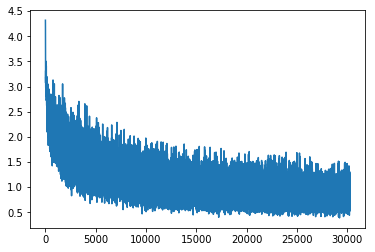

In [252]:
plt.plot(losses)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: